In [1]:
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings("ignore")

In [2]:
# EV Sector Tickers
ev_tickers = [
    "TSLA", "BYDDY", "LI", "NIO", "RIVN", "LCID", "XPEV", "NKLA", "PSNY", "GM", "F",
    "VWAGY", "BAMXF", "HYMTF", "KIMTF", "POAHY", "MBGYY", "STLA", "GELYF", "GWLLY",
    "SAIC", "HYLN", "GNZUF", "TATAMOTORS.NS", "MAHMF", "RNLSY", "NSANY", "MMTOF"
]

# Financial Banking Sector Tickers
finbank_tickers = [
    "JPM", "BAC", "WFC", "C", "GS", "MS", "USB", "PNC", "TFC", "COF", "TD", "SCHW",
    "BK", "STT", "AXP", "HSBC", "CFG", "FITB", "MTB", "HBAN", "ALLY", "KEY", "RY",
    "SAN", "NTRS", "RF", "SYF", "NBHC", "ZION", "FHN"
]

# Technology Sector Tickers
tech_tickers = [
    "AAPL", "MSFT", "GOOGL", "GOOG", "AMZN", "META", "NVDA", "TSM", "ADBE", "INTC",
    "CSCO", "ORCL", "IBM", "CRM", "QCOM", "AVGO", "TXN", "AMD", "AMAT", "MU", "NET",
    "NOW", "SNOW", "DOCU", "SHOP", "UBER", "LYFT", "SNAP", "HRB", "DDOG"
]

## Load Data

### Step 1: Load Sentiment Data

In [3]:
# Load sentiment data
sentiment_path = './data/sentiment/company_sentiment_20250422_004923.csv'
sentiment_data = pd.read_csv(sentiment_path)

# Display first few rows of sentiment data
print("\nSentiment Data:")
print(sentiment_data.head())


Sentiment Data:
  ticker  general_sentiment  ai_sentiment  combined_sentiment      sector
0   AAPL          -0.812796     -0.822268           -0.817532  Technology
1   ADBE          -0.882552     -0.892091           -0.887321  Technology
2   ALLY          -0.732661     -0.631604           -0.682133   Financial
3   AMAT          -0.761783     -0.938038           -0.849911  Technology
4    AMD          -0.811916     -0.861805           -0.836860  Technology


### Step 2: Load Stock Price Data and Compute Returns

In [4]:
import os
import pandas as pd

# Define paths to sector folders
sector_folders = {
    "EV": "./data/quantitative/ev",
    "FinBank": "./data/quantitative/fin_bank",
    "Tech": "./data/quantitative/tech"
}

# Initialize an empty dictionary to store stock returns
stock_returns = {}

# Function to load stock price data and compute returns
def load_stock_returns(tickers, folder_path):
    for ticker in tickers:
        file_path = os.path.join(folder_path, f"{ticker}.csv")
        try:
            # Load data with specified encoding
            df = pd.read_csv(file_path, parse_dates=['Date'], index_col='Date', encoding='latin1')
            
            # Compute daily returns from 'Adj Close' prices
            df['Returns'] = df['Adj Close'].pct_change()
            
            # Store returns for the ticker
            stock_returns[ticker] = df['Returns']
        except Exception as e:
            print(f"Error loading data for {ticker}: {e}")

# EV Sector Tickers
ev_tickers = [
    "TSLA", "BYDDY", "LI", "NIO", "RIVN", "LCID", "XPEV", "NKLA", "PSNY", "GM", "F",
    "VWAGY", "BAMXF", "HYMTF", "KIMTF", "POAHY", "MBGYY", "STLA", "GELYF", "GWLLY",
    "SAIC", "HYLN", "GNZUF", "TATAMOTORS.NS", "MAHMF", "RNLSY", "NSANY", "MMTOF"
]

# Financial Banking Sector Tickers
finbank_tickers = [
    "JPM", "BAC", "WFC", "C", "GS", "MS", "USB", "PNC", "TFC", "COF", "TD", "SCHW",
    "BK", "STT", "AXP", "HSBC", "CFG", "FITB", "MTB", "HBAN", "ALLY", "KEY", "RY",
    "SAN", "NTRS", "RF", "SYF", "NBHC", "ZION", "FHN"
]

# Technology Sector Tickers
tech_tickers = [
    "AAPL", "MSFT", "GOOGL", "GOOG", "AMZN", "META", "NVDA", "TSM", "ADBE", "INTC",
    "CSCO", "ORCL", "IBM", "CRM", "QCOM", "AVGO", "TXN", "AMD", "AMAT", "MU", "NET",
    "NOW", "SNOW", "DOCU", "SHOP", "UBER", "LYFT", "SNAP", "HRB", "DDOG"
]

# Load stock returns for each sector
load_stock_returns(ev_tickers, sector_folders["EV"])
load_stock_returns(finbank_tickers, sector_folders["FinBank"])
load_stock_returns(tech_tickers, sector_folders["Tech"])

# Combine all stock returns into a single DataFrame
all_returns = pd.DataFrame(stock_returns)

# Drop rows with NaN values (first row for each ticker will be NaN)
all_returns = all_returns.dropna()

# Display first few rows of stock returns
print("\nStock Returns:")
print(all_returns.head())


Stock Returns:
                TSLA     BYDDY        LI       NIO      RIVN      LCID  \
Date                                                                     
2021-11-11 -0.004158  0.030871  0.033738  0.067004  0.220987  0.103804   
2021-11-12 -0.028293 -0.025145 -0.007833  0.011137  0.056590 -0.023344   
2021-11-15 -0.019382 -0.027479 -0.018092 -0.049215  0.149365  0.021625   
2021-11-16  0.040794  0.039851  0.097487  0.002465  0.151647  0.237077   
2021-11-17  0.032501 -0.025122 -0.017704 -0.024588 -0.150805 -0.053494   

                XPEV      NKLA      PSNY        GM  ...       NET       NOW  \
Date                                                ...                       
2021-11-11  0.073314  0.037572  0.036551  0.043024  ...  0.004607  0.012431   
2021-11-12  0.019966 -0.026462  0.158228  0.025558  ...  0.043310  0.017887   
2021-11-15 -0.021224 -0.017883  0.153786 -0.006782  ...  0.008986 -0.012771   
2021-11-16  0.052632 -0.026948  0.037212 -0.005717  ...  0.026960  0.0

### Step 3: Map Sentiment Scores to Stock Returns

In [5]:
# Create a new DataFrame to store combined data
combined_data = all_returns.copy()

# Add sentiment columns to the combined data
for ticker in combined_data.columns:
    if ticker in sentiment_data['ticker'].values:
        # Get sentiment scores for the ticker
        ticker_sentiment = sentiment_data[sentiment_data['ticker'] == ticker].iloc[0]
        general_sentiment = ticker_sentiment['general_sentiment']
        ai_sentiment = ticker_sentiment['ai_sentiment']
        
        # Assign sentiment scores to all rows for the ticker
        combined_data[f'{ticker}_general_sentiment'] = general_sentiment
        combined_data[f'{ticker}_ai_sentiment'] = ai_sentiment

# Display first few rows of combined data
print("\nCombined Data:")
print(combined_data.head())


Combined Data:
                TSLA     BYDDY        LI       NIO      RIVN      LCID  \
Date                                                                     
2021-11-11 -0.004158  0.030871  0.033738  0.067004  0.220987  0.103804   
2021-11-12 -0.028293 -0.025145 -0.007833  0.011137  0.056590 -0.023344   
2021-11-15 -0.019382 -0.027479 -0.018092 -0.049215  0.149365  0.021625   
2021-11-16  0.040794  0.039851  0.097487  0.002465  0.151647  0.237077   
2021-11-17  0.032501 -0.025122 -0.017704 -0.024588 -0.150805 -0.053494   

                XPEV      NKLA      PSNY        GM  ...  \
Date                                                ...   
2021-11-11  0.073314  0.037572  0.036551  0.043024  ...   
2021-11-12  0.019966 -0.026462  0.158228  0.025558  ...   
2021-11-15 -0.021224 -0.017883  0.153786 -0.006782  ...   
2021-11-16  0.052632 -0.026948  0.037212 -0.005717  ...   
2021-11-17 -0.034000  0.002246 -0.050881  0.031944  ...   

            UBER_general_sentiment  UBER_ai_sentime

### Step 4: Fit ARIMAX Models and Evaluate Performance

In [6]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

def fit_arimax(endog_train, exog_train, order=(1, 1, 1)):
    """
    Fits an ARIMAX model to the training data.
    
    Parameters:
        endog_train (pd.Series): Training endogenous variable (stock returns).
        exog_train (pd.DataFrame): Training exogenous variables (sentiment data).
        order (tuple): ARIMAX order (p, d, q).
    
    Returns:
        SARIMAXResultsWrapper: Trained ARIMAX model.
    """
    # Fit ARIMAX model
    model = SARIMAX(endog_train, exog=exog_train, order=order, enforce_stationarity=False, enforce_invertibility=False)
    result = model.fit(disp=False)
    return result

#### Step 5: Define the Evaluate Function

In [7]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt

def evaluate_arimax(ticker, model, endog_test, exog_test):
    """
    Evaluates an ARIMAX model on the test set and generates visualizations.
    
    Parameters:
        ticker (str): Ticker symbol of the company.
        model (SARIMAXResultsWrapper): Trained ARIMAX model.
        endog_test (pd.Series): Test endogenous variable (stock returns).
        exog_test (pd.DataFrame): Test exogenous variables (sentiment data).
    
    Returns:
        dict: Evaluation metrics and predictions.
    """
    # Generate forecasts
    forecast = model.forecast(steps=len(endog_test), exog=exog_test)

    # Compute evaluation metrics
    mae = mean_absolute_error(endog_test, forecast)
    mse = mean_squared_error(endog_test, forecast)
    rmse = np.sqrt(mse)
    aic = model.aic

    # Plot predictions vs actual returns
    plot_arimax_forecast(ticker, endog_test, forecast)

    # Return results
    return {
        "Ticker": ticker,
        "Predictions": forecast,
        "Actual": endog_test,
        "MAE": mae,
        "MSE": mse,
        "RMSE": rmse,
        "AIC": aic,
    }

### Define the Plotting Functions

In [8]:
def plot_arimax_forecast(ticker, actual, forecast):
    """
    Plots ARIMAX model predictions vs actual returns.
    
    Parameters:
        ticker (str): Ticker symbol of the company.
        actual (pd.Series): Actual stock returns.
        forecast (pd.Series): Predicted stock returns.
    """
    # Set plot style to dark mode
    plt.style.use('dark_background')
    
    # Create the plot
    plt.figure(figsize=(14, 7))
    
    # Plot actual returns
    plt.plot(actual.index, actual, label="Actual", color="blue", linewidth=1.5)
    
    # Plot forecasted returns
    plt.plot(forecast.index, forecast, label="Forecast", color="orange", linestyle="--", linewidth=1.5)
    
    # Add gridlines
    plt.grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.5)
    
    # Add legend
    plt.legend(loc="upper left", fontsize=12)
    
    # Add title and labels
    plt.title(f"{ticker} - ARIMAX Model Forecast vs Actual", fontsize=14, color="white")
    plt.xlabel("Date", fontsize=12, color="white")
    plt.ylabel("Returns", fontsize=12, color="white")
    
    # Save the graph as an image file
    plt.savefig(f"./graphs_ARIMAX/{ticker}_arimax_predictions.png", dpi=300, bbox_inches='tight')
    
    # Show the plot (optional)
    plt.show()

### Process Each Ticker

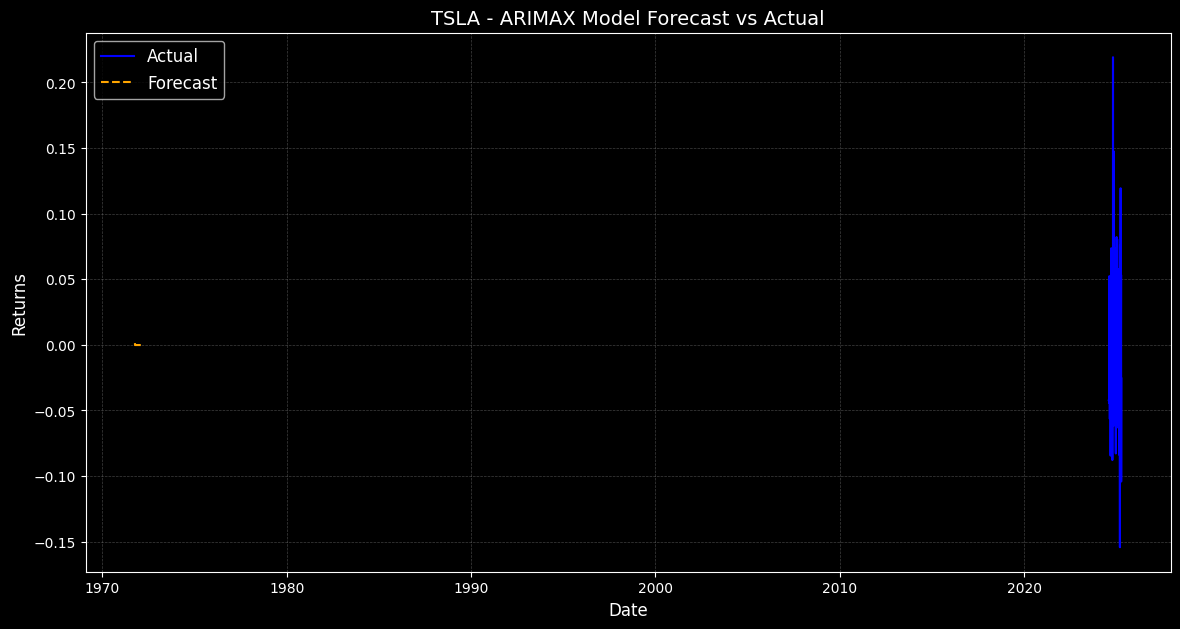


=== ARIMAX Results for TSLA ===
MAE: 0.0336, MSE: 0.0021, RMSE: 0.0456, AIC: -2365.3601


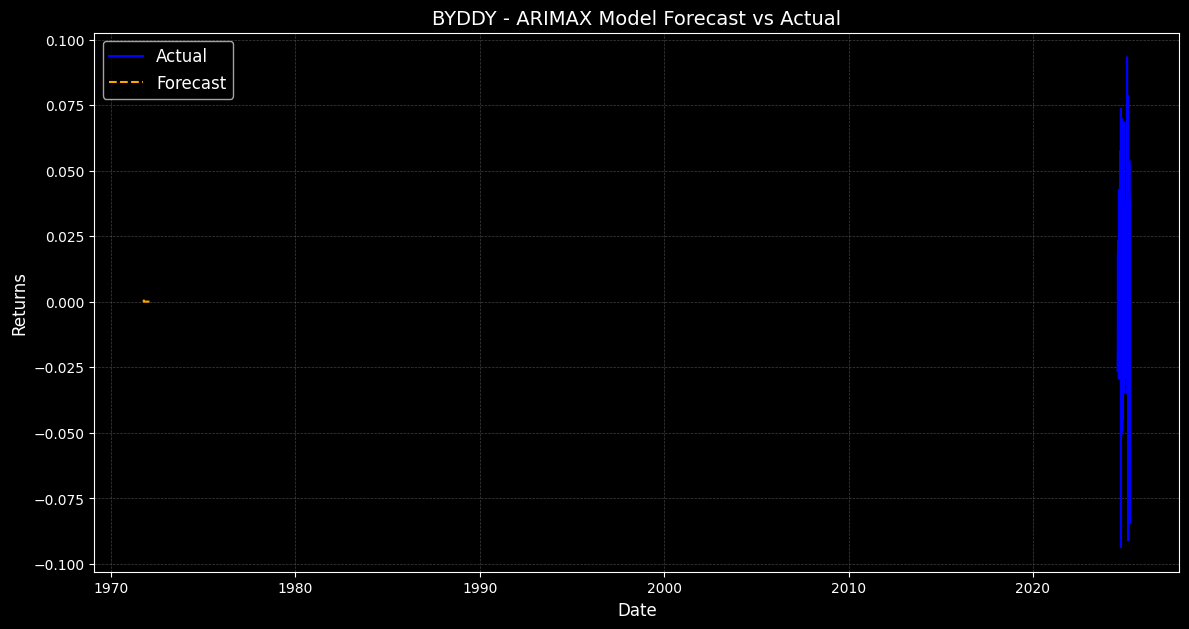


=== ARIMAX Results for BYDDY ===
MAE: 0.0225, MSE: 0.0009, RMSE: 0.0304, AIC: -2698.9696


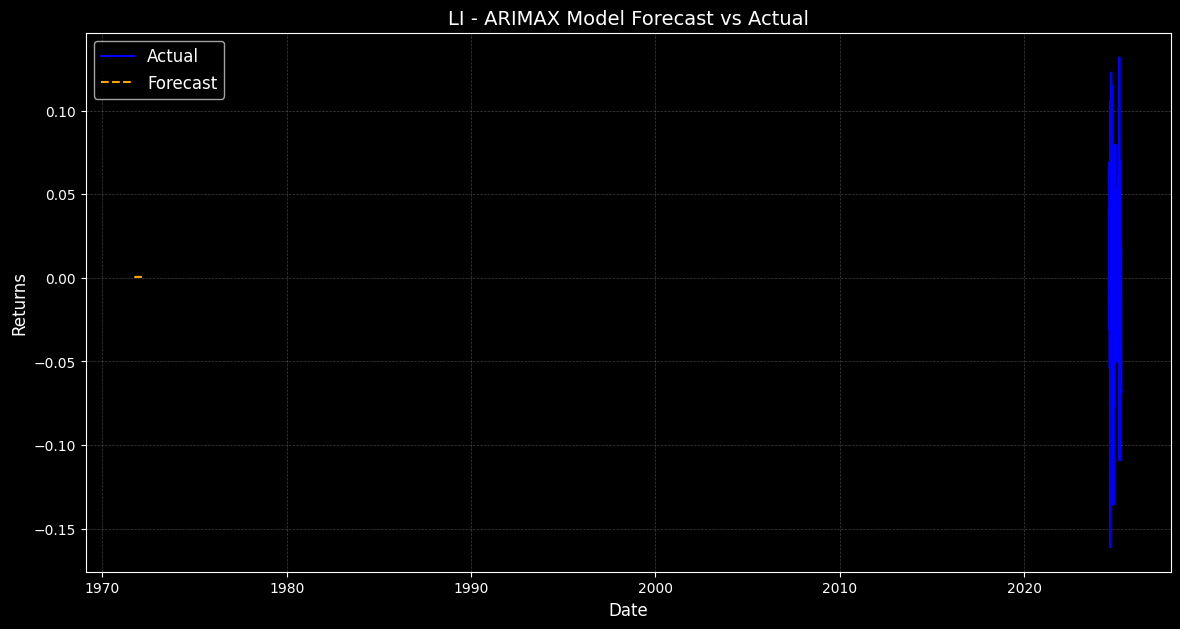


=== ARIMAX Results for LI ===
MAE: 0.0312, MSE: 0.0018, RMSE: 0.0424, AIC: -2168.3500


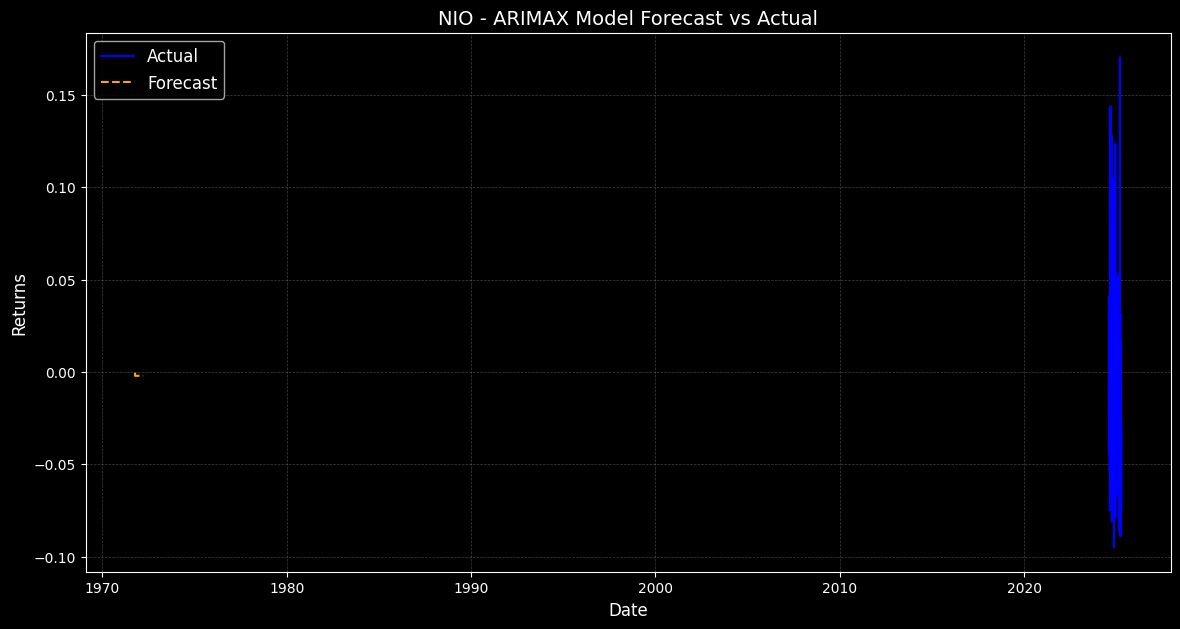


=== ARIMAX Results for NIO ===
MAE: 0.0342, MSE: 0.0020, RMSE: 0.0452, AIC: -2049.0106


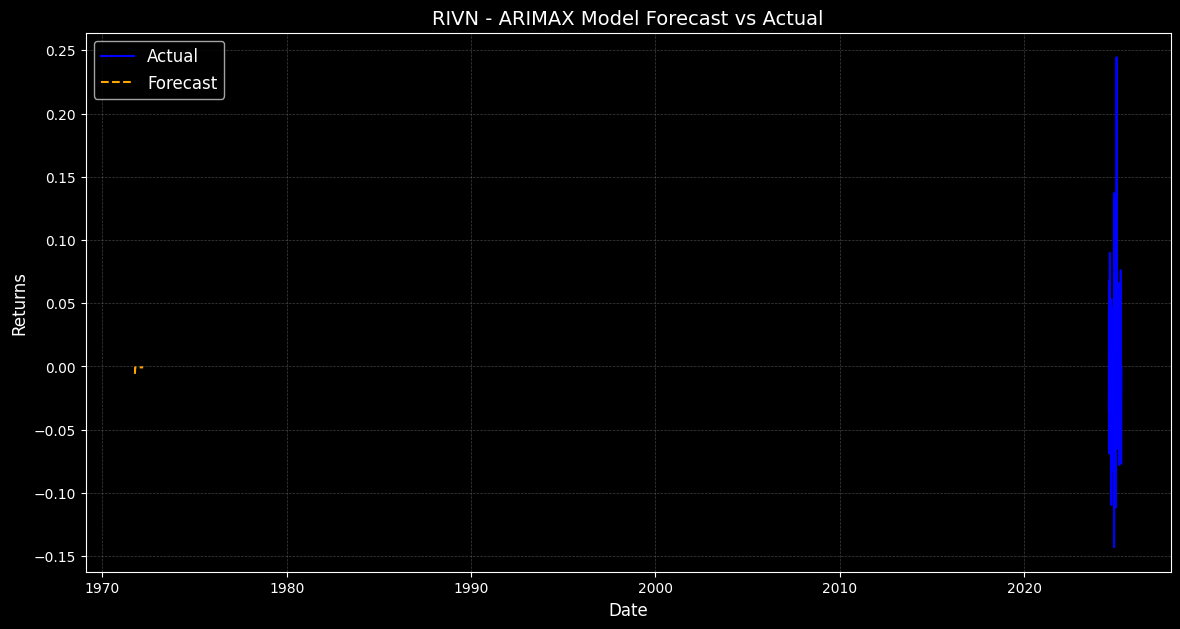


=== ARIMAX Results for RIVN ===
MAE: 0.0327, MSE: 0.0021, RMSE: 0.0458, AIC: -1952.6175


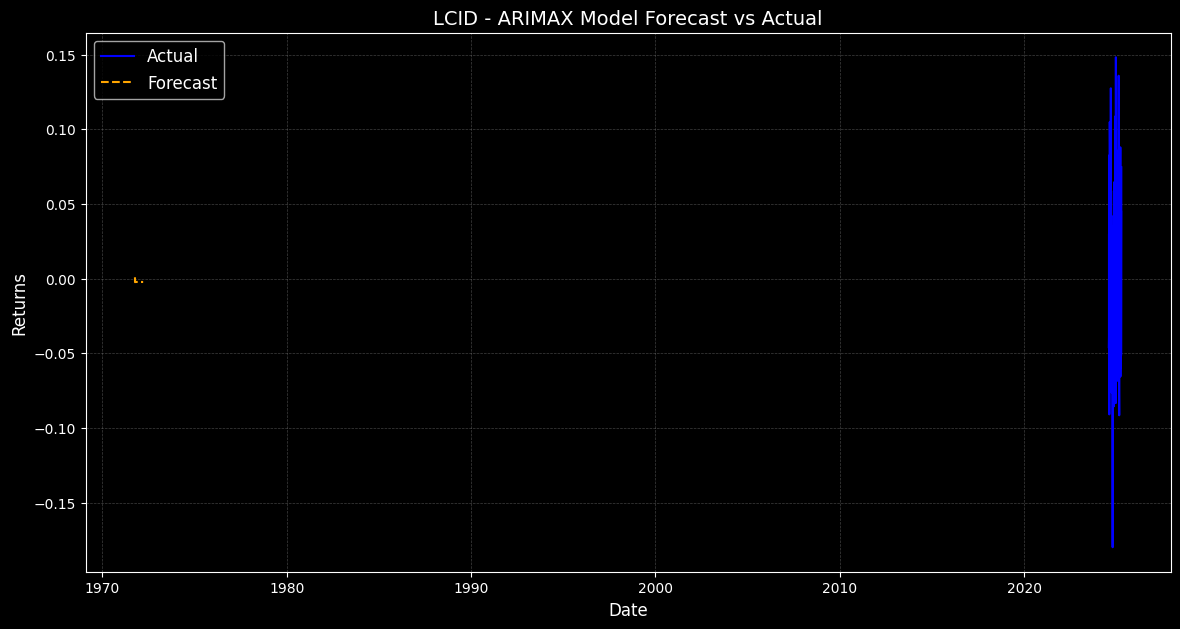


=== ARIMAX Results for LCID ===
MAE: 0.0355, MSE: 0.0022, RMSE: 0.0469, AIC: -1944.3884


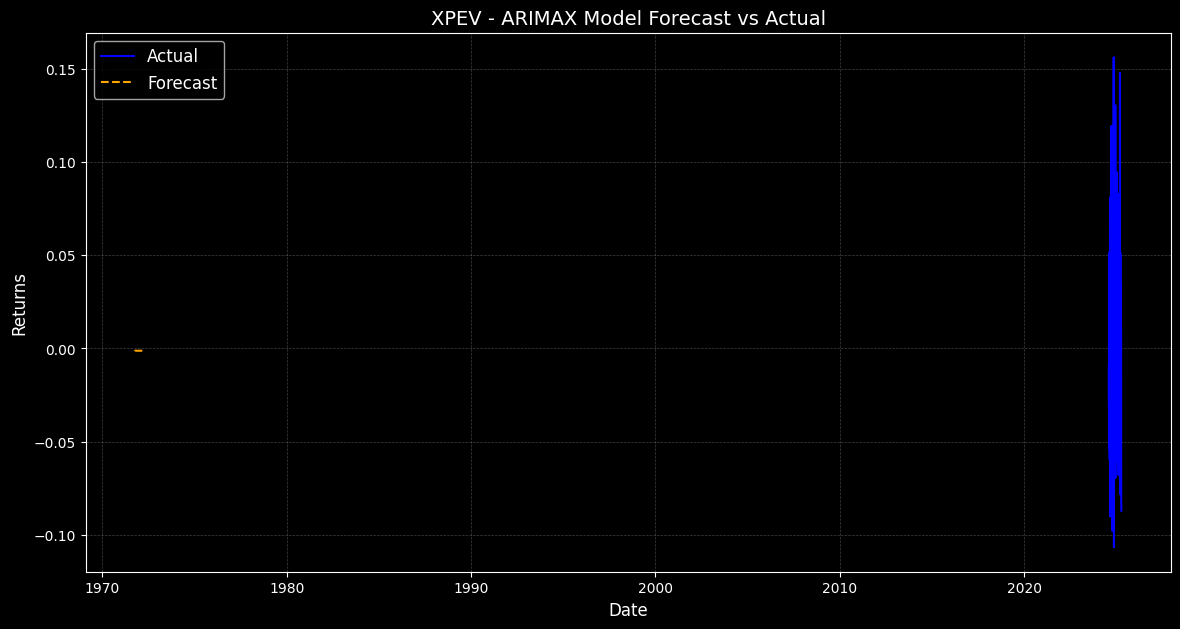


=== ARIMAX Results for XPEV ===
MAE: 0.0389, MSE: 0.0024, RMSE: 0.0489, AIC: -1874.6169


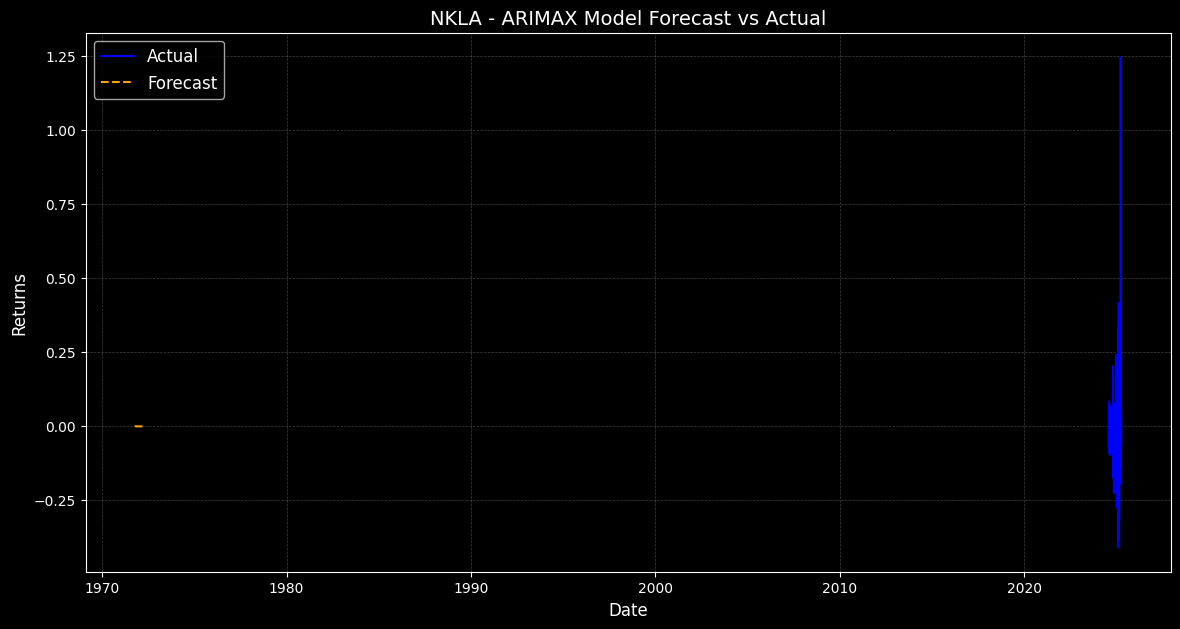


=== ARIMAX Results for NKLA ===
MAE: 0.0772, MSE: 0.0204, RMSE: 0.1427, AIC: -1581.8850


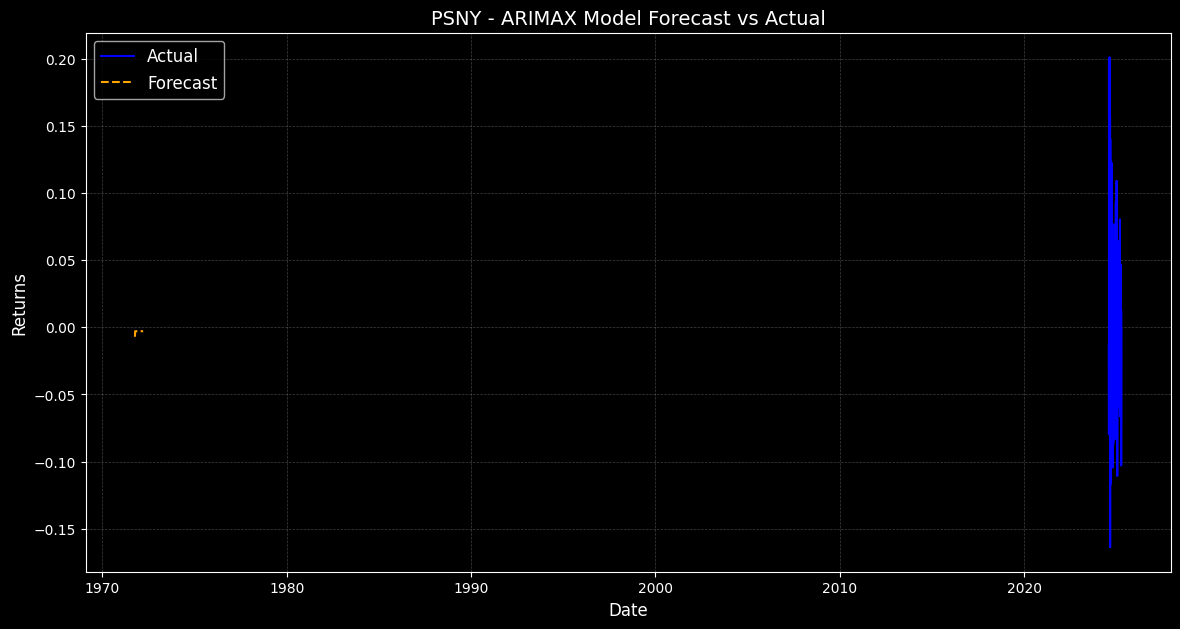


=== ARIMAX Results for PSNY ===
MAE: 0.0432, MSE: 0.0032, RMSE: 0.0568, AIC: -2088.9816


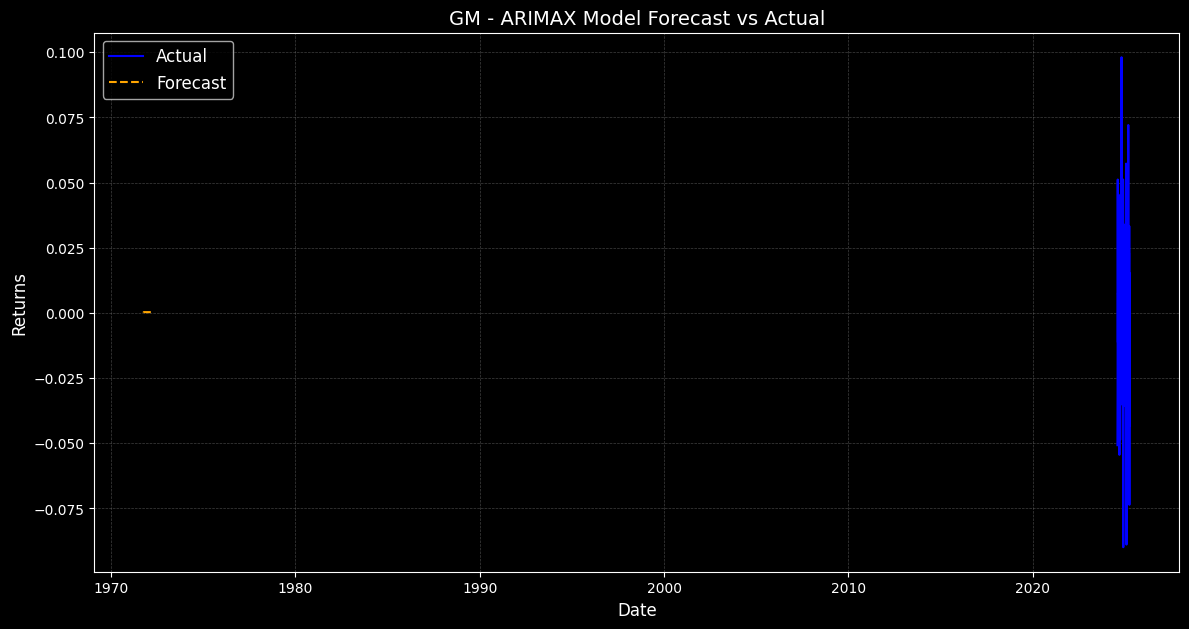


=== ARIMAX Results for GM ===
MAE: 0.0173, MSE: 0.0006, RMSE: 0.0248, AIC: -2981.5406


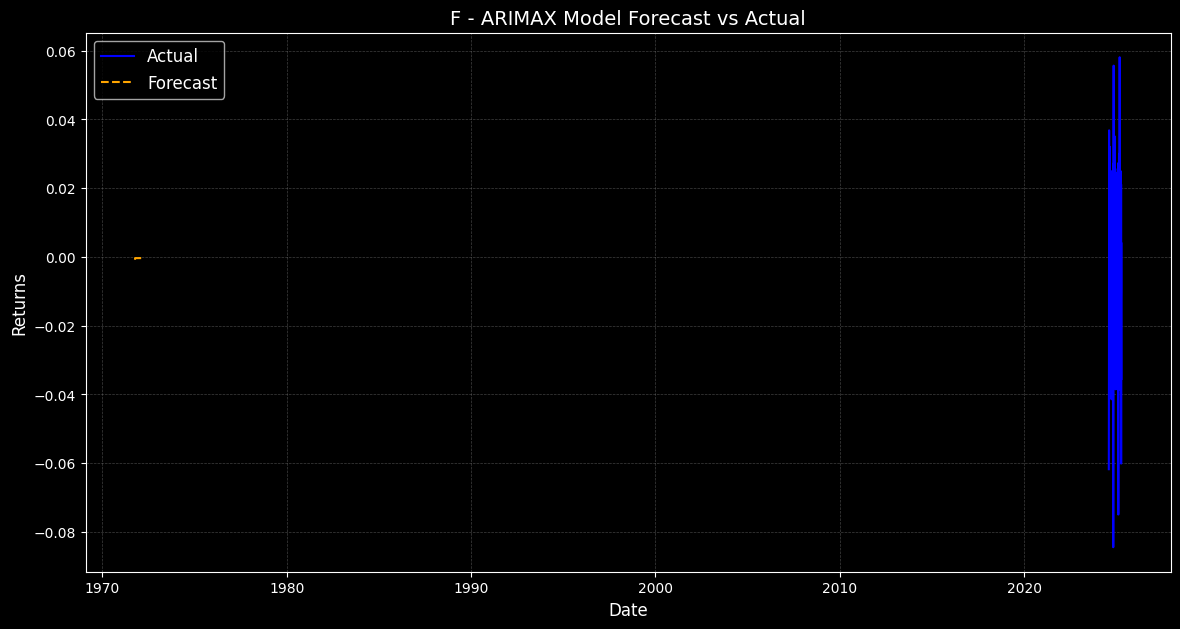


=== ARIMAX Results for F ===
MAE: 0.0151, MSE: 0.0004, RMSE: 0.0206, AIC: -2821.9453


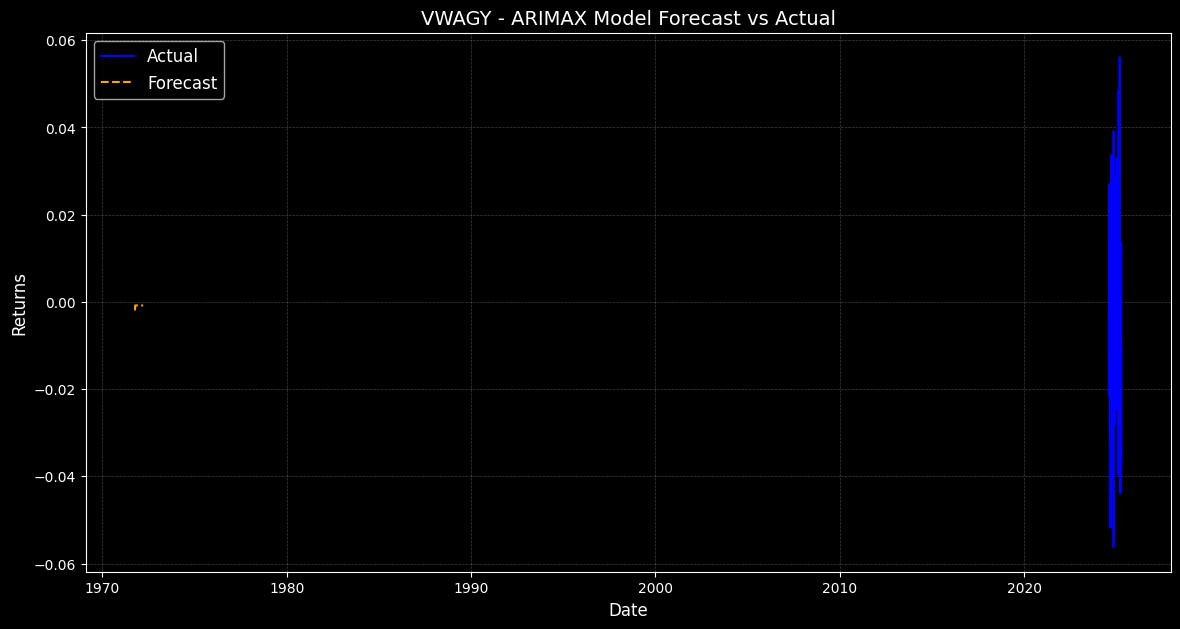


=== ARIMAX Results for VWAGY ===
MAE: 0.0148, MSE: 0.0004, RMSE: 0.0190, AIC: -3005.0445


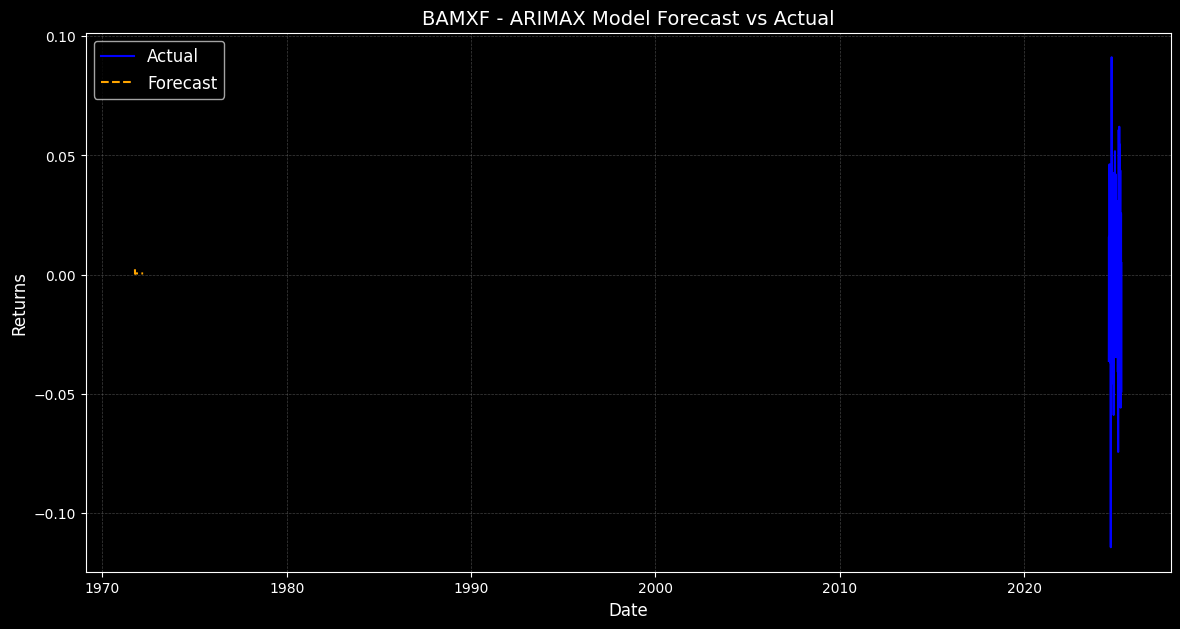


=== ARIMAX Results for BAMXF ===
MAE: 0.0183, MSE: 0.0007, RMSE: 0.0263, AIC: -3119.2508


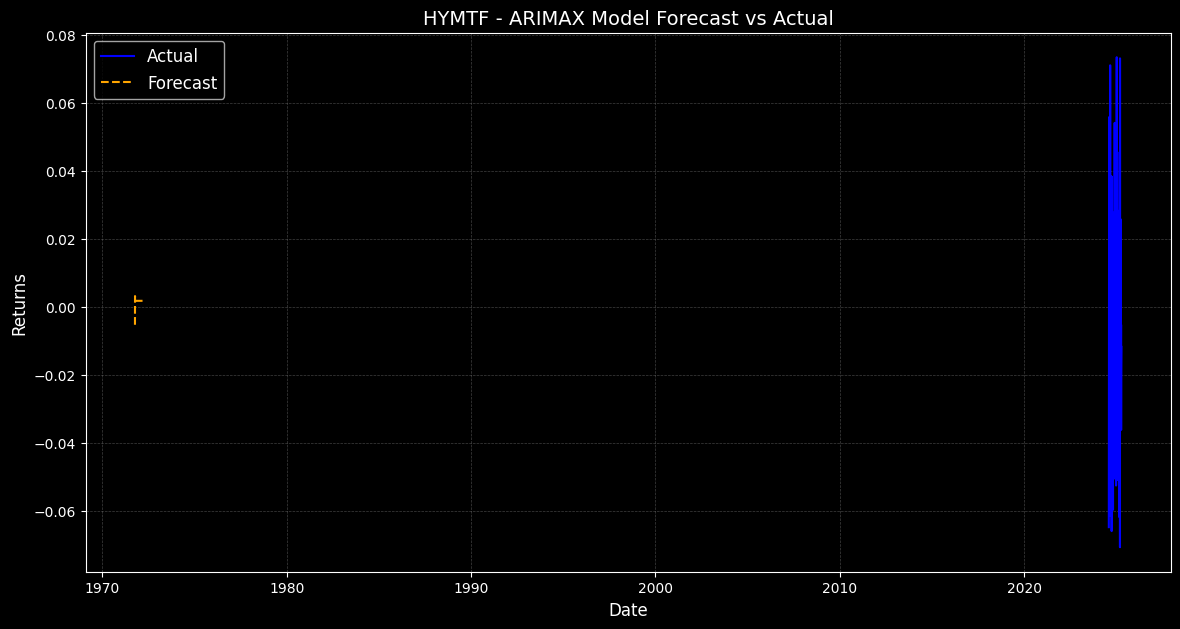


=== ARIMAX Results for HYMTF ===
MAE: 0.0199, MSE: 0.0007, RMSE: 0.0267, AIC: -2971.2311


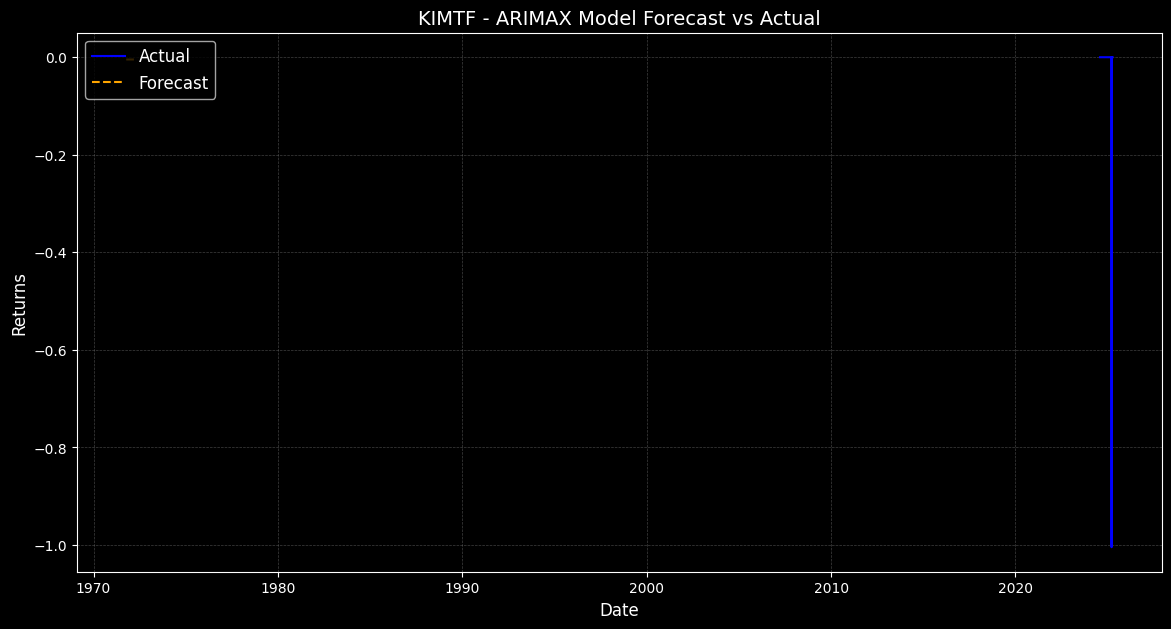


=== ARIMAX Results for KIMTF ===
MAE: 0.0108, MSE: 0.0062, RMSE: 0.0785, AIC: -1610.4215


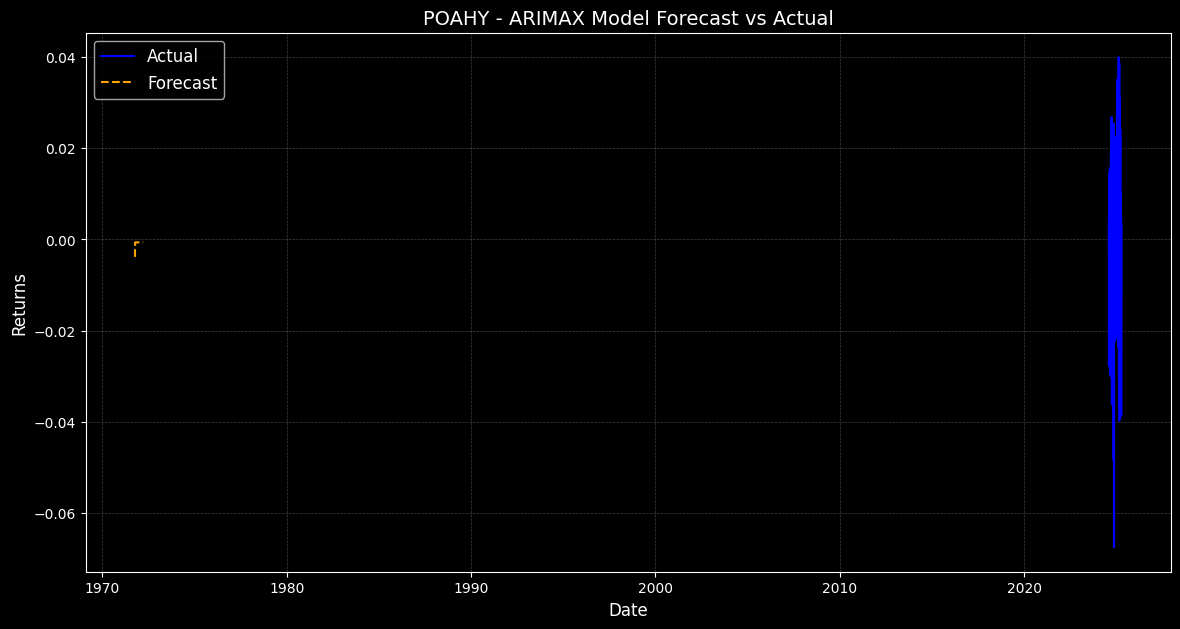


=== ARIMAX Results for POAHY ===
MAE: 0.0125, MSE: 0.0003, RMSE: 0.0164, AIC: -3090.7154


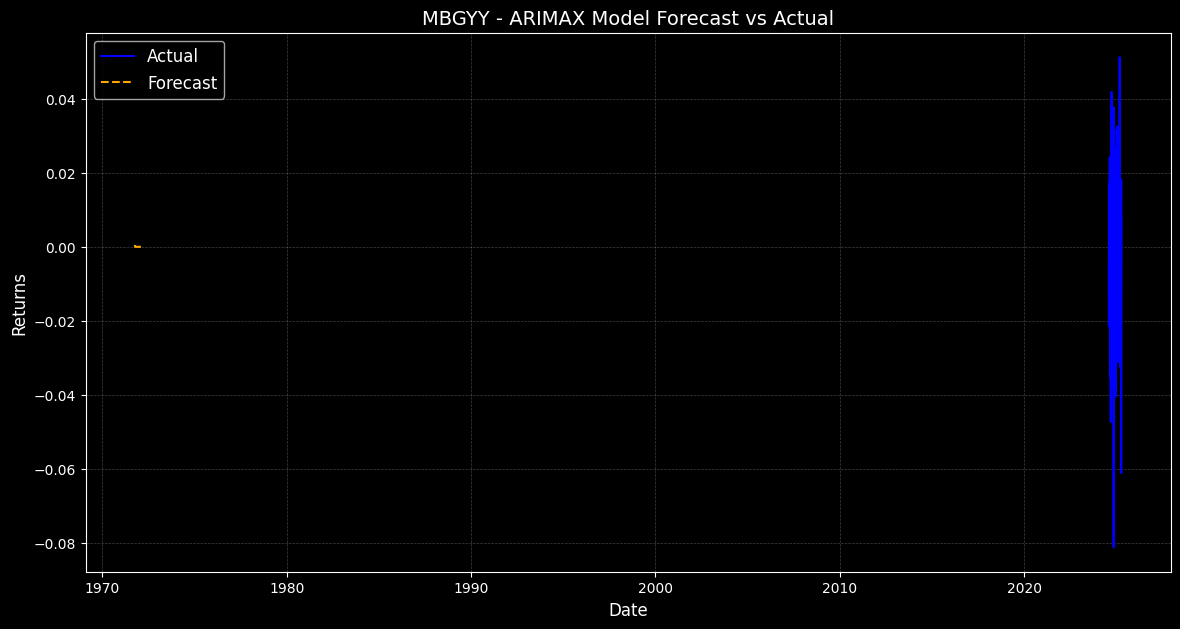


=== ARIMAX Results for MBGYY ===
MAE: 0.0138, MSE: 0.0003, RMSE: 0.0183, AIC: -3144.9832


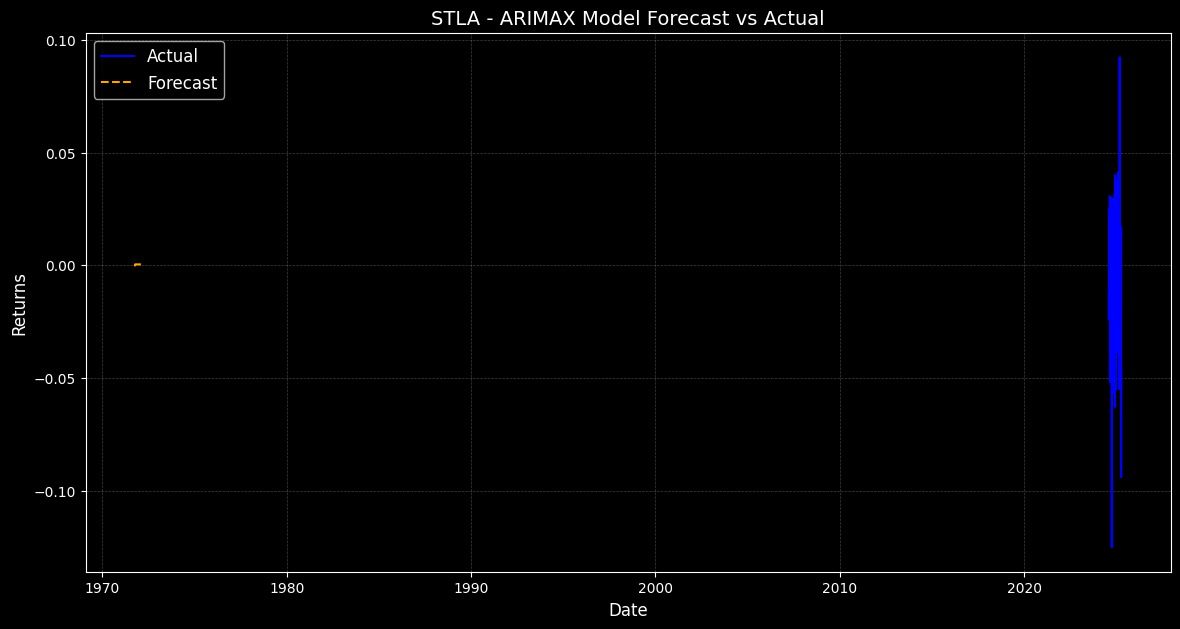


=== ARIMAX Results for STLA ===
MAE: 0.0188, MSE: 0.0007, RMSE: 0.0260, AIC: -3009.8978


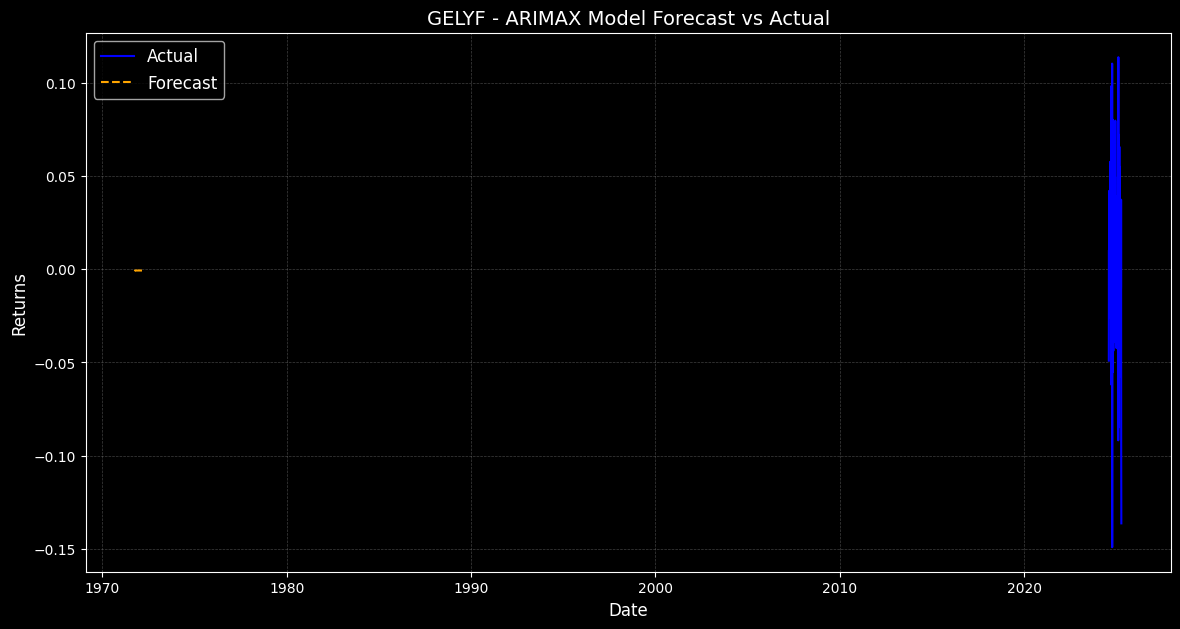


=== ARIMAX Results for GELYF ===
MAE: 0.0284, MSE: 0.0016, RMSE: 0.0397, AIC: -2647.6578


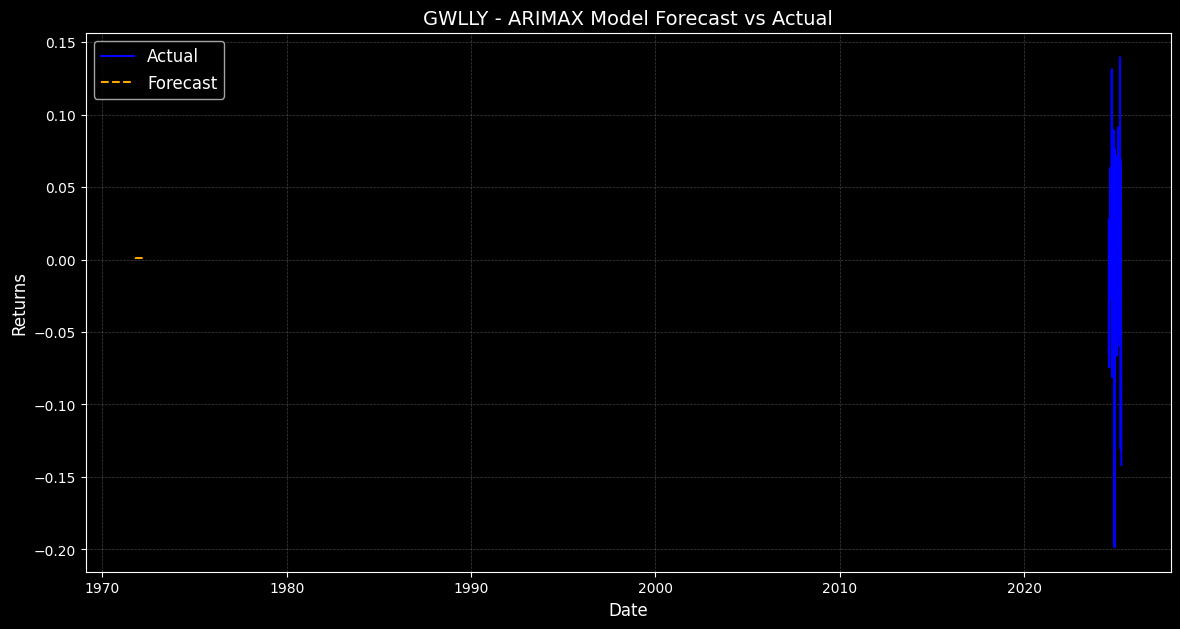


=== ARIMAX Results for GWLLY ===
MAE: 0.0261, MSE: 0.0019, RMSE: 0.0431, AIC: -2242.6615


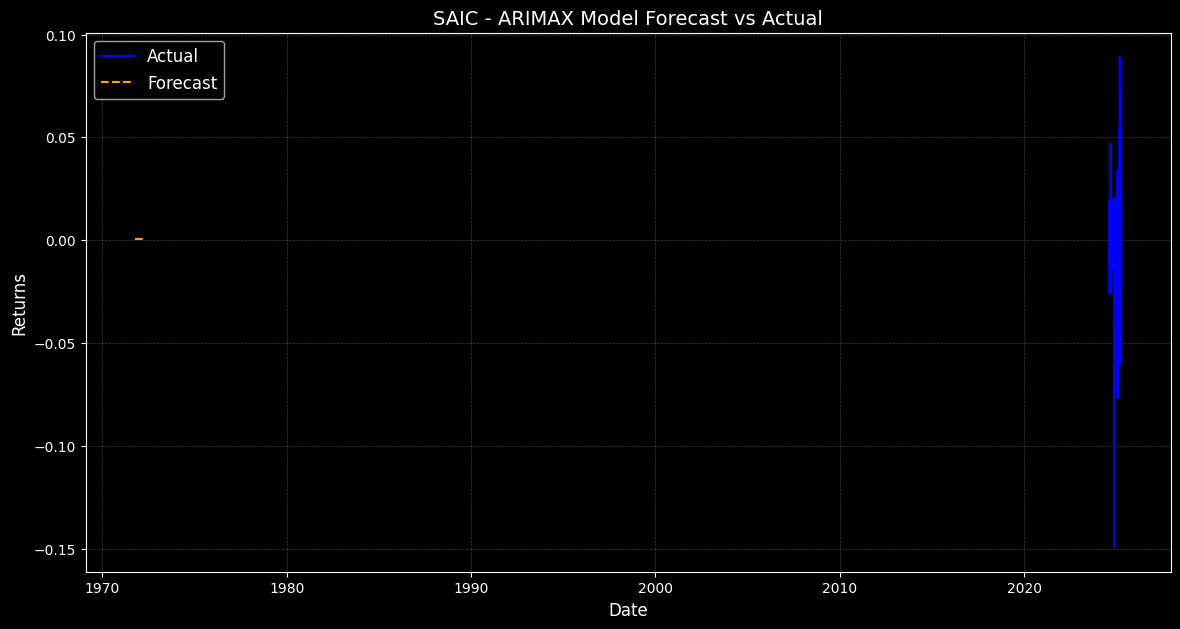


=== ARIMAX Results for SAIC ===
MAE: 0.0135, MSE: 0.0005, RMSE: 0.0223, AIC: -3482.3520


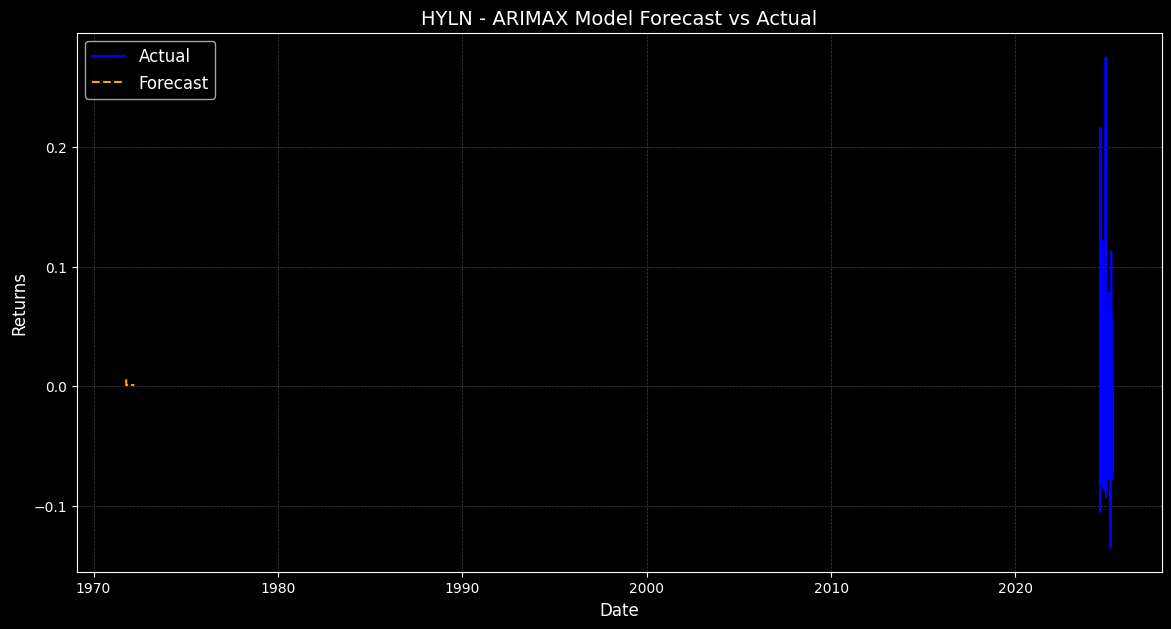


=== ARIMAX Results for HYLN ===
MAE: 0.0383, MSE: 0.0028, RMSE: 0.0530, AIC: -1928.7291


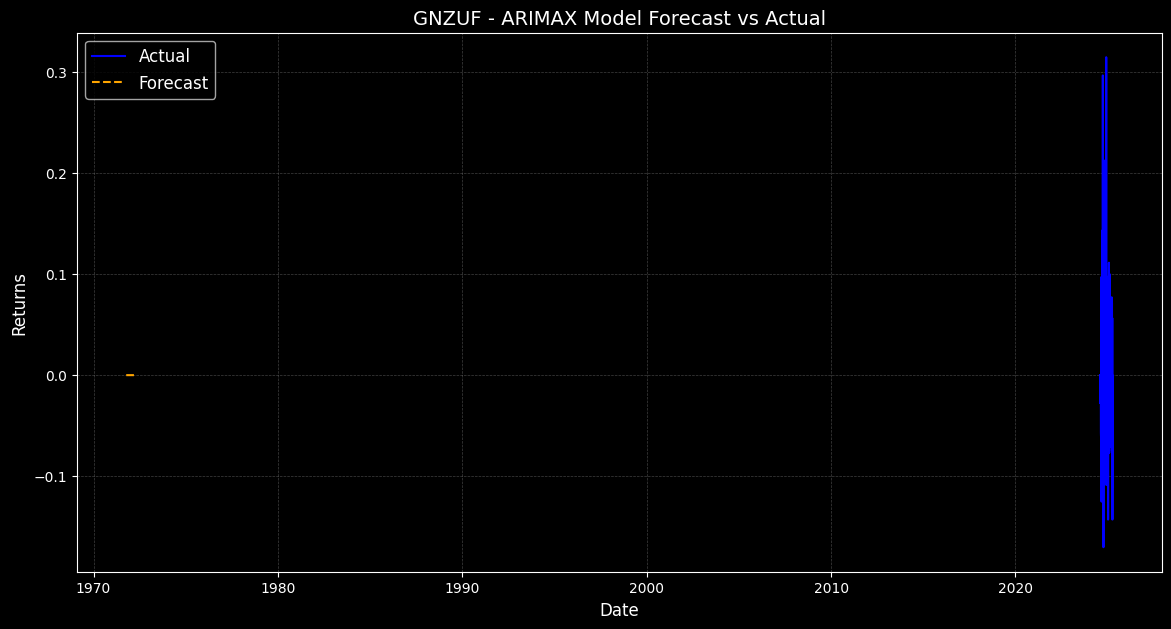


=== ARIMAX Results for GNZUF ===
MAE: 0.0347, MSE: 0.0040, RMSE: 0.0632, AIC: -2394.8210


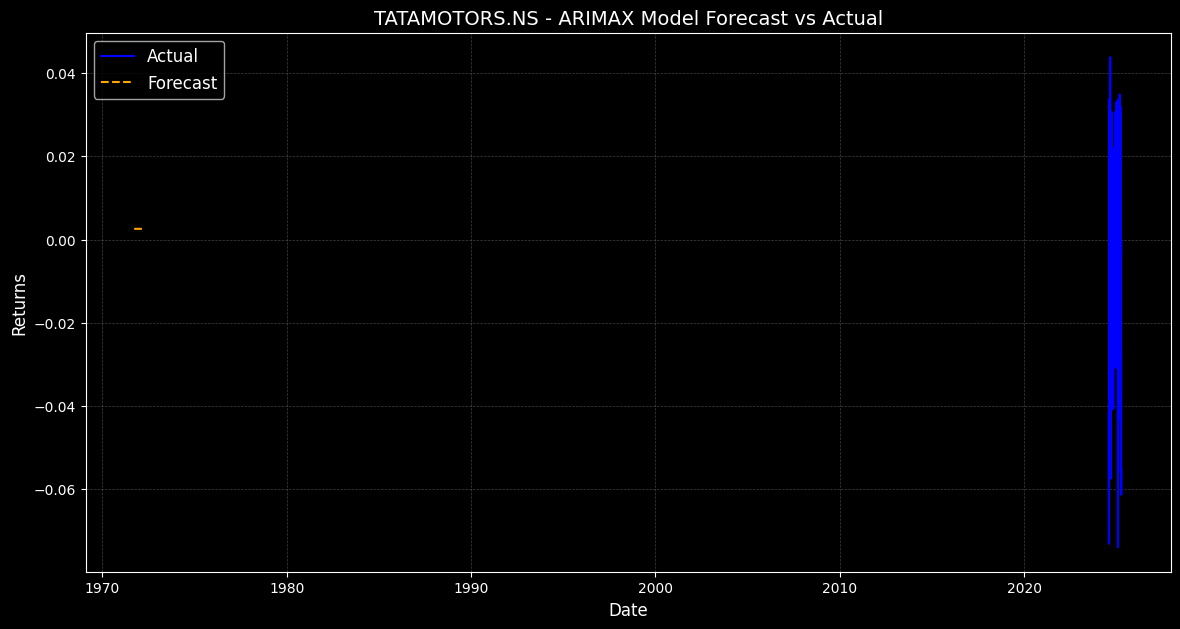


=== ARIMAX Results for TATAMOTORS.NS ===
MAE: 0.0160, MSE: 0.0005, RMSE: 0.0214, AIC: -3228.8165


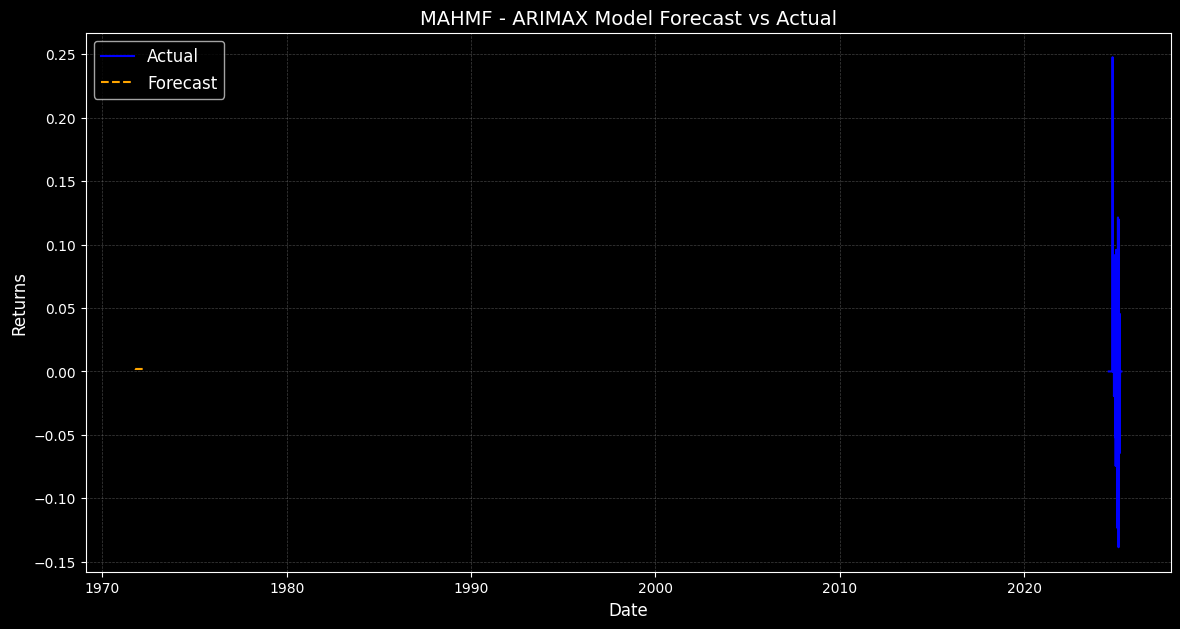


=== ARIMAX Results for MAHMF ===
MAE: 0.0123, MSE: 0.0011, RMSE: 0.0336, AIC: -2648.9390


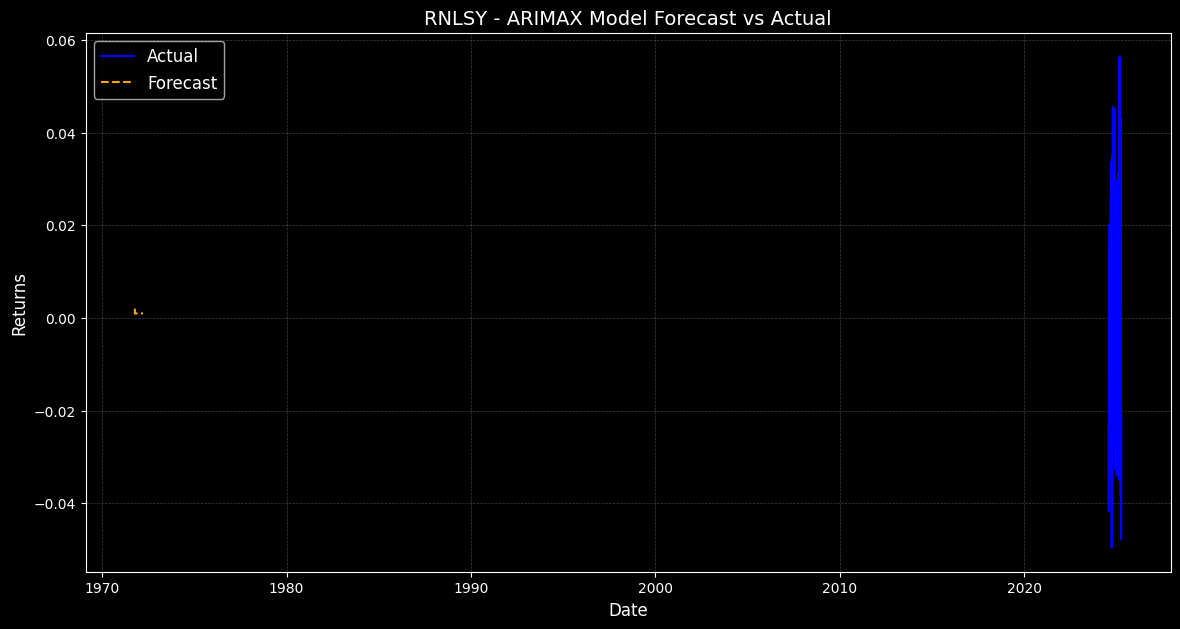


=== ARIMAX Results for RNLSY ===
MAE: 0.0154, MSE: 0.0004, RMSE: 0.0197, AIC: -2793.3569


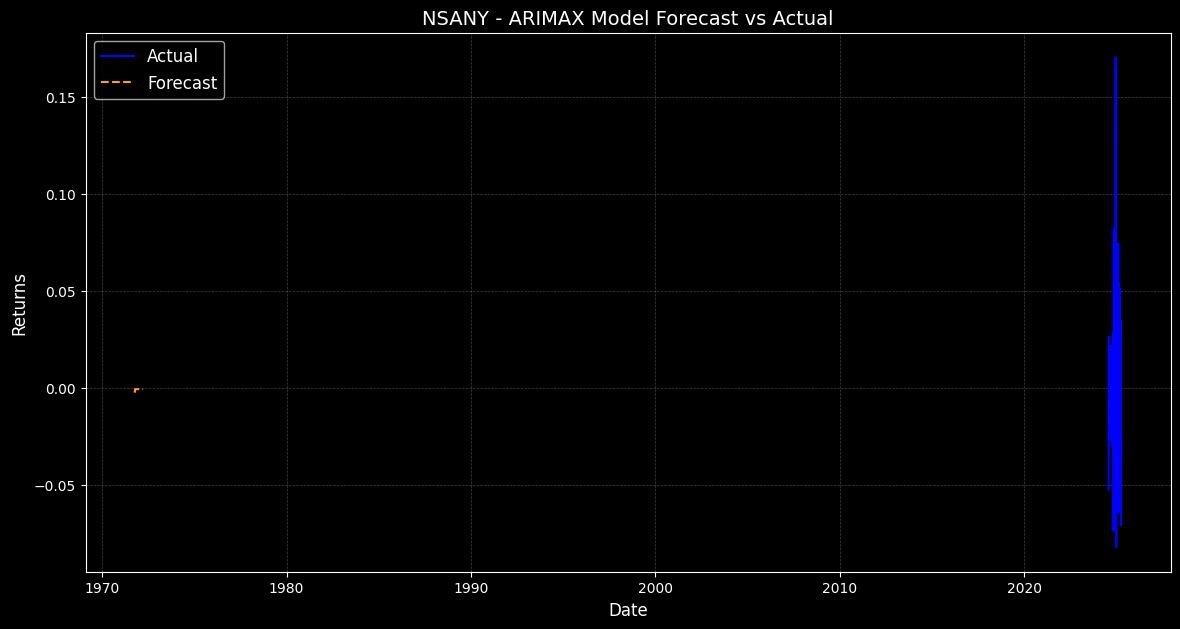


=== ARIMAX Results for NSANY ===
MAE: 0.0219, MSE: 0.0011, RMSE: 0.0336, AIC: -3233.2134


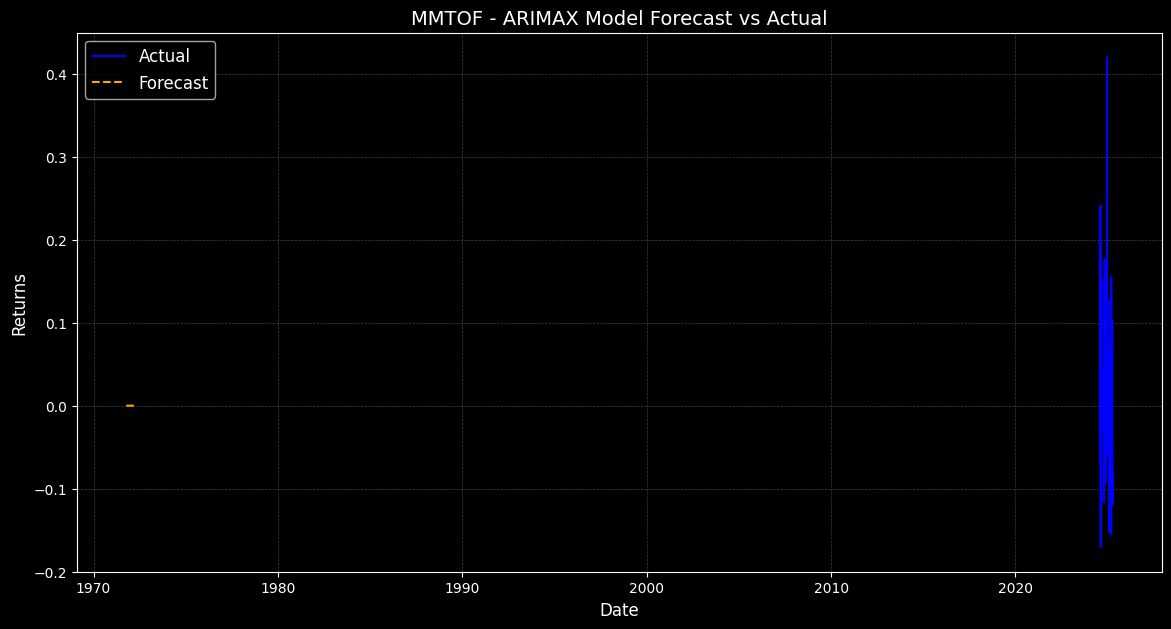


=== ARIMAX Results for MMTOF ===
MAE: 0.0243, MSE: 0.0034, RMSE: 0.0586, AIC: -2820.9141


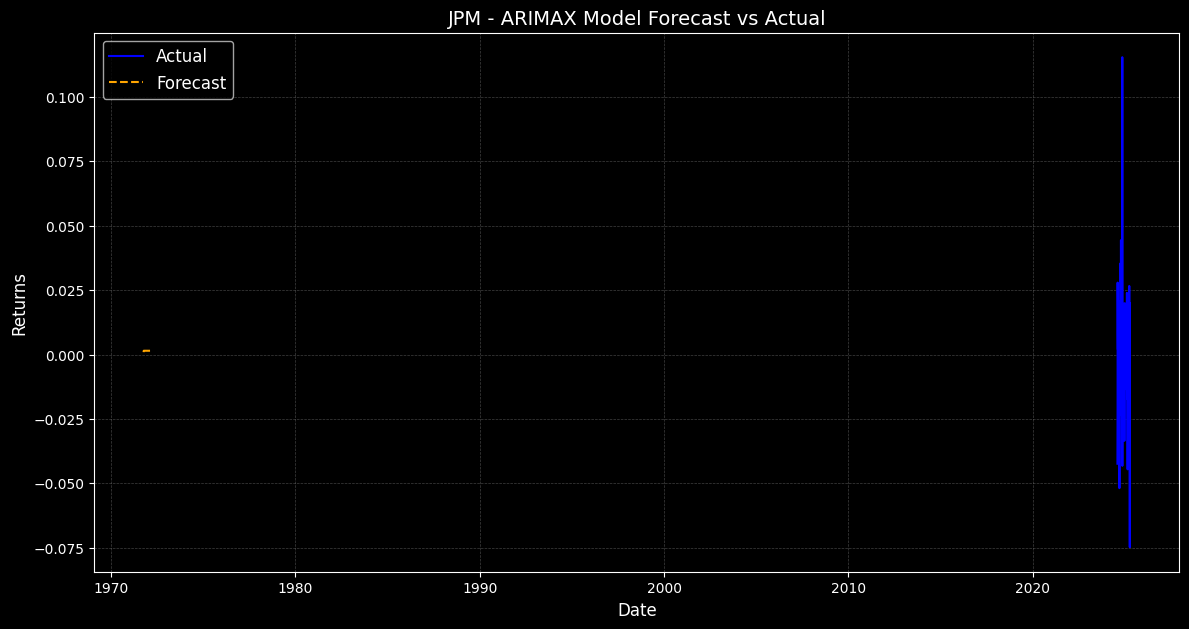


=== ARIMAX Results for JPM ===
MAE: 0.0118, MSE: 0.0004, RMSE: 0.0188, AIC: -3576.6801


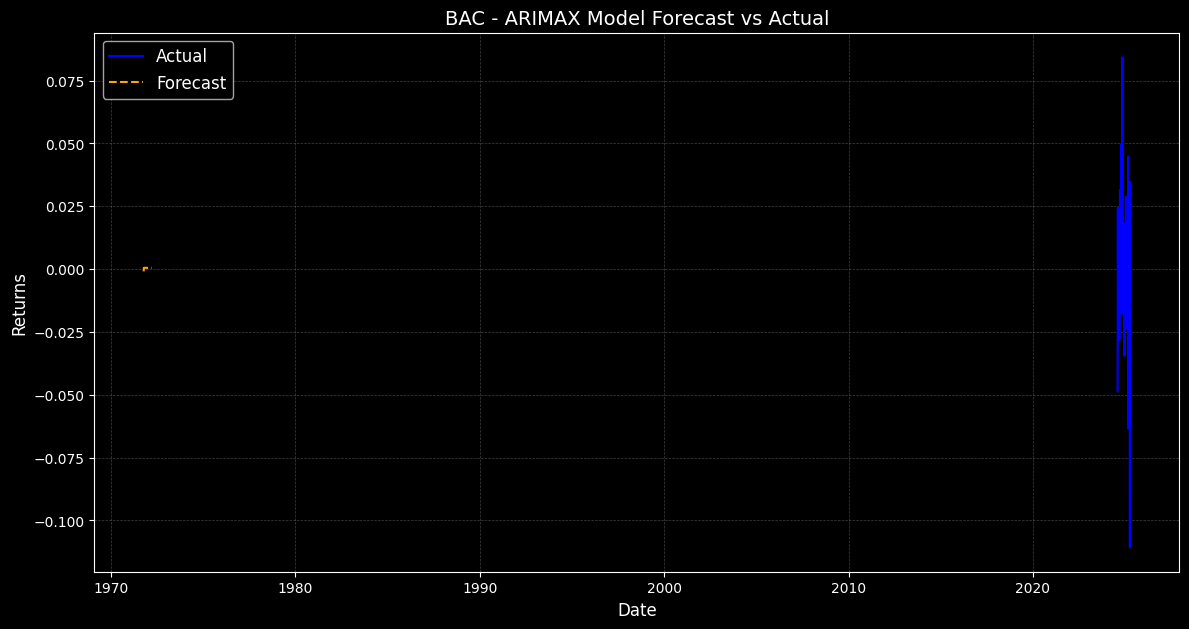


=== ARIMAX Results for BAC ===
MAE: 0.0120, MSE: 0.0004, RMSE: 0.0190, AIC: -3373.2492


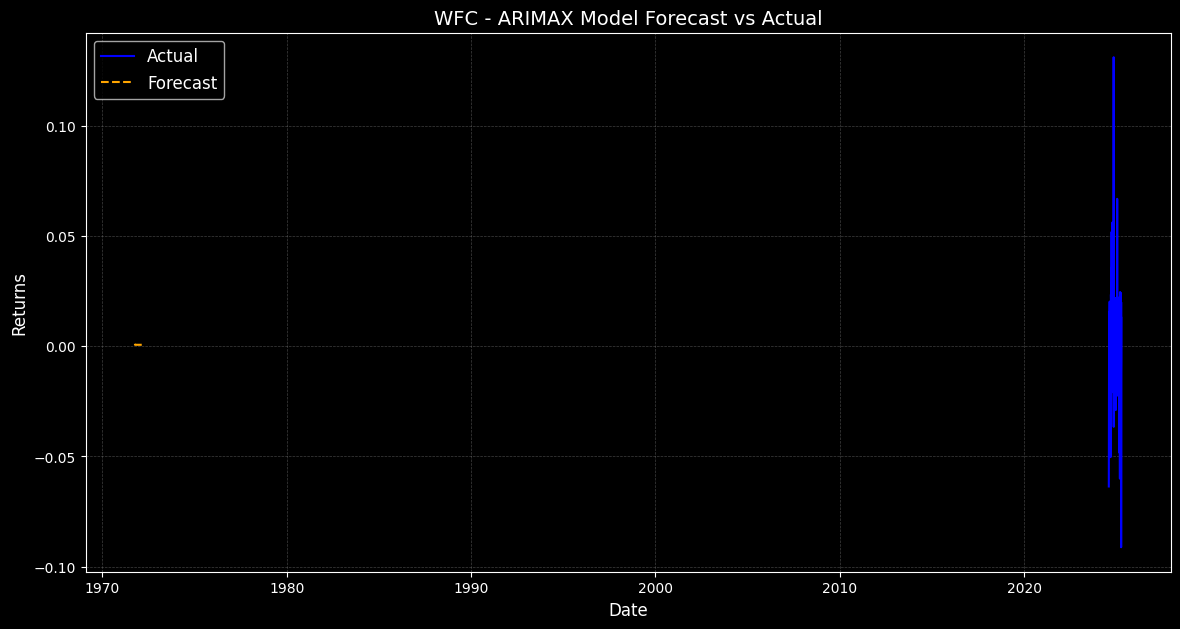


=== ARIMAX Results for WFC ===
MAE: 0.0146, MSE: 0.0005, RMSE: 0.0225, AIC: -3291.9986


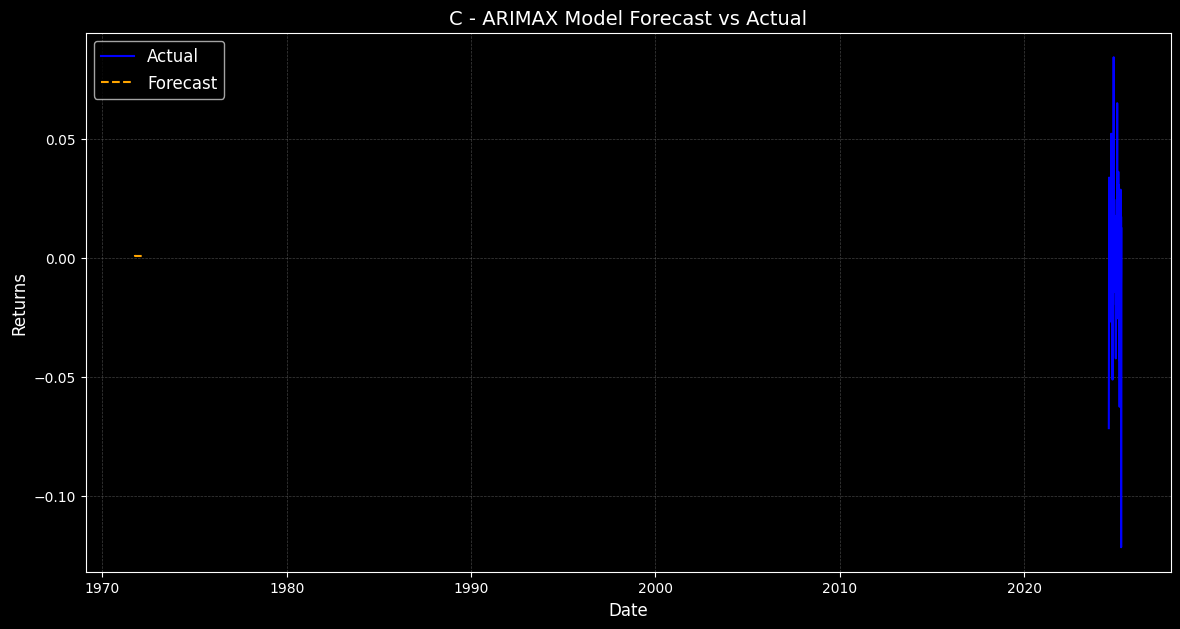


=== ARIMAX Results for C ===
MAE: 0.0151, MSE: 0.0005, RMSE: 0.0226, AIC: -3351.3579


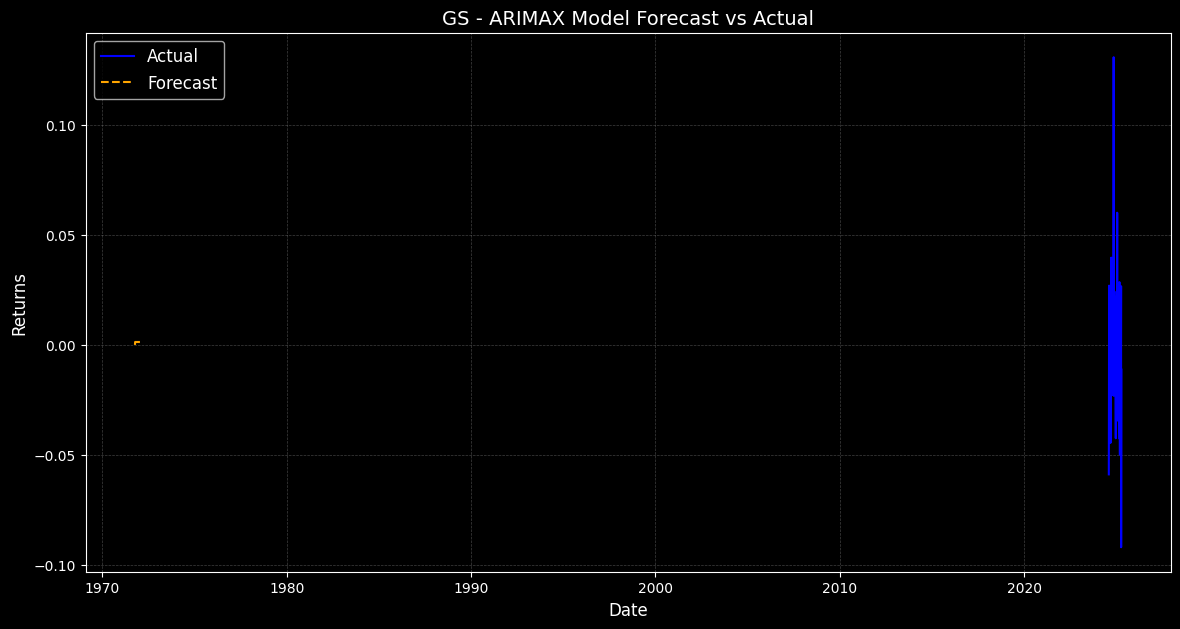


=== ARIMAX Results for GS ===
MAE: 0.0145, MSE: 0.0005, RMSE: 0.0223, AIC: -3471.6014


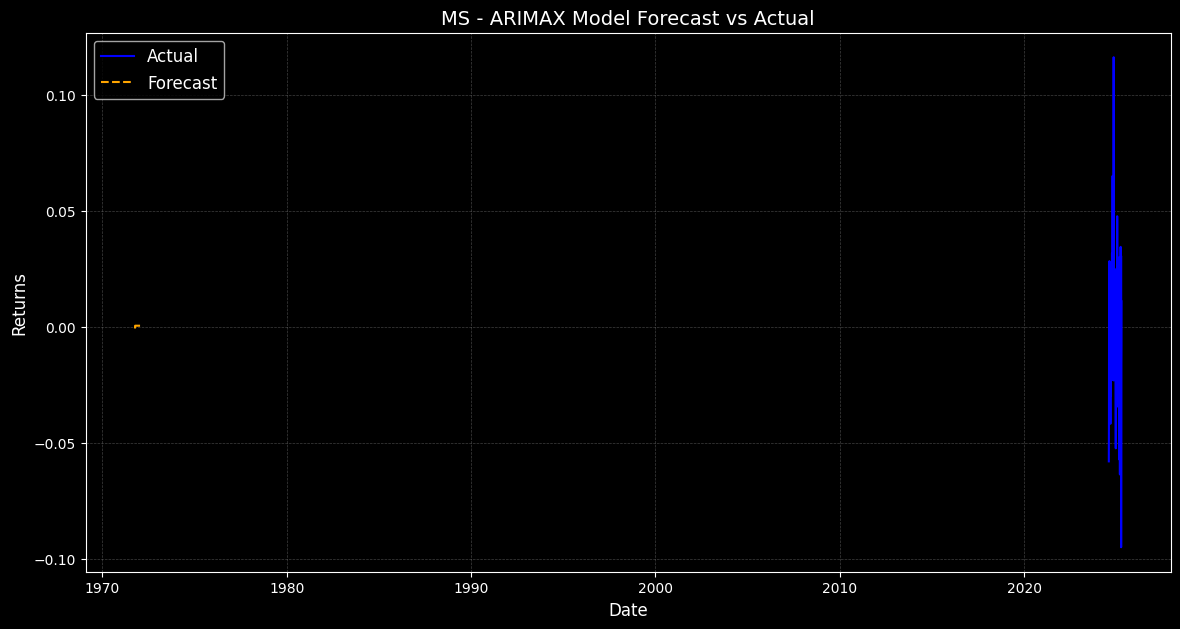


=== ARIMAX Results for MS ===
MAE: 0.0147, MSE: 0.0005, RMSE: 0.0227, AIC: -3382.2117


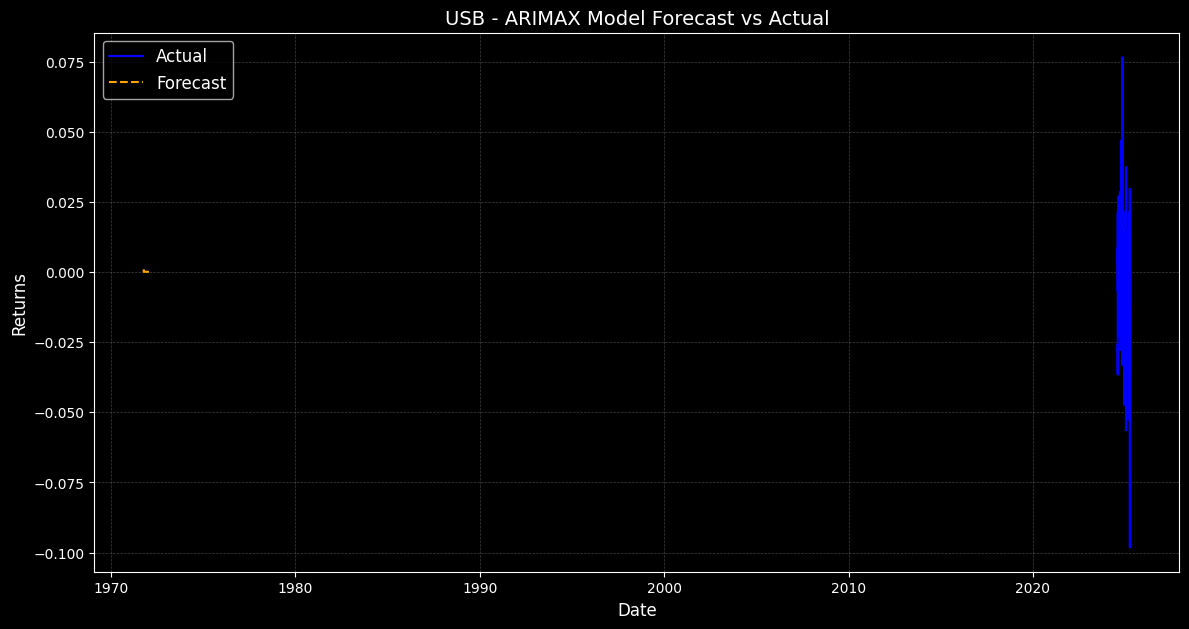


=== ARIMAX Results for USB ===
MAE: 0.0133, MSE: 0.0004, RMSE: 0.0190, AIC: -3173.1200


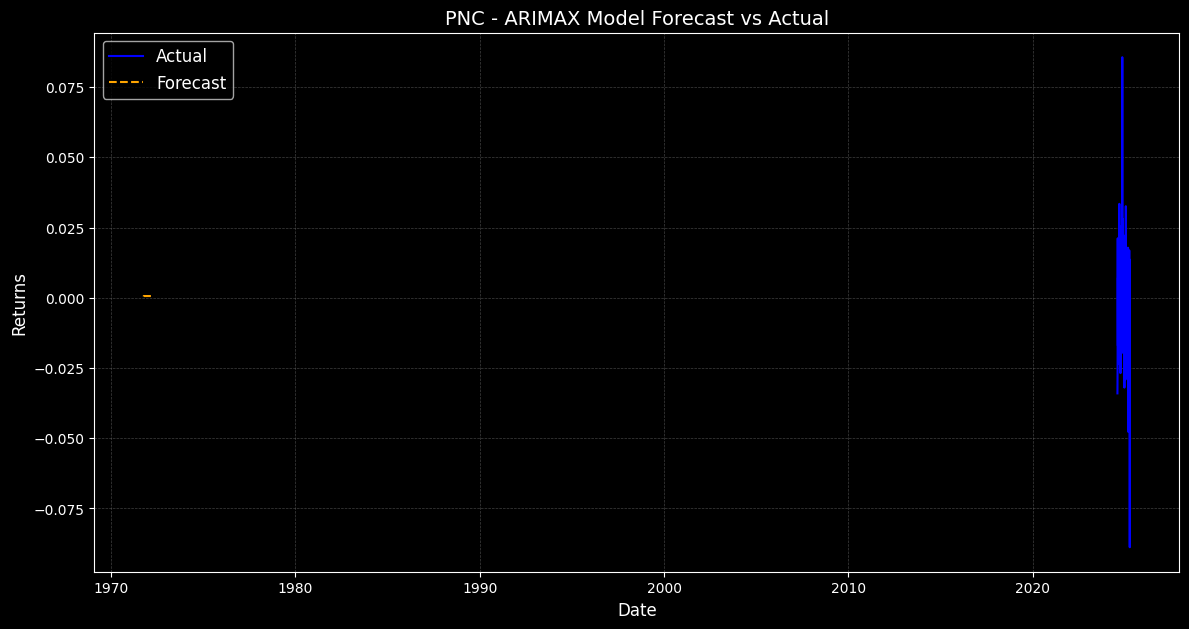


=== ARIMAX Results for PNC ===
MAE: 0.0117, MSE: 0.0003, RMSE: 0.0170, AIC: -3323.3845


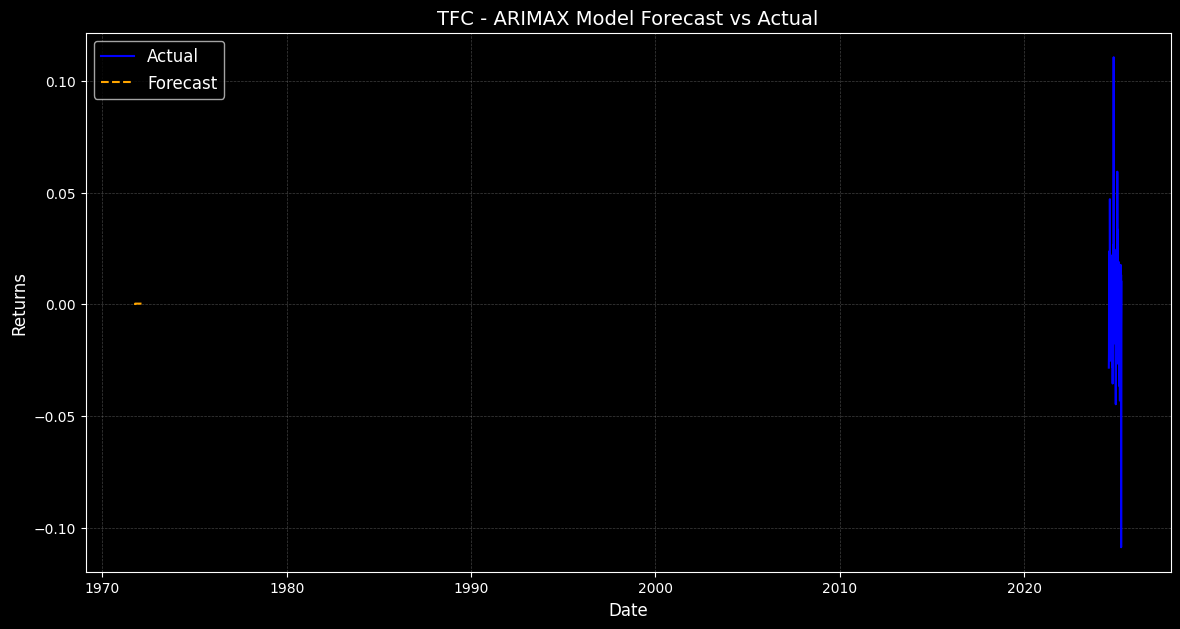


=== ARIMAX Results for TFC ===
MAE: 0.0128, MSE: 0.0004, RMSE: 0.0198, AIC: -3071.1785


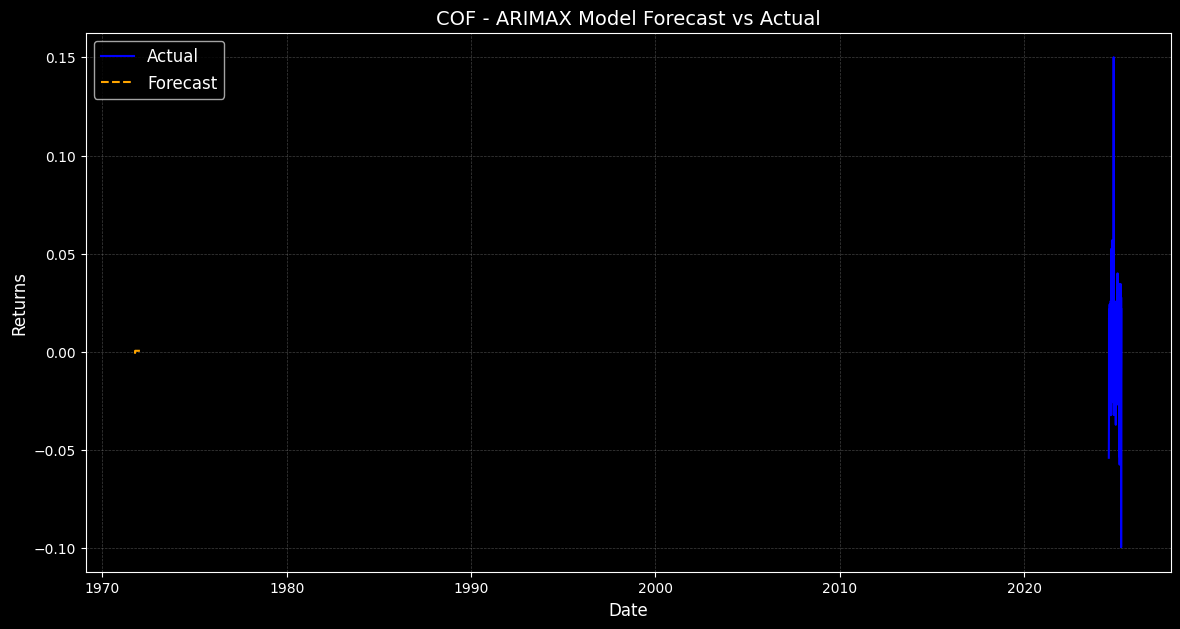


=== ARIMAX Results for COF ===
MAE: 0.0174, MSE: 0.0006, RMSE: 0.0252, AIC: -3075.8202


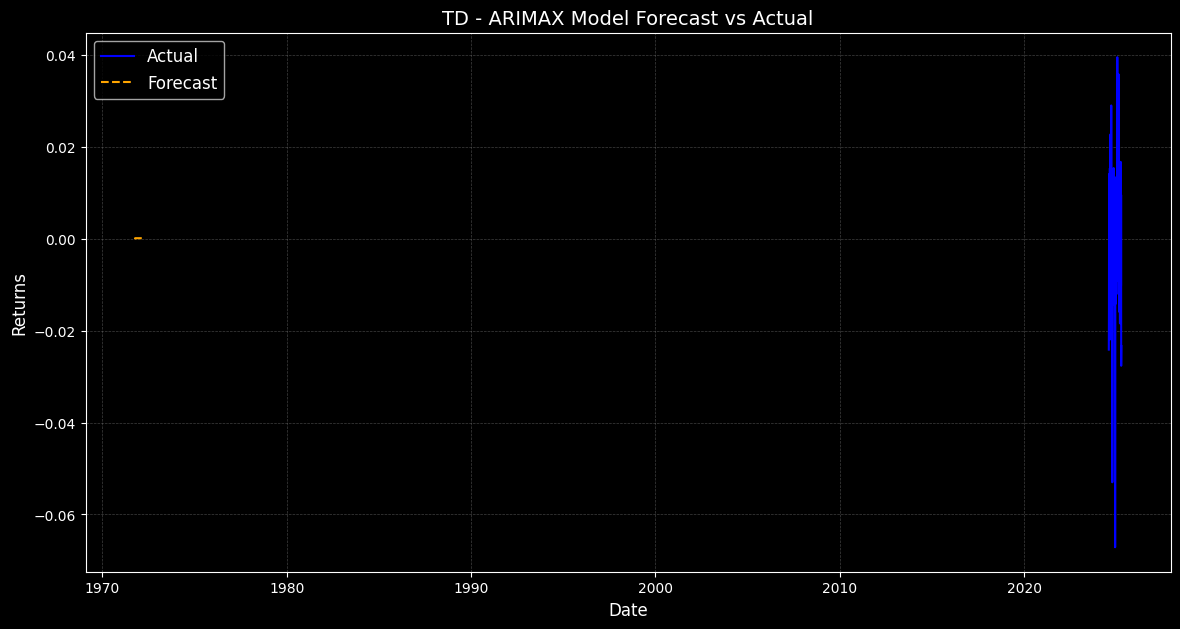


=== ARIMAX Results for TD ===
MAE: 0.0083, MSE: 0.0002, RMSE: 0.0125, AIC: -3702.5077


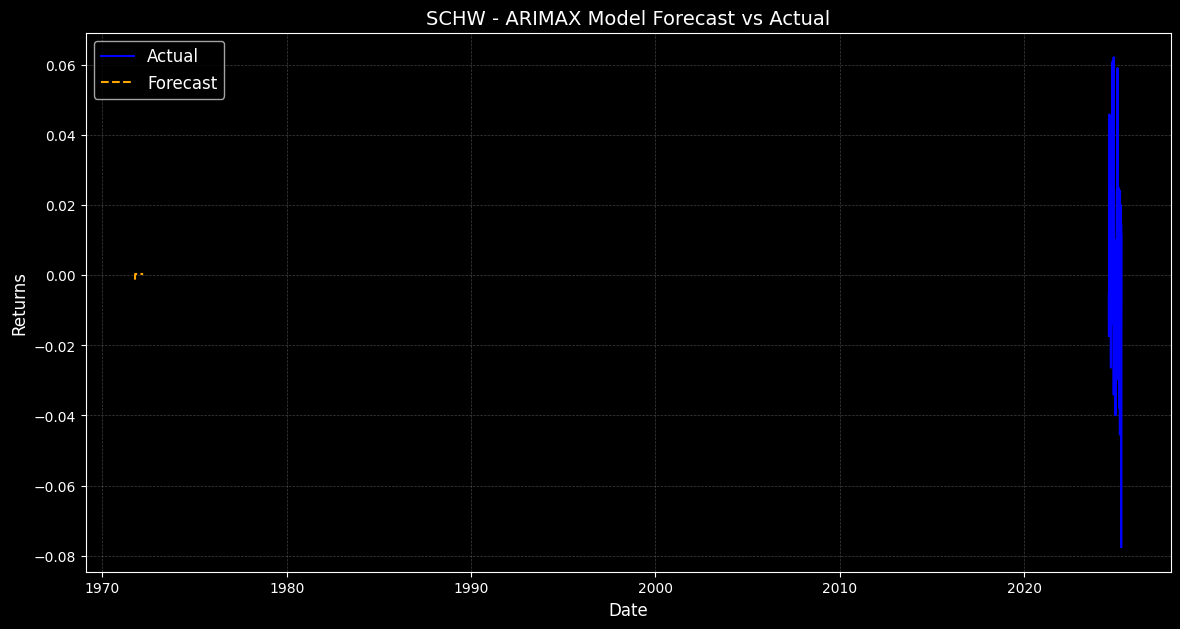


=== ARIMAX Results for SCHW ===
MAE: 0.0119, MSE: 0.0003, RMSE: 0.0177, AIC: -3024.5799


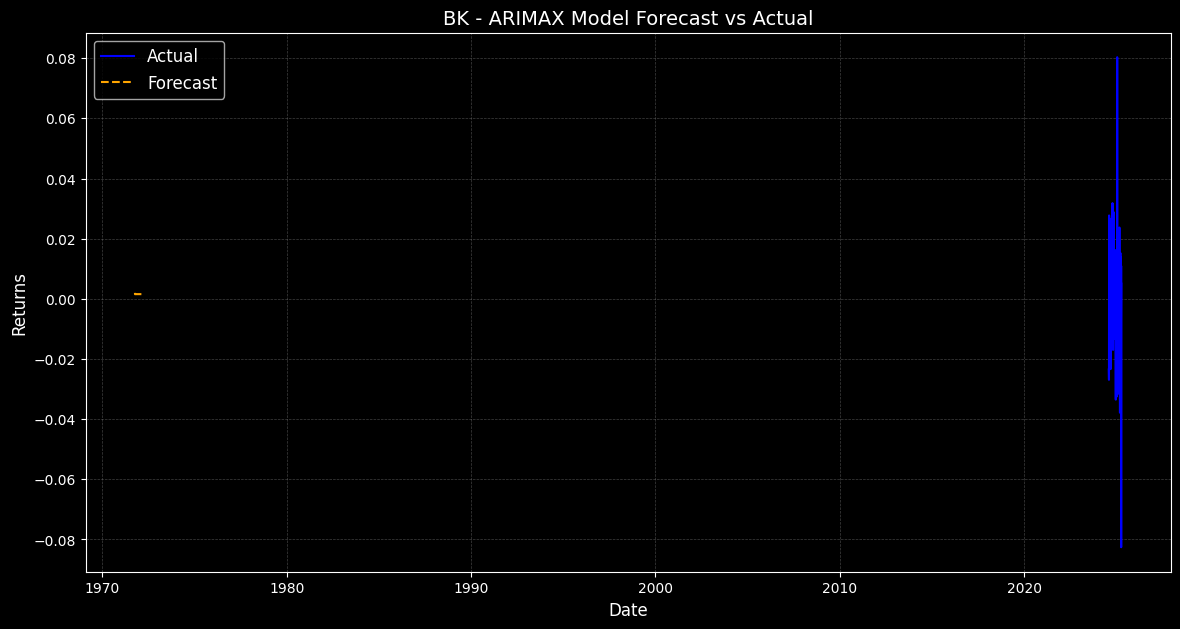


=== ARIMAX Results for BK ===
MAE: 0.0103, MSE: 0.0002, RMSE: 0.0154, AIC: -3448.2243


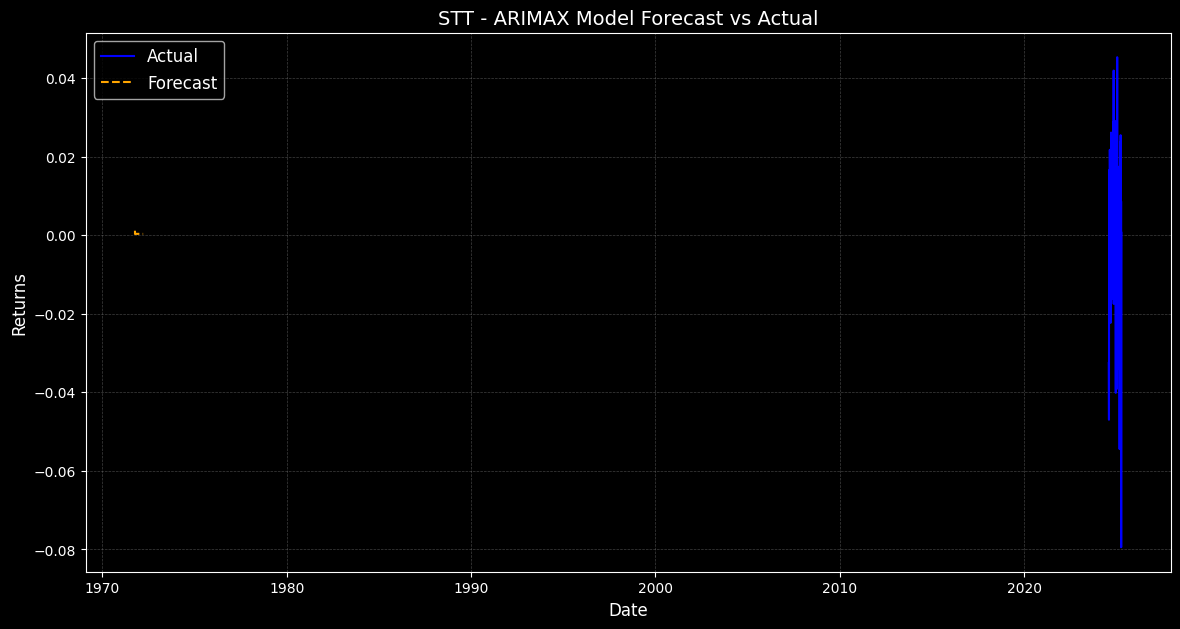


=== ARIMAX Results for STT ===
MAE: 0.0113, MSE: 0.0003, RMSE: 0.0170, AIC: -3157.9262


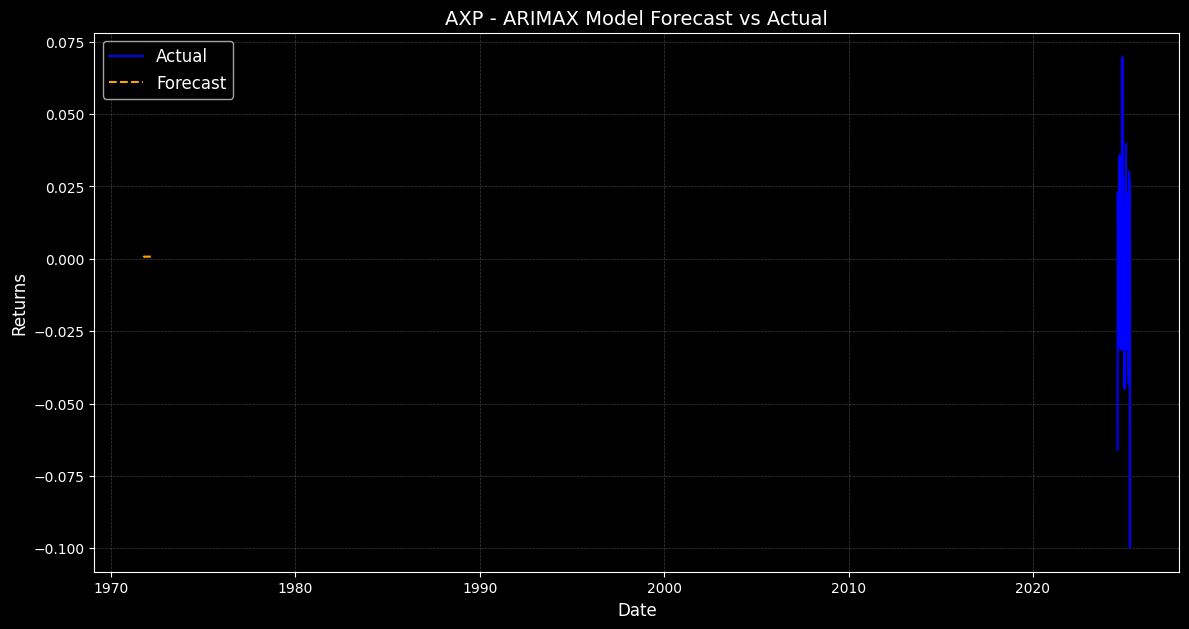


=== ARIMAX Results for AXP ===
MAE: 0.0136, MSE: 0.0004, RMSE: 0.0193, AIC: -3301.1065


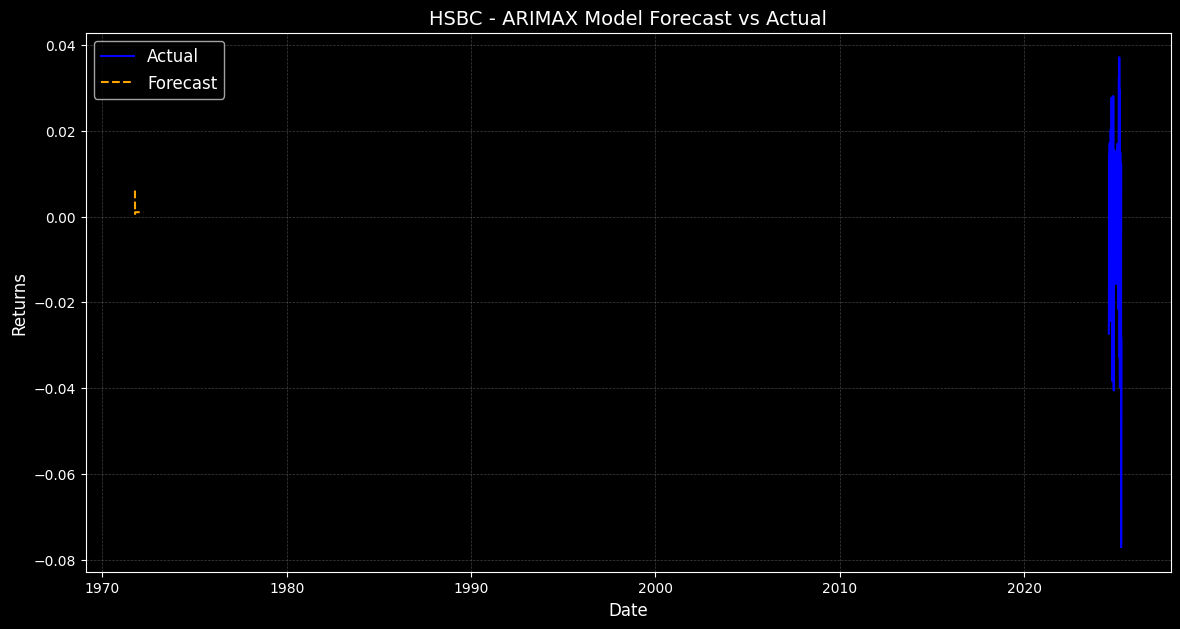


=== ARIMAX Results for HSBC ===
MAE: 0.0102, MSE: 0.0002, RMSE: 0.0152, AIC: -3432.8576


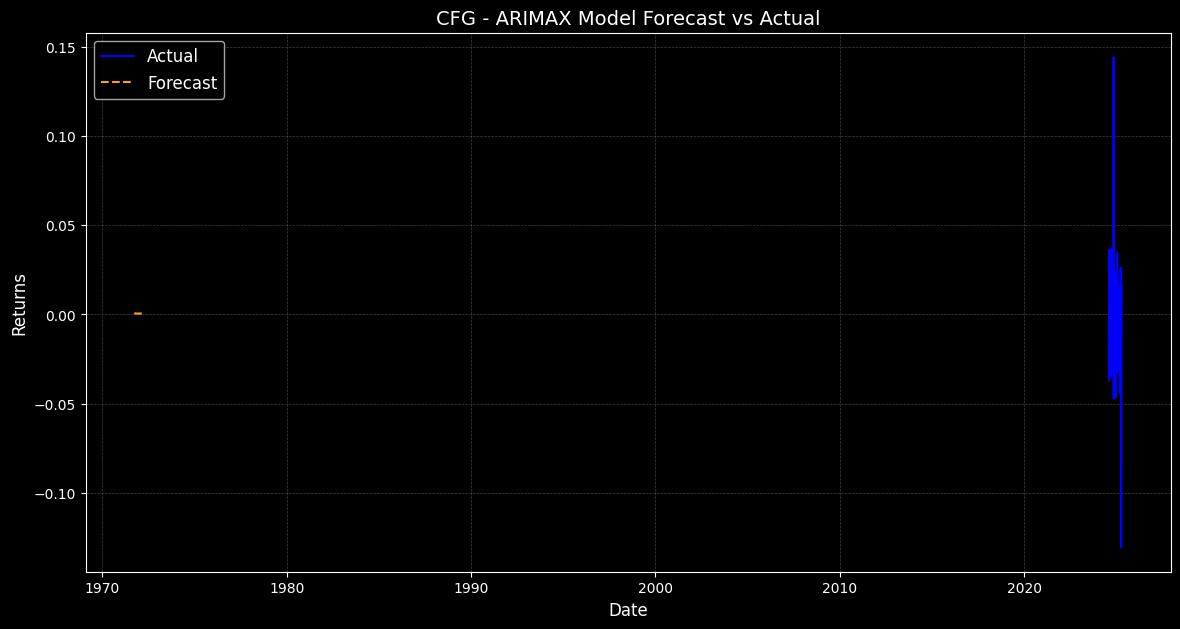


=== ARIMAX Results for CFG ===
MAE: 0.0144, MSE: 0.0005, RMSE: 0.0227, AIC: -3047.3546


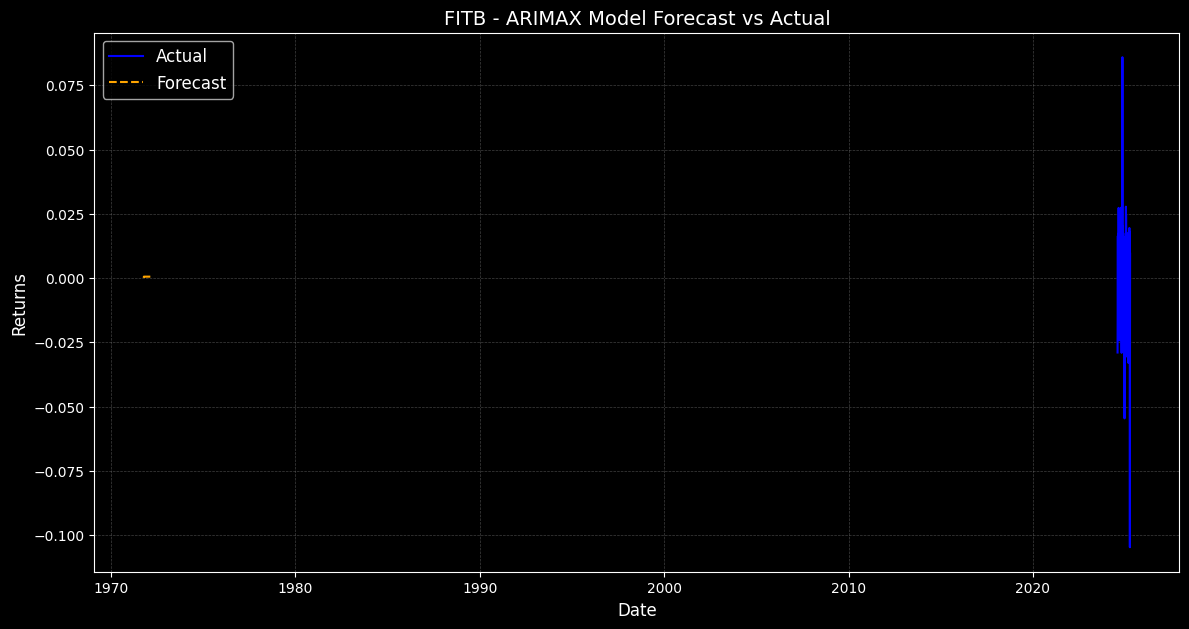


=== ARIMAX Results for FITB ===
MAE: 0.0119, MSE: 0.0003, RMSE: 0.0177, AIC: -3077.0925


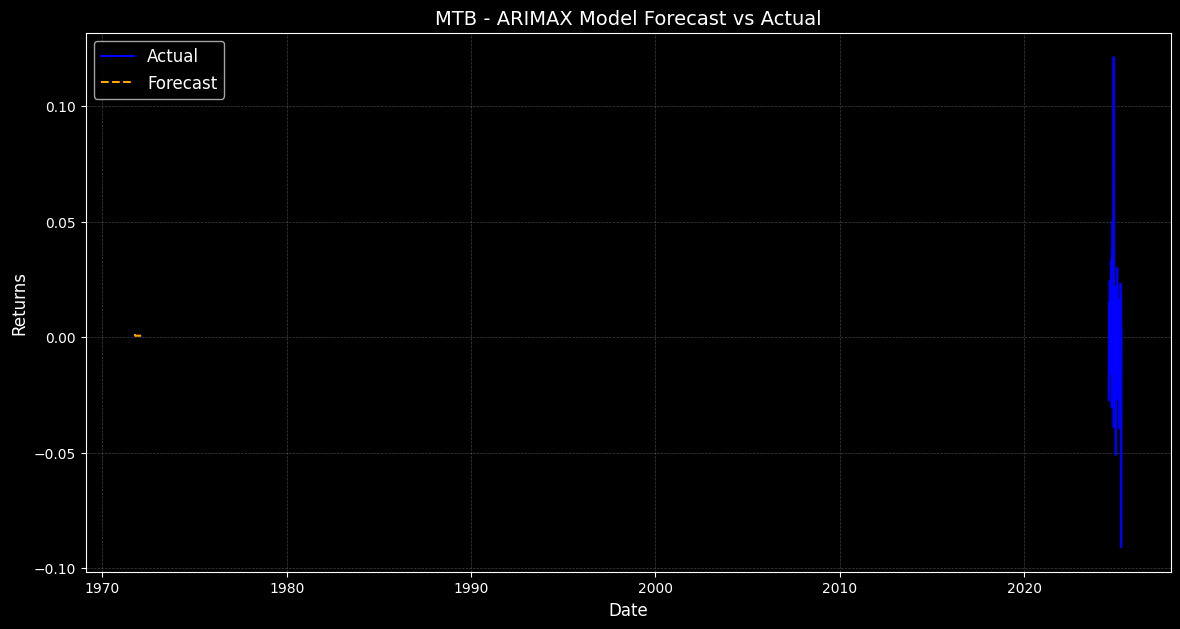


=== ARIMAX Results for MTB ===
MAE: 0.0125, MSE: 0.0004, RMSE: 0.0191, AIC: -3162.9536


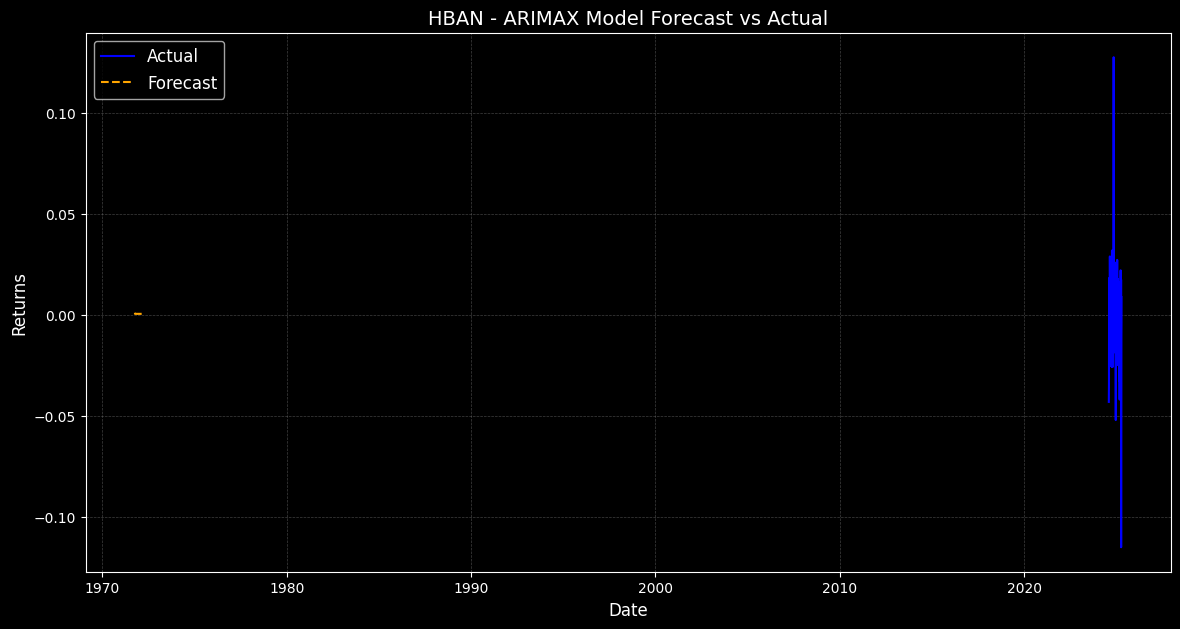


=== ARIMAX Results for HBAN ===
MAE: 0.0129, MSE: 0.0004, RMSE: 0.0204, AIC: -3151.9501


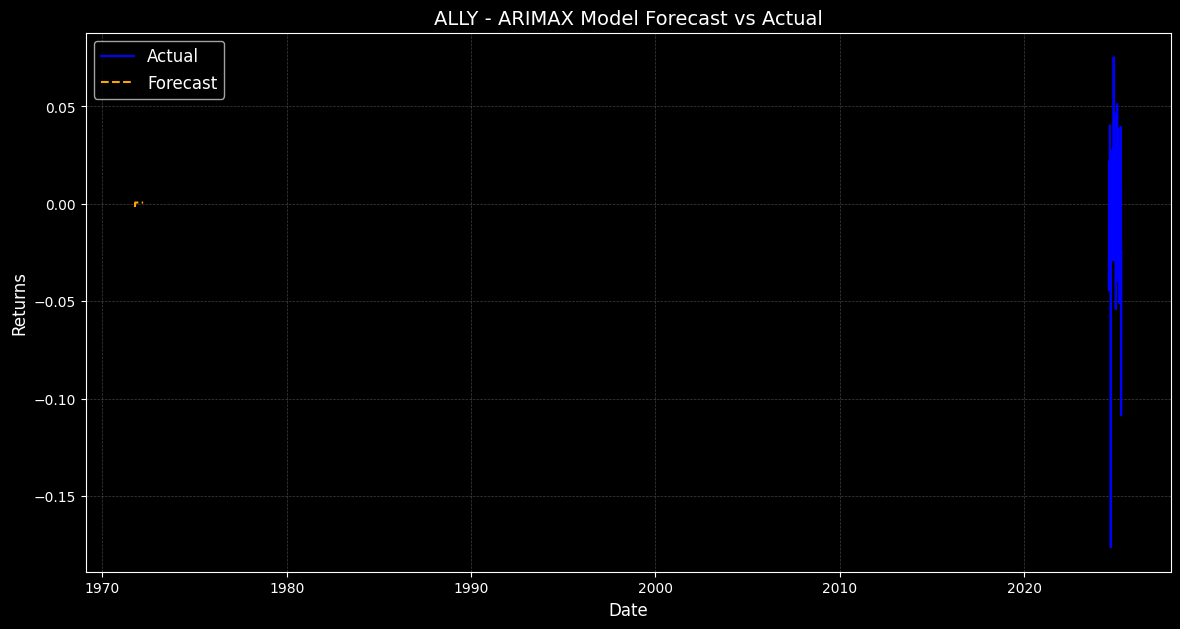


=== ARIMAX Results for ALLY ===
MAE: 0.0157, MSE: 0.0006, RMSE: 0.0249, AIC: -2839.6418


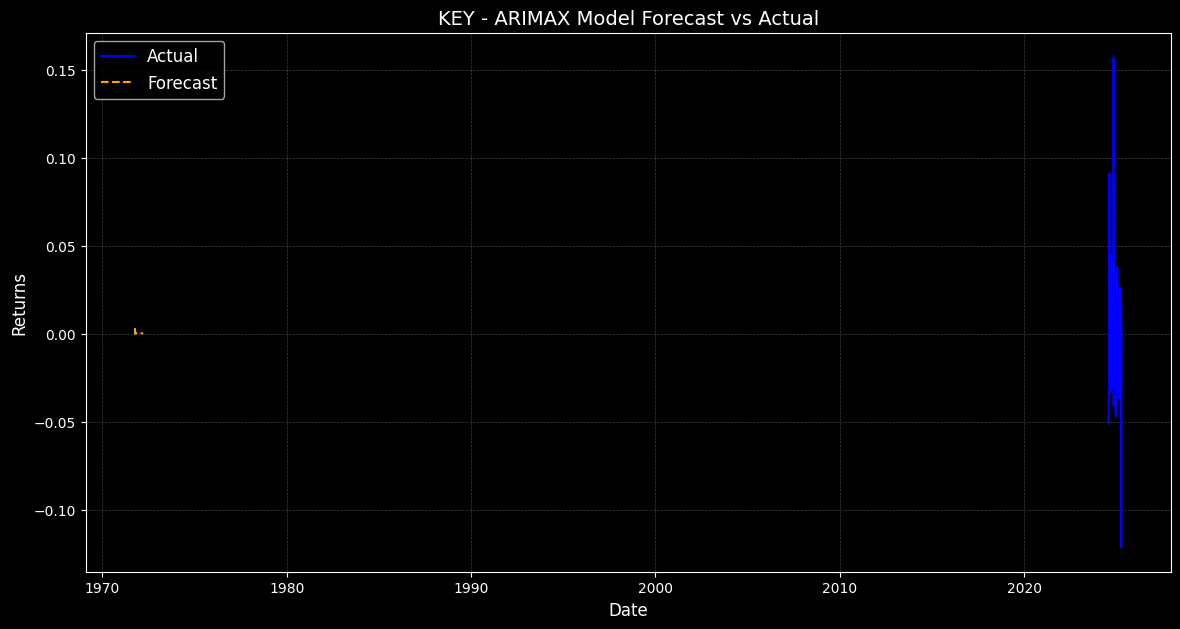


=== ARIMAX Results for KEY ===
MAE: 0.0152, MSE: 0.0006, RMSE: 0.0241, AIC: -2808.1544


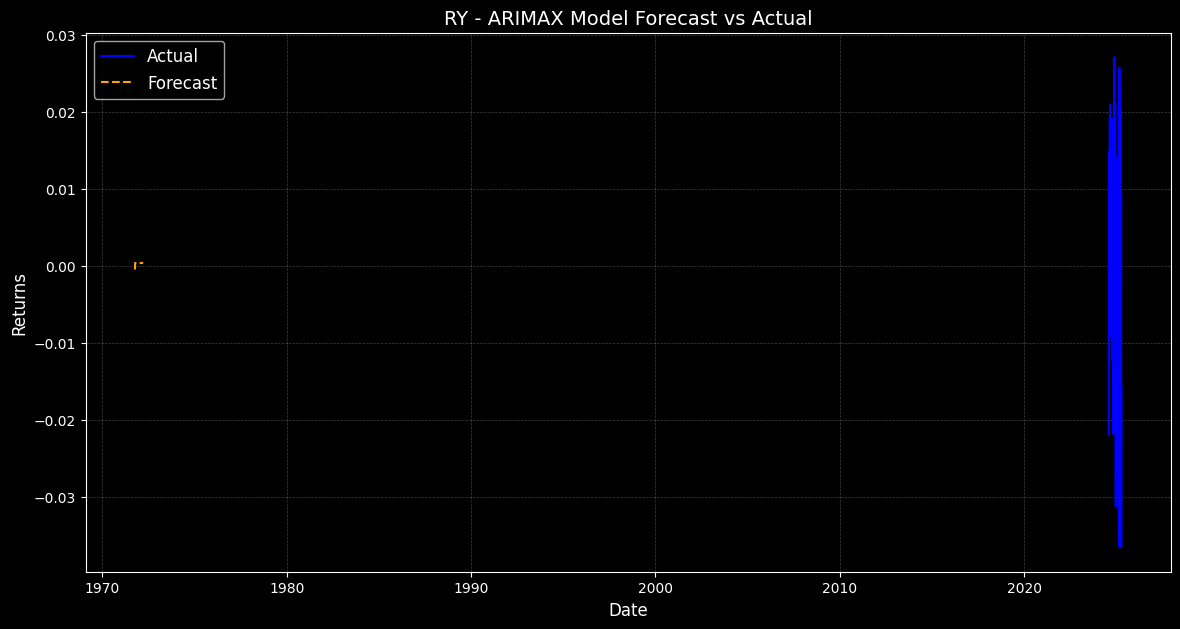


=== ARIMAX Results for RY ===
MAE: 0.0082, MSE: 0.0001, RMSE: 0.0112, AIC: -3838.7807


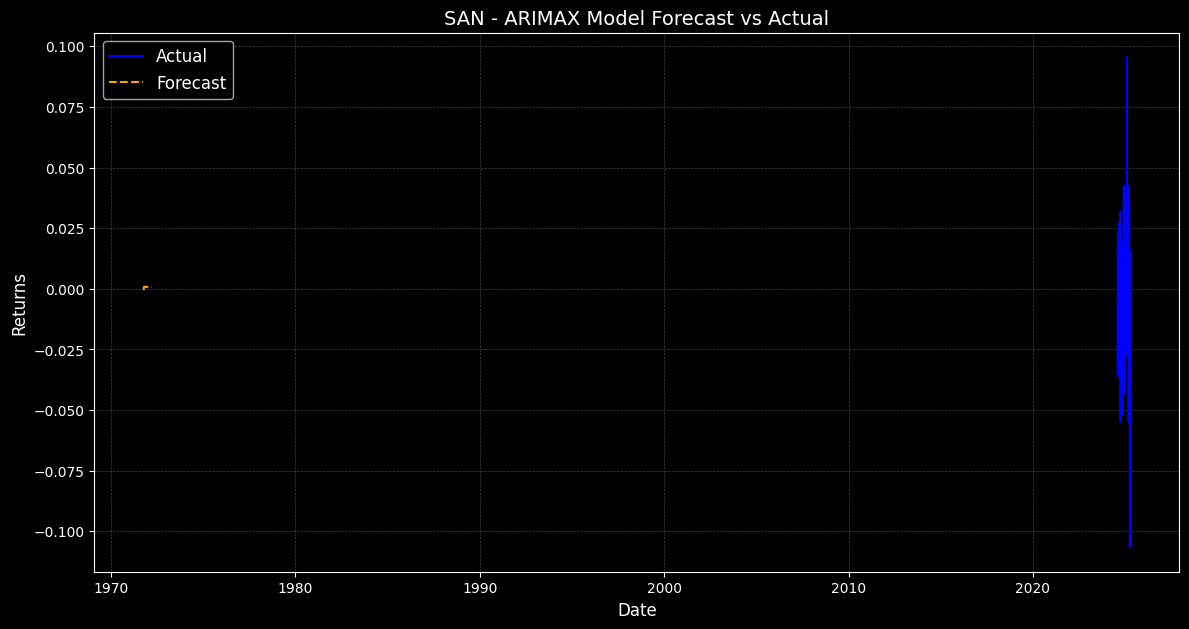


=== ARIMAX Results for SAN ===
MAE: 0.0149, MSE: 0.0005, RMSE: 0.0213, AIC: -3095.6054


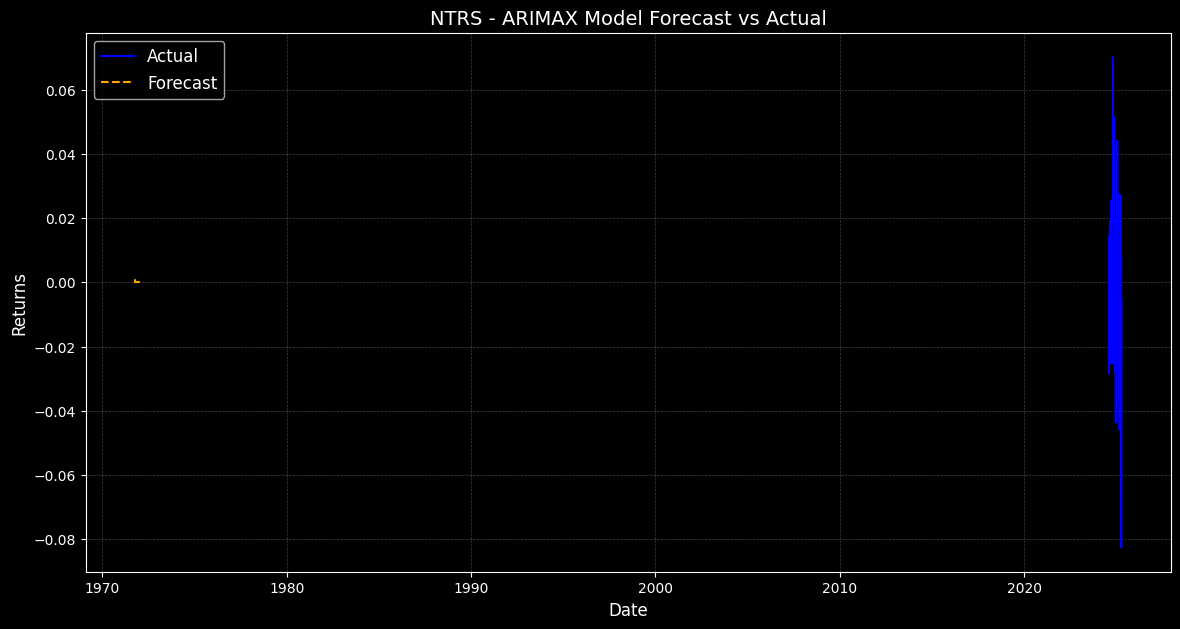


=== ARIMAX Results for NTRS ===
MAE: 0.0111, MSE: 0.0003, RMSE: 0.0167, AIC: -3216.6754


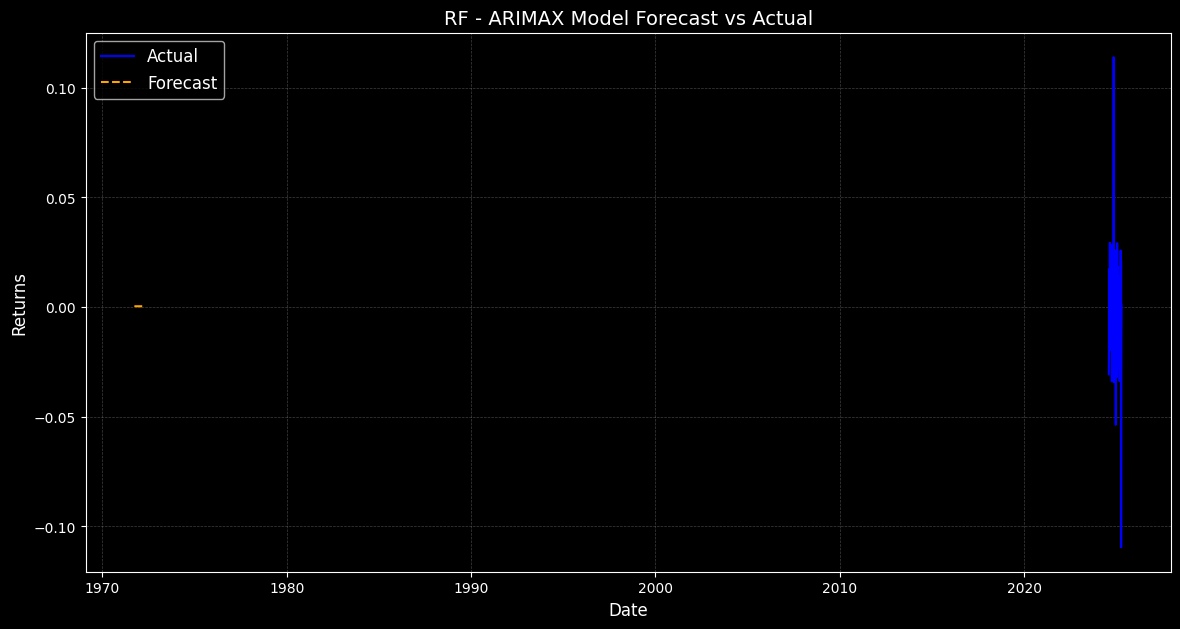


=== ARIMAX Results for RF ===
MAE: 0.0124, MSE: 0.0004, RMSE: 0.0191, AIC: -3125.2523


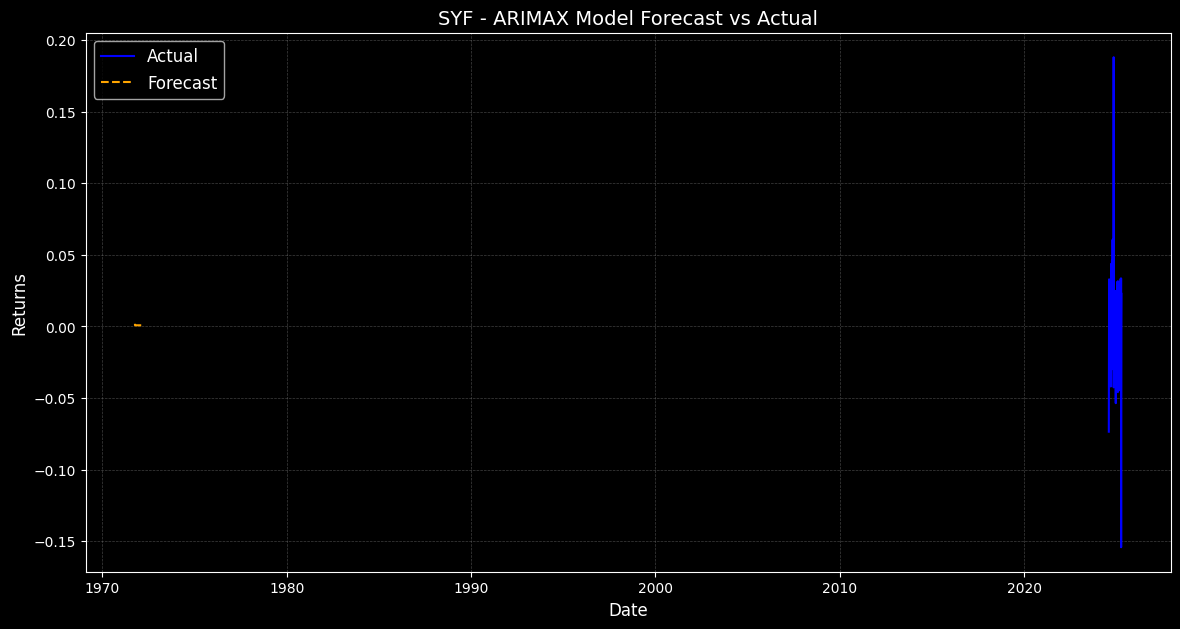


=== ARIMAX Results for SYF ===
MAE: 0.0176, MSE: 0.0008, RMSE: 0.0282, AIC: -3007.0783


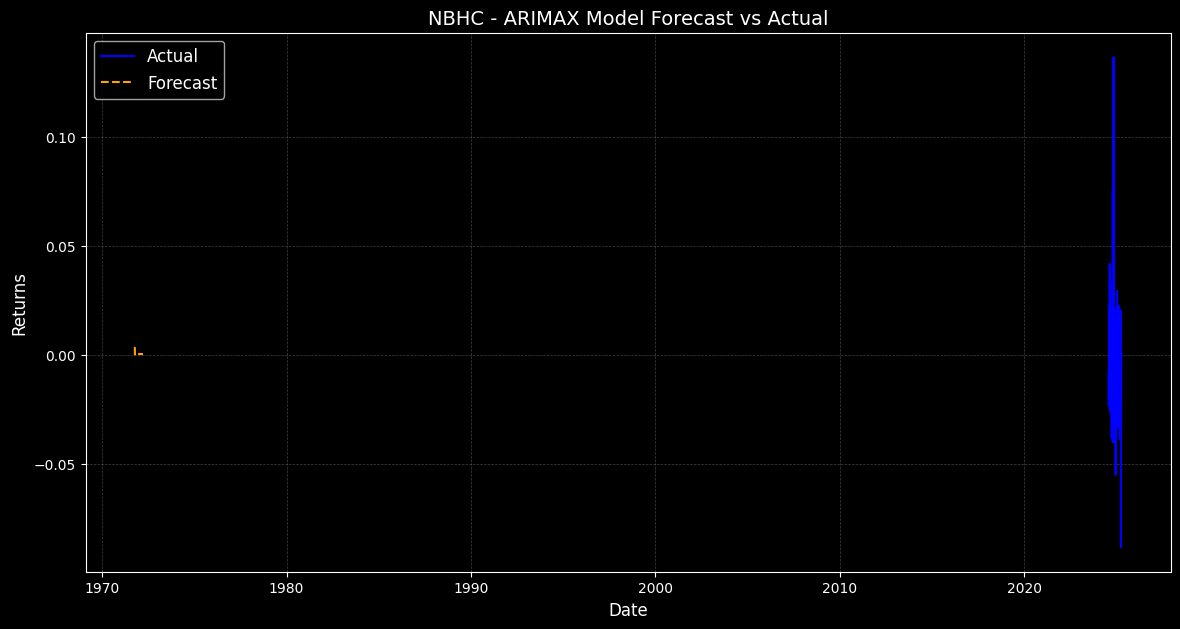


=== ARIMAX Results for NBHC ===
MAE: 0.0135, MSE: 0.0004, RMSE: 0.0208, AIC: -3173.0996


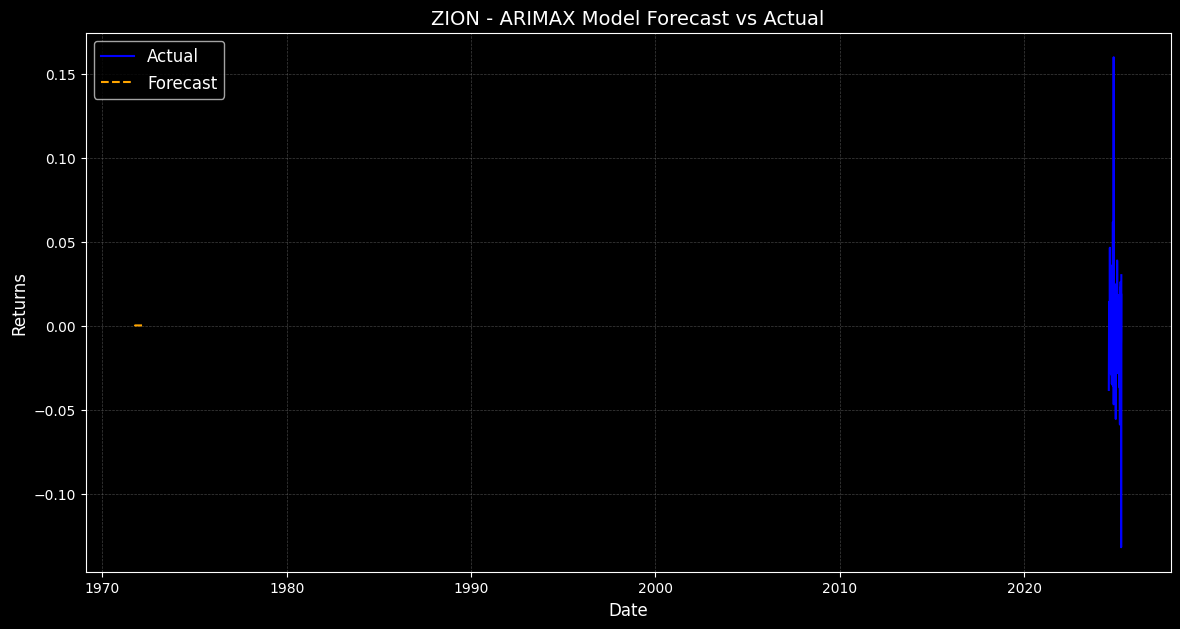


=== ARIMAX Results for ZION ===
MAE: 0.0160, MSE: 0.0006, RMSE: 0.0248, AIC: -2650.3082


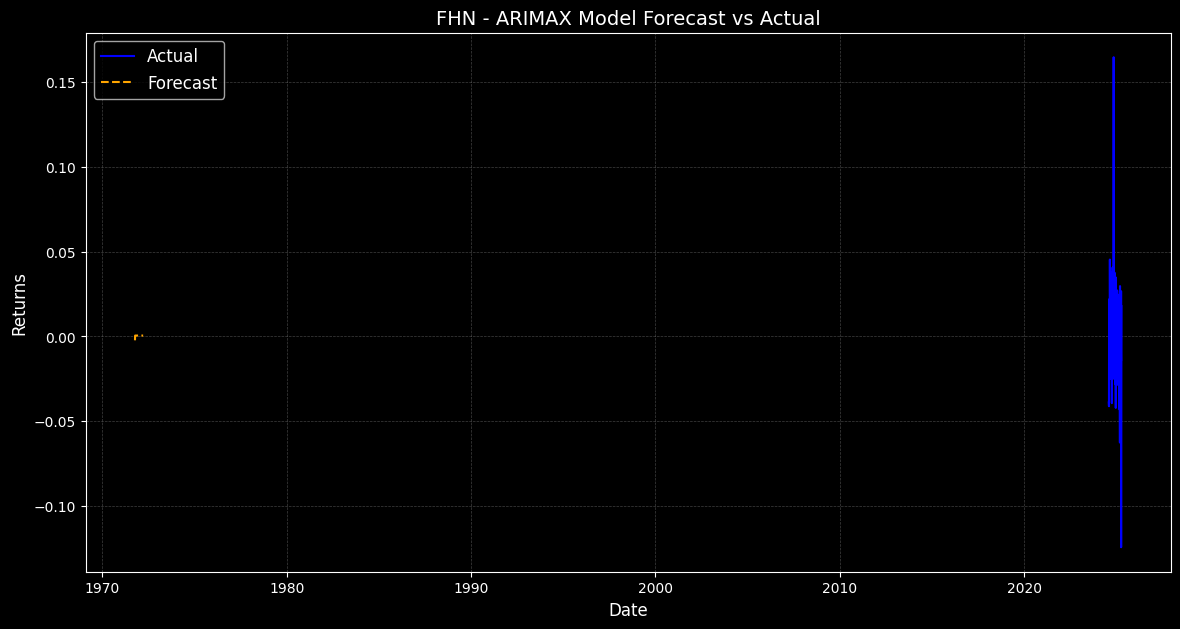


=== ARIMAX Results for FHN ===
MAE: 0.0157, MSE: 0.0006, RMSE: 0.0244, AIC: -2851.5969


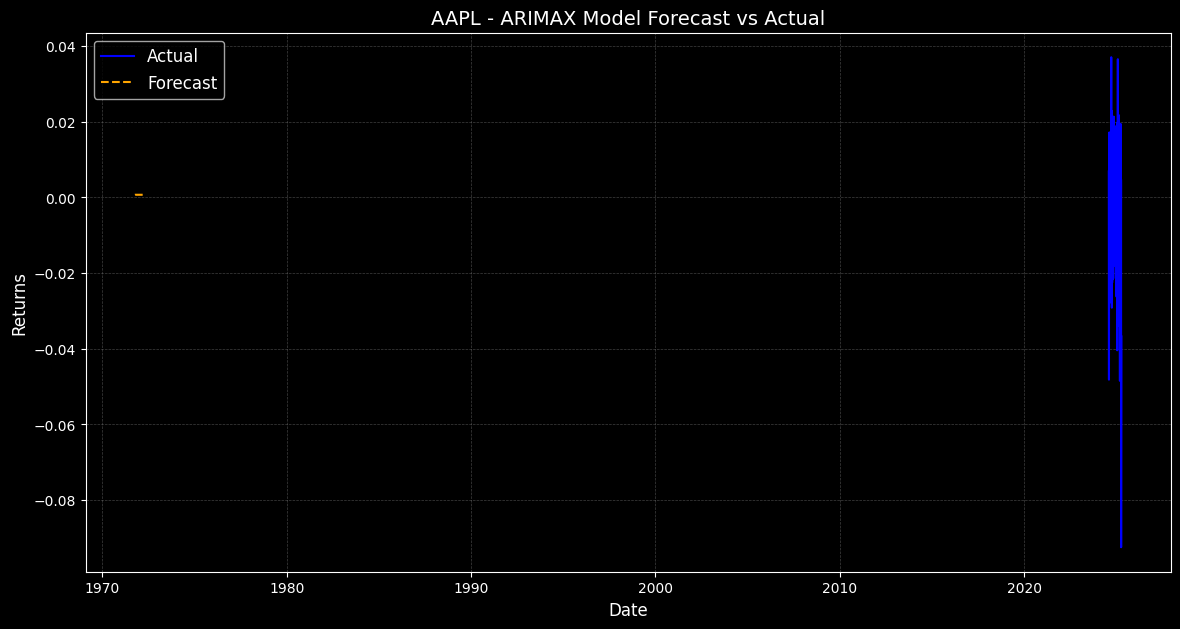


=== ARIMAX Results for AAPL ===
MAE: 0.0118, MSE: 0.0003, RMSE: 0.0175, AIC: -3340.8268


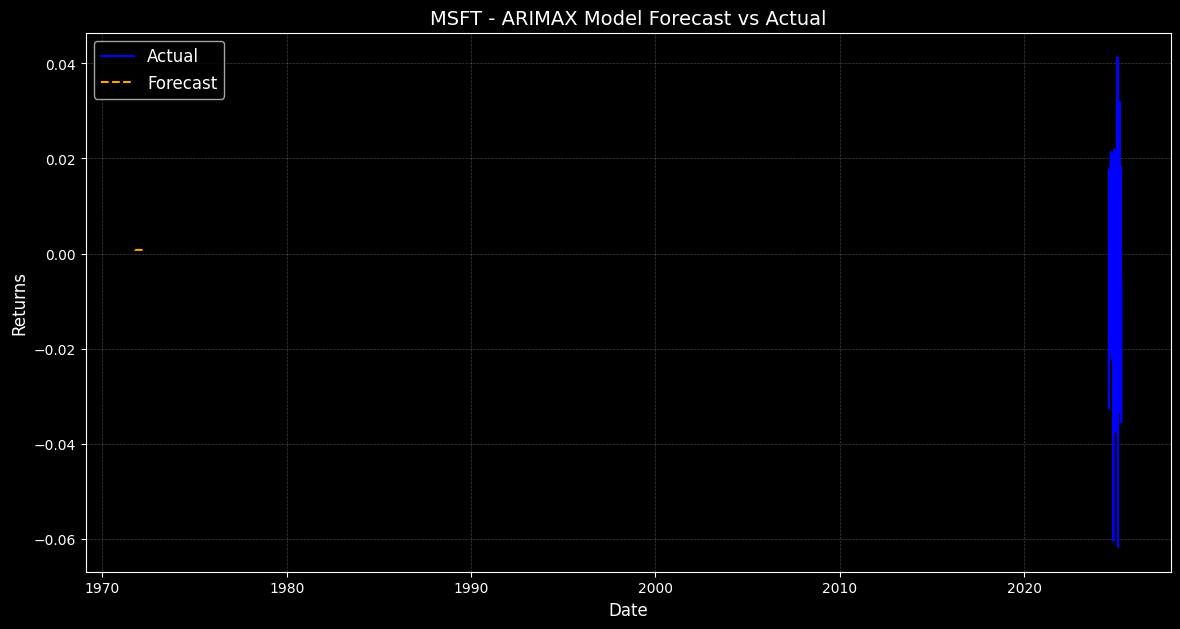


=== ARIMAX Results for MSFT ===
MAE: 0.0102, MSE: 0.0002, RMSE: 0.0143, AIC: -3345.4233


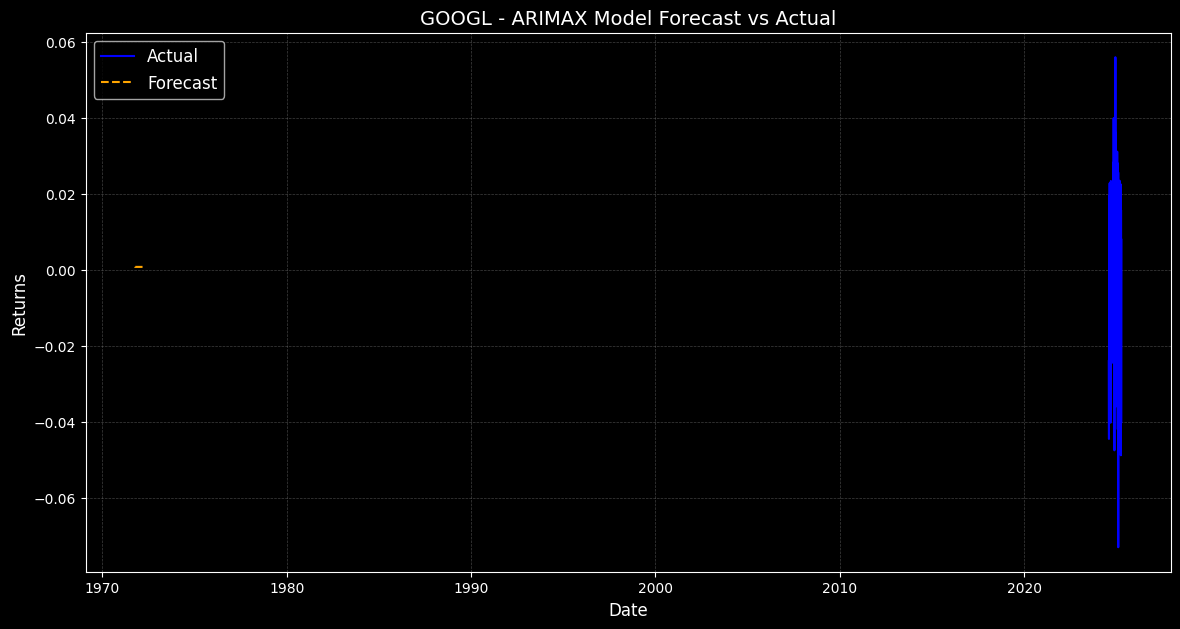


=== ARIMAX Results for GOOGL ===
MAE: 0.0145, MSE: 0.0004, RMSE: 0.0192, AIC: -3146.3994


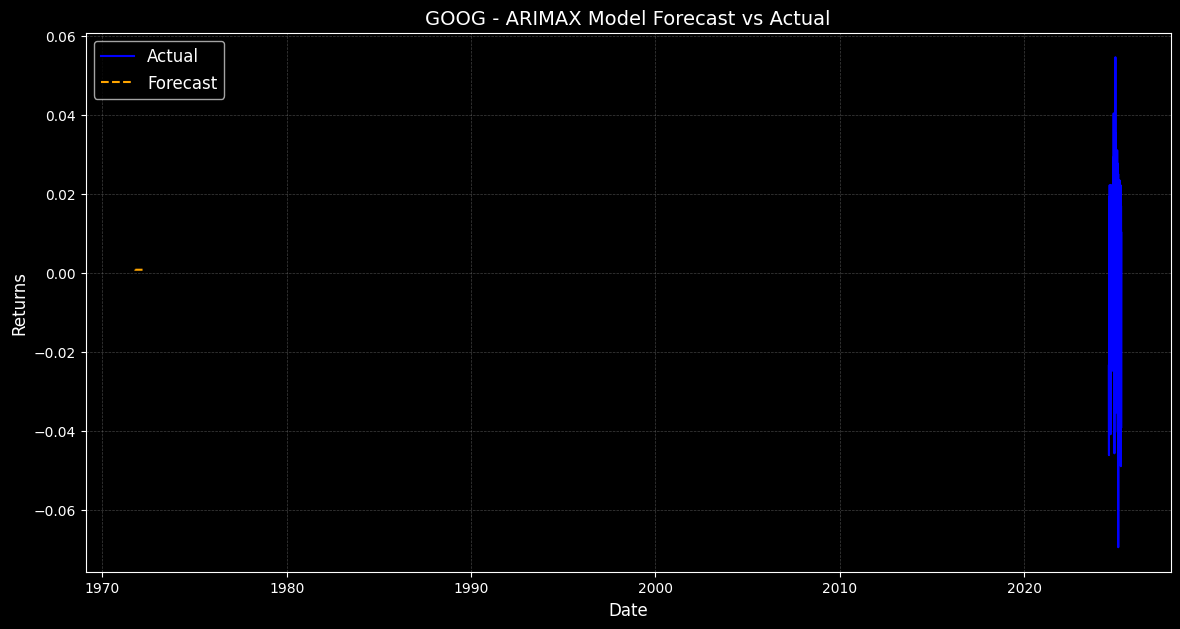


=== ARIMAX Results for GOOG ===
MAE: 0.0144, MSE: 0.0004, RMSE: 0.0190, AIC: -3147.1732


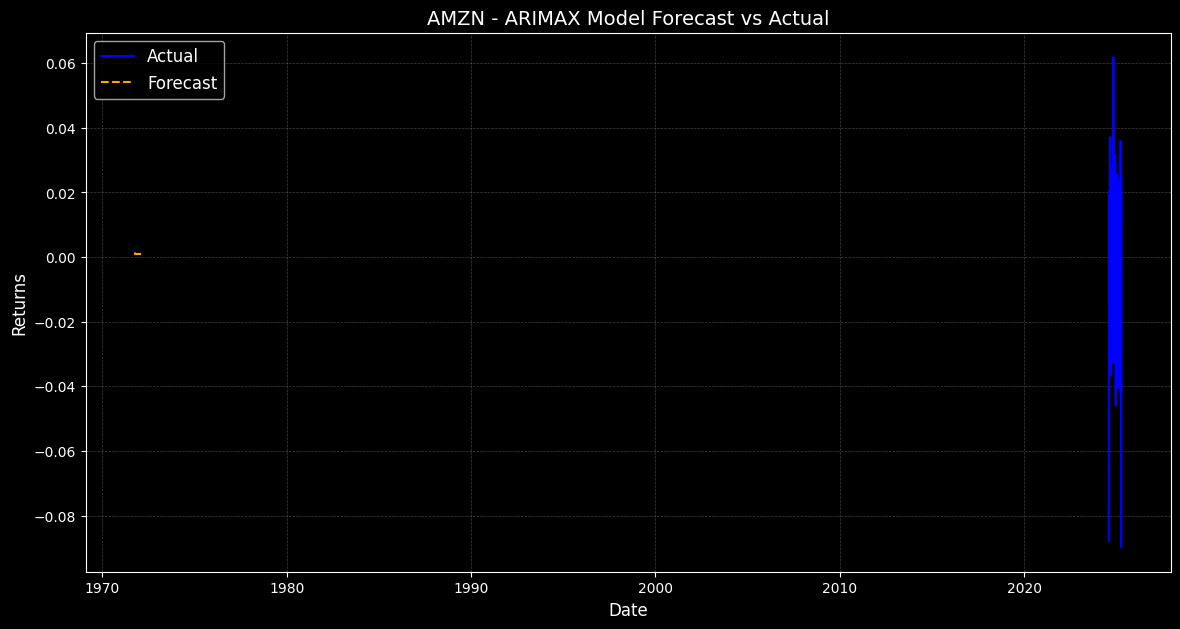


=== ARIMAX Results for AMZN ===
MAE: 0.0152, MSE: 0.0004, RMSE: 0.0205, AIC: -2927.1330


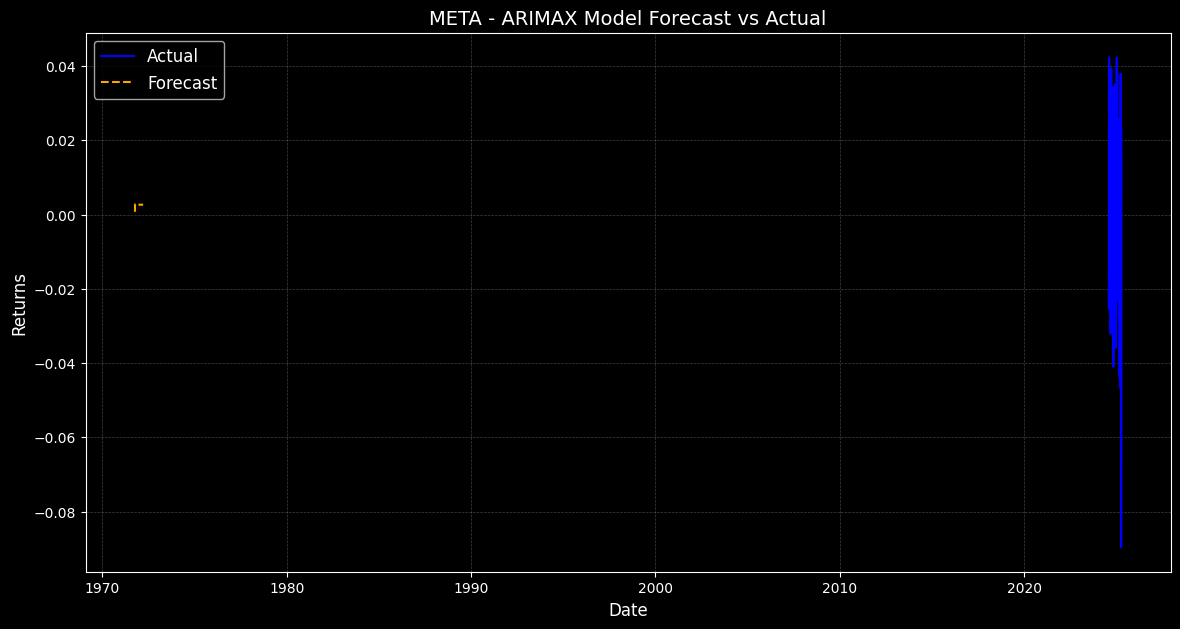


=== ARIMAX Results for META ===
MAE: 0.0146, MSE: 0.0004, RMSE: 0.0197, AIC: -2581.2136


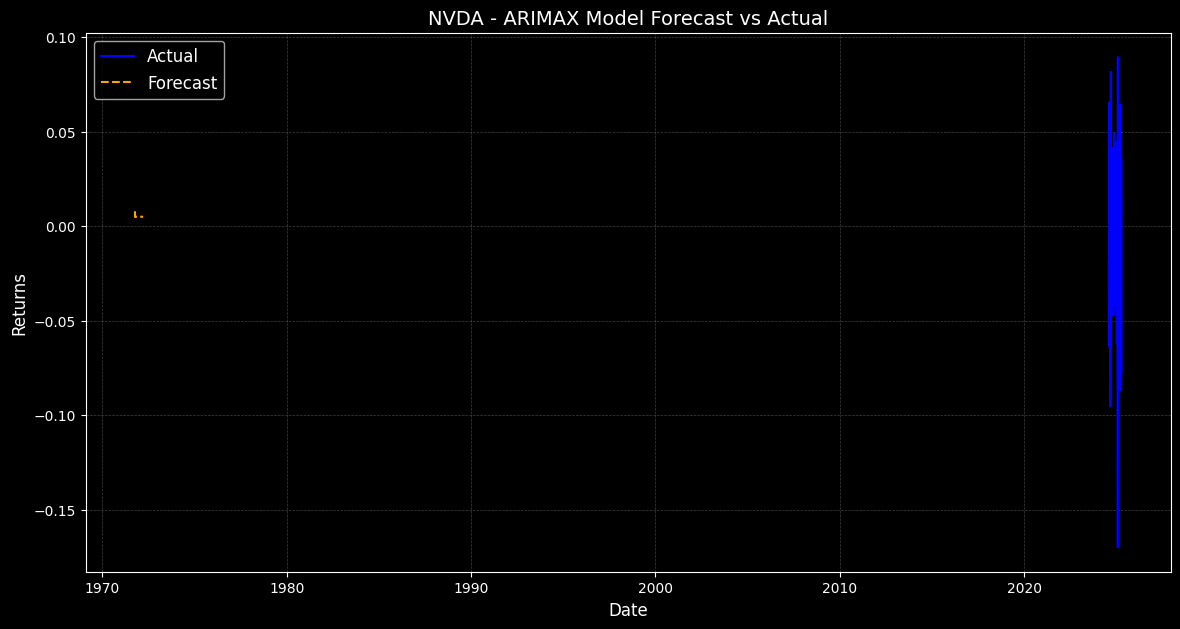


=== ARIMAX Results for NVDA ===
MAE: 0.0265, MSE: 0.0013, RMSE: 0.0356, AIC: -2443.1071


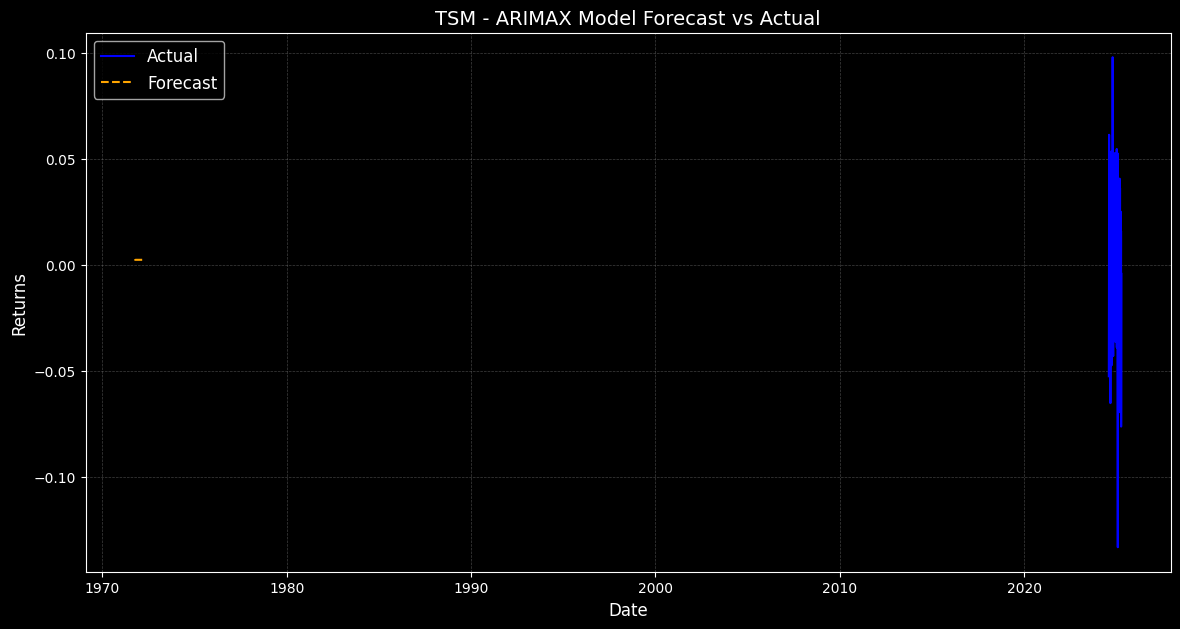


=== ARIMAX Results for TSM ===
MAE: 0.0214, MSE: 0.0008, RMSE: 0.0291, AIC: -3008.4382


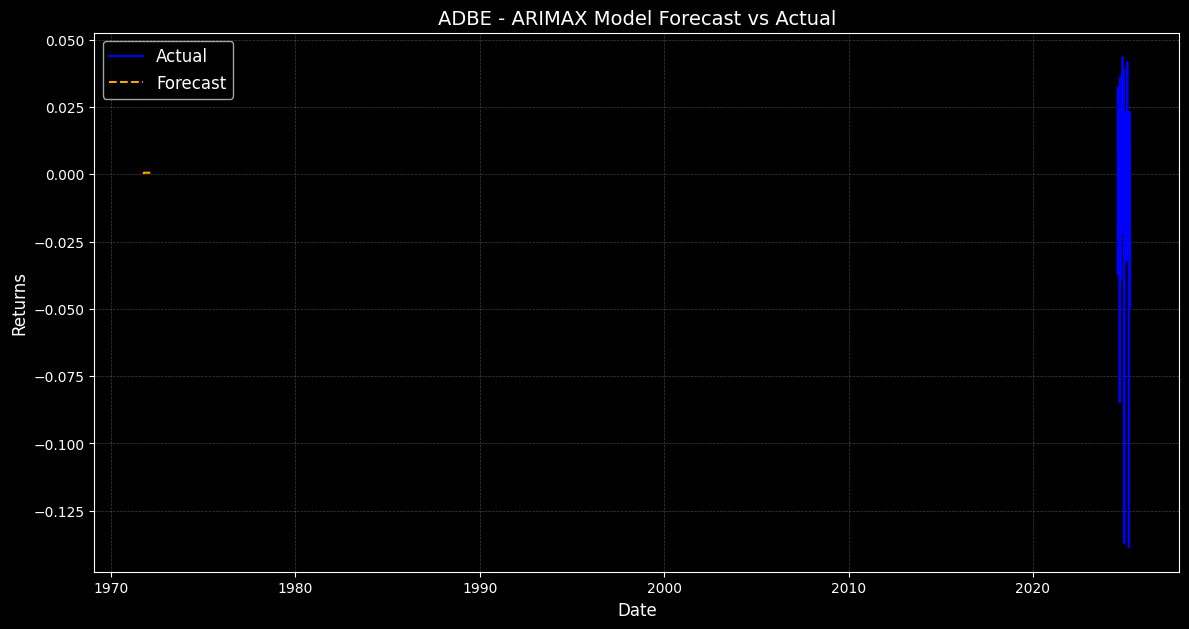


=== ARIMAX Results for ADBE ===
MAE: 0.0141, MSE: 0.0005, RMSE: 0.0231, AIC: -2902.0743


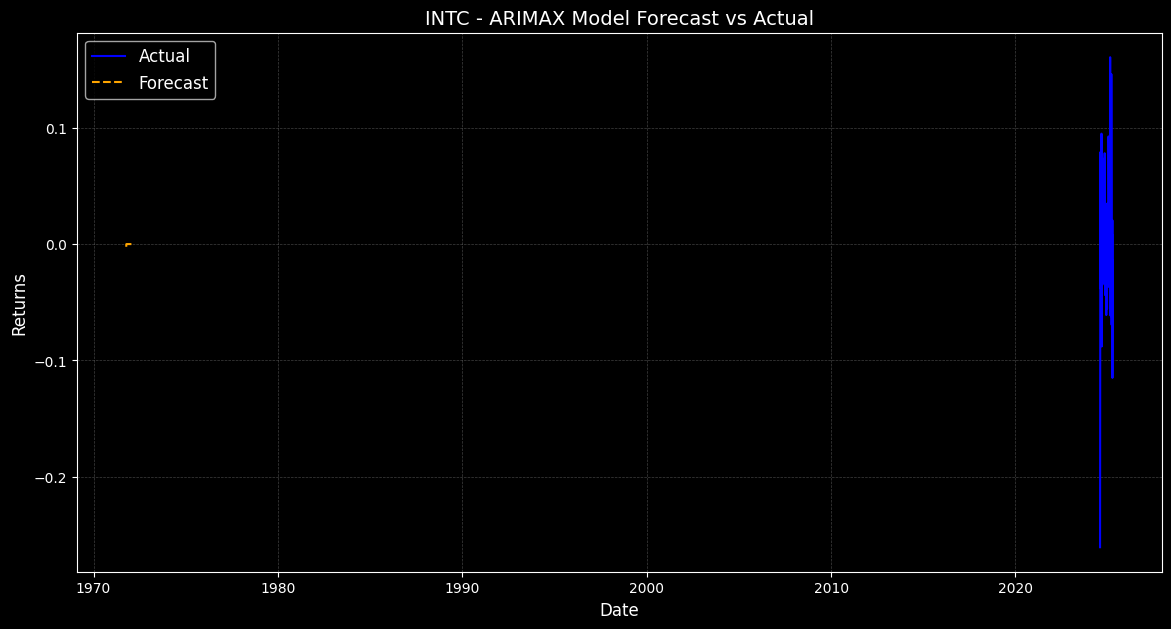


=== ARIMAX Results for INTC ===
MAE: 0.0288, MSE: 0.0018, RMSE: 0.0428, AIC: -2976.8076


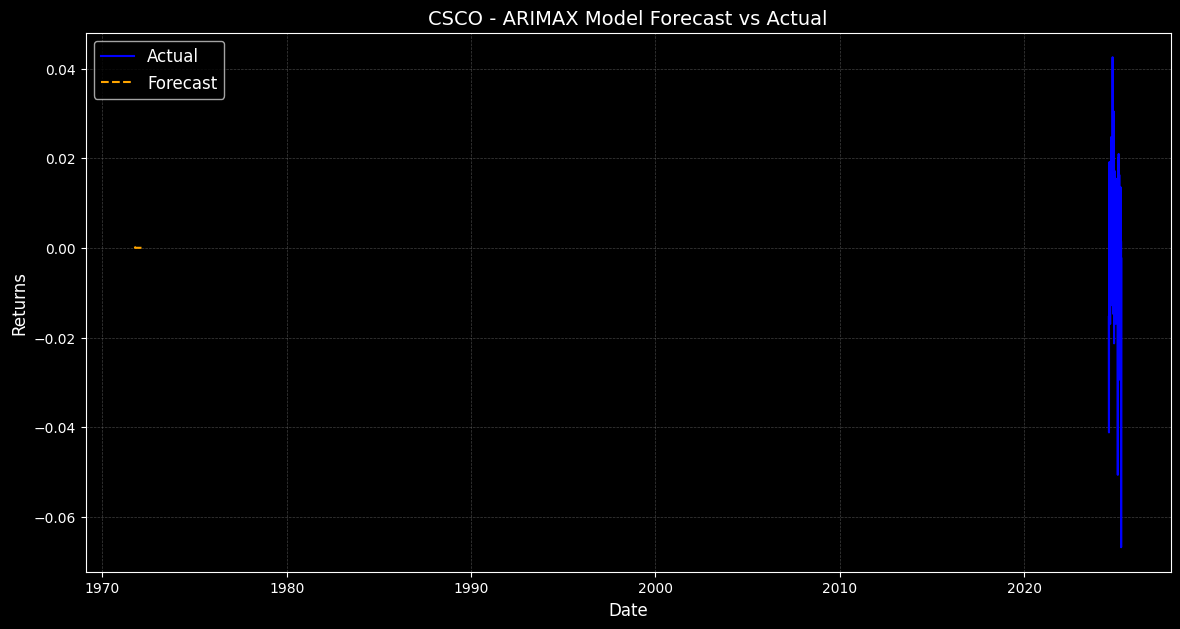


=== ARIMAX Results for CSCO ===
MAE: 0.0087, MSE: 0.0002, RMSE: 0.0129, AIC: -3558.8849


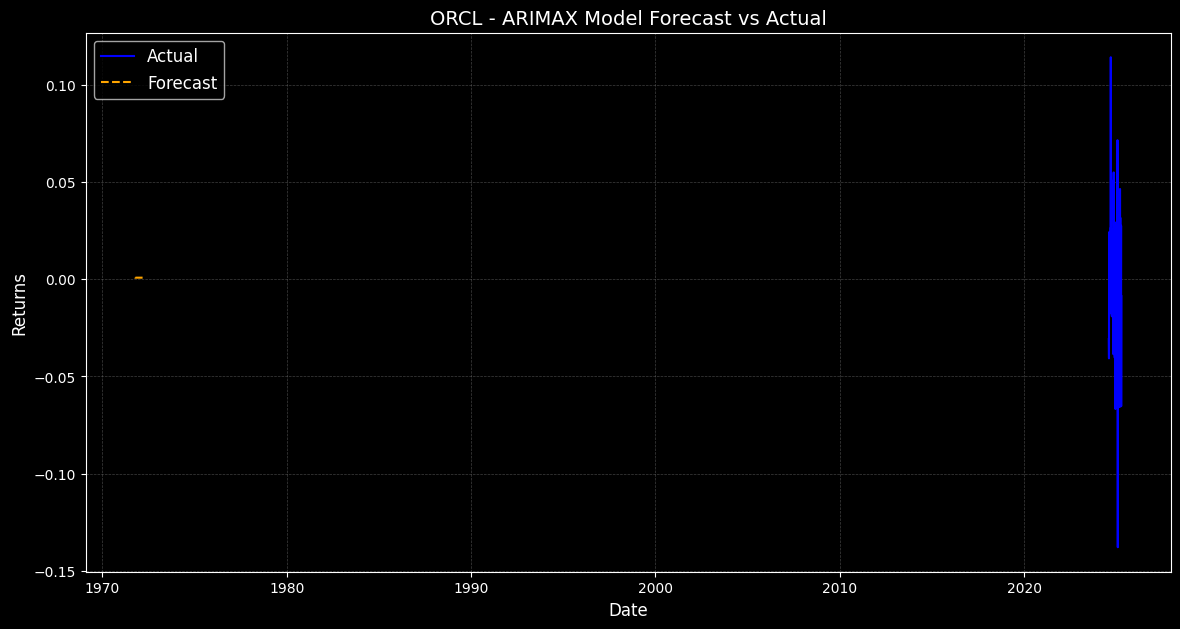


=== ARIMAX Results for ORCL ===
MAE: 0.0183, MSE: 0.0007, RMSE: 0.0269, AIC: -3163.4652


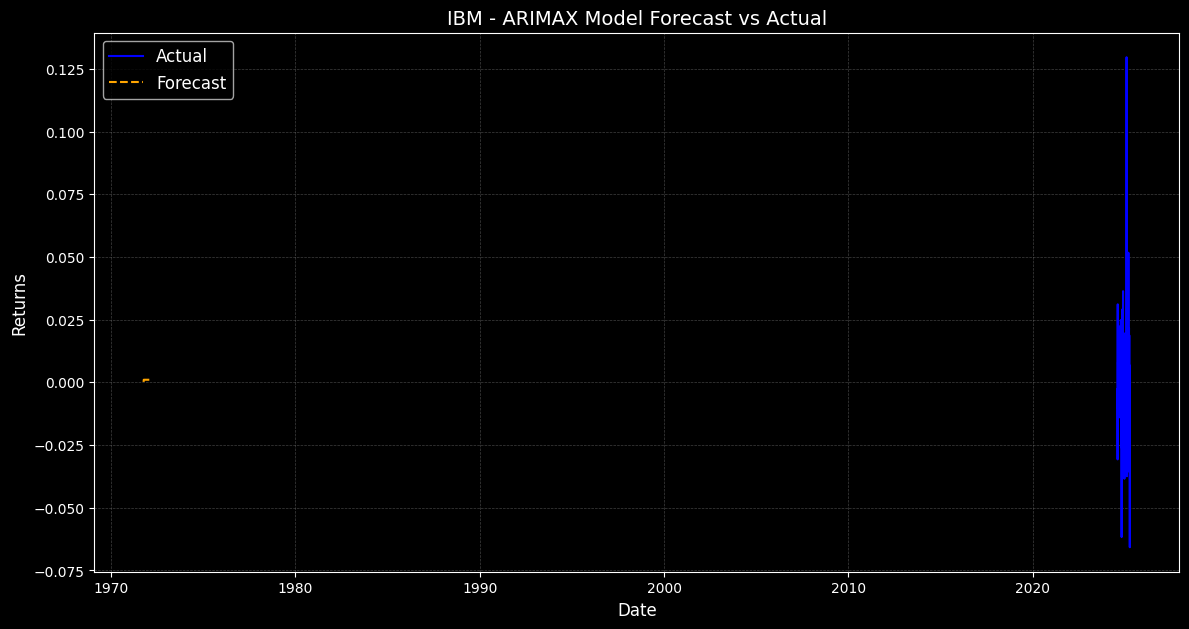


=== ARIMAX Results for IBM ===
MAE: 0.0114, MSE: 0.0003, RMSE: 0.0182, AIC: -3730.5932


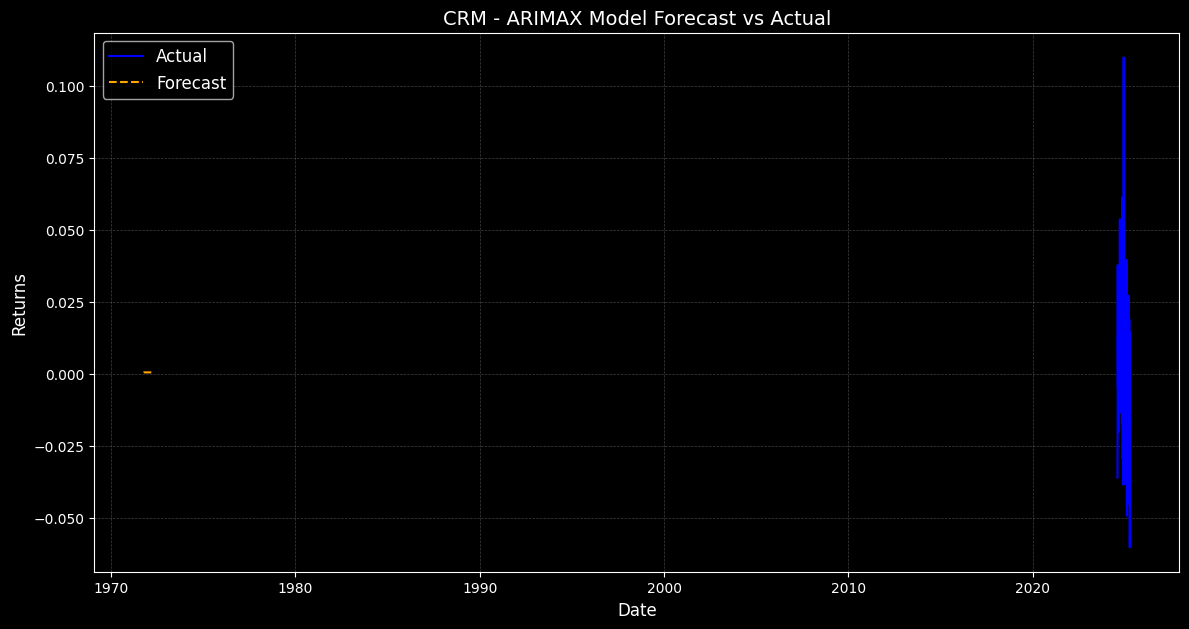


=== ARIMAX Results for CRM ===
MAE: 0.0146, MSE: 0.0004, RMSE: 0.0205, AIC: -2900.6338


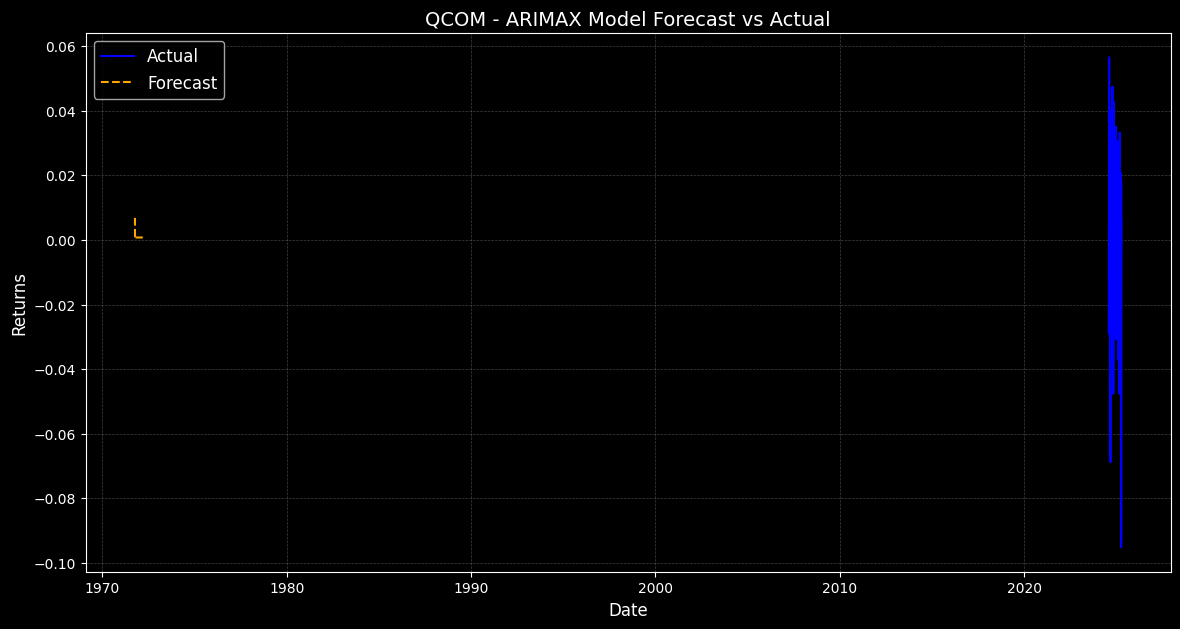


=== ARIMAX Results for QCOM ===
MAE: 0.0164, MSE: 0.0005, RMSE: 0.0222, AIC: -2902.9113


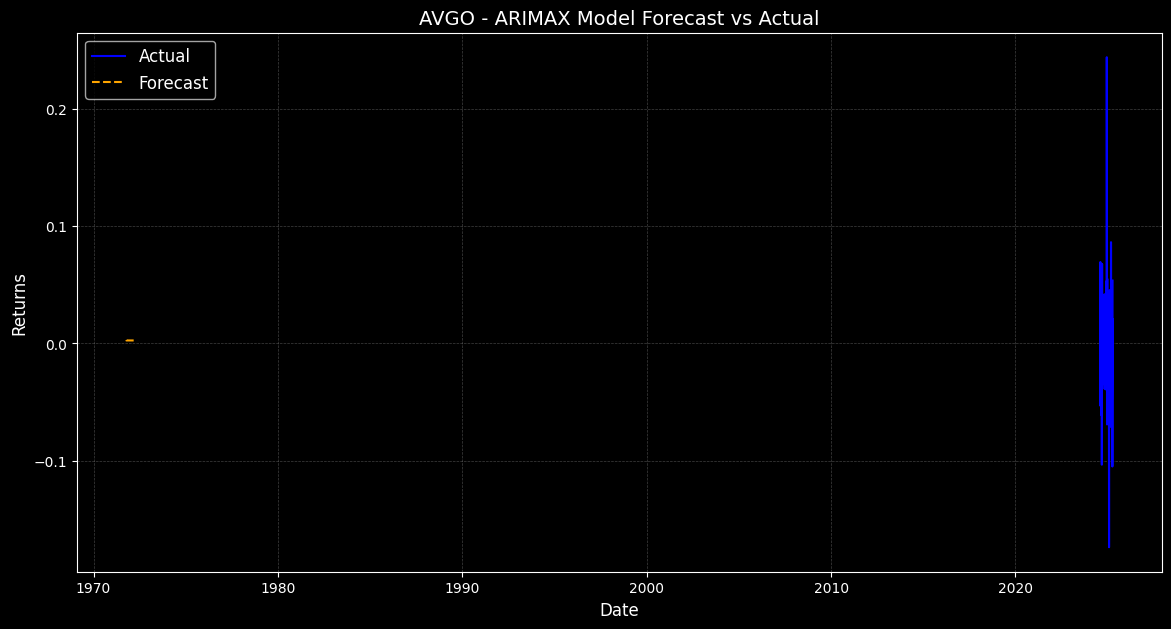


=== ARIMAX Results for AVGO ===
MAE: 0.0258, MSE: 0.0016, RMSE: 0.0395, AIC: -2986.9992


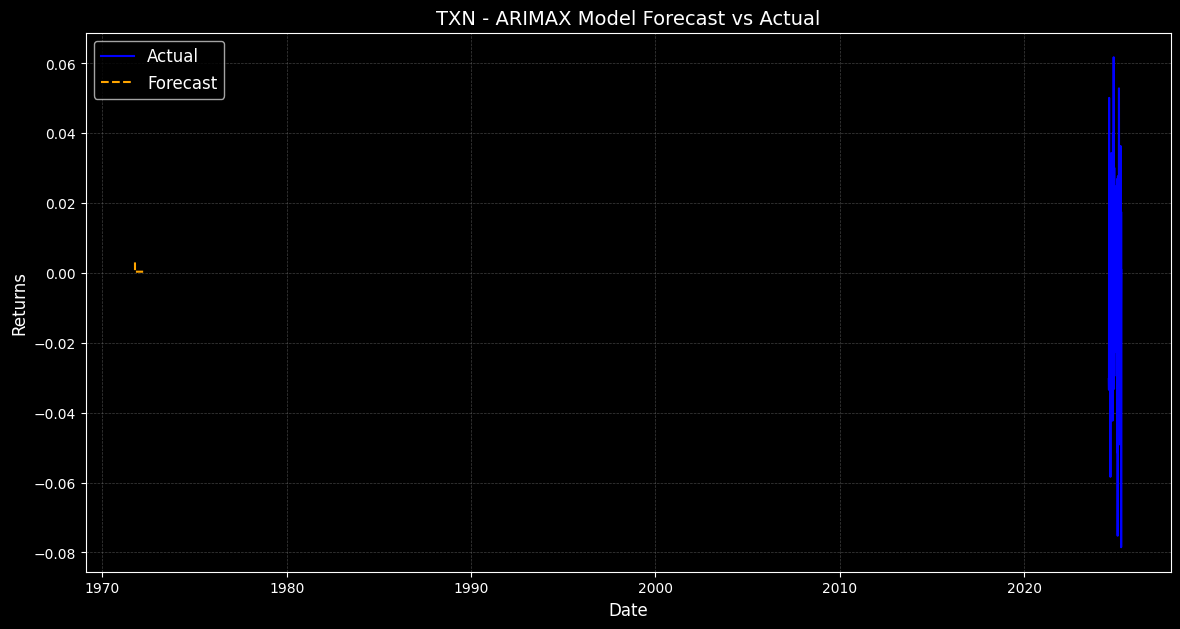


=== ARIMAX Results for TXN ===
MAE: 0.0158, MSE: 0.0005, RMSE: 0.0218, AIC: -3386.8666


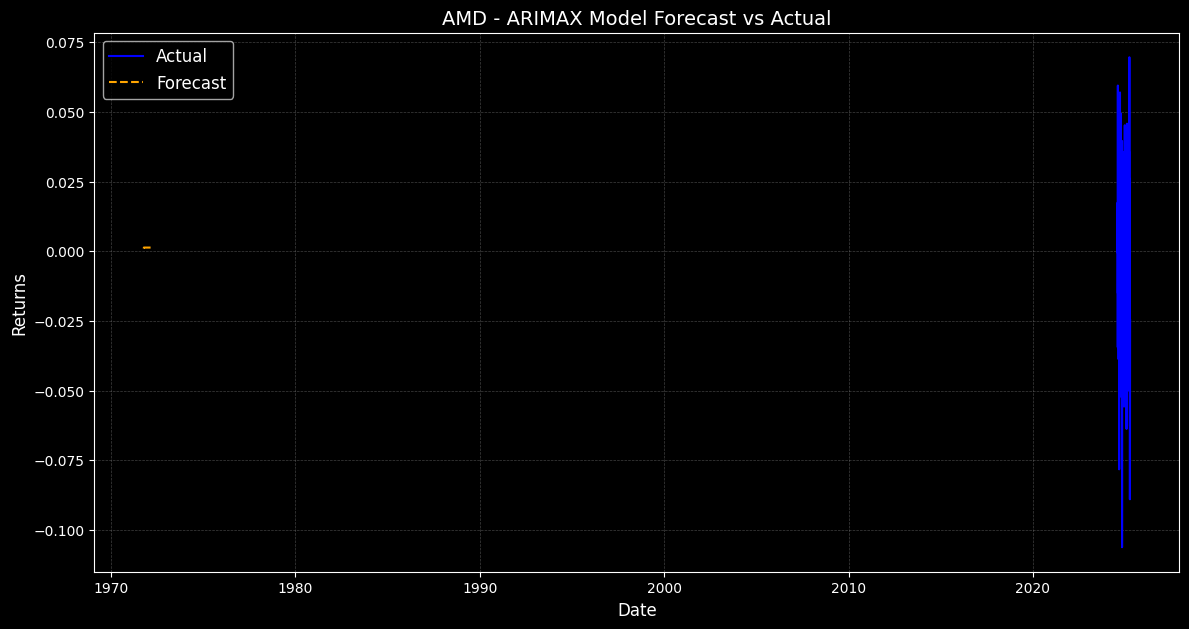


=== ARIMAX Results for AMD ===
MAE: 0.0218, MSE: 0.0008, RMSE: 0.0289, AIC: -2516.7797


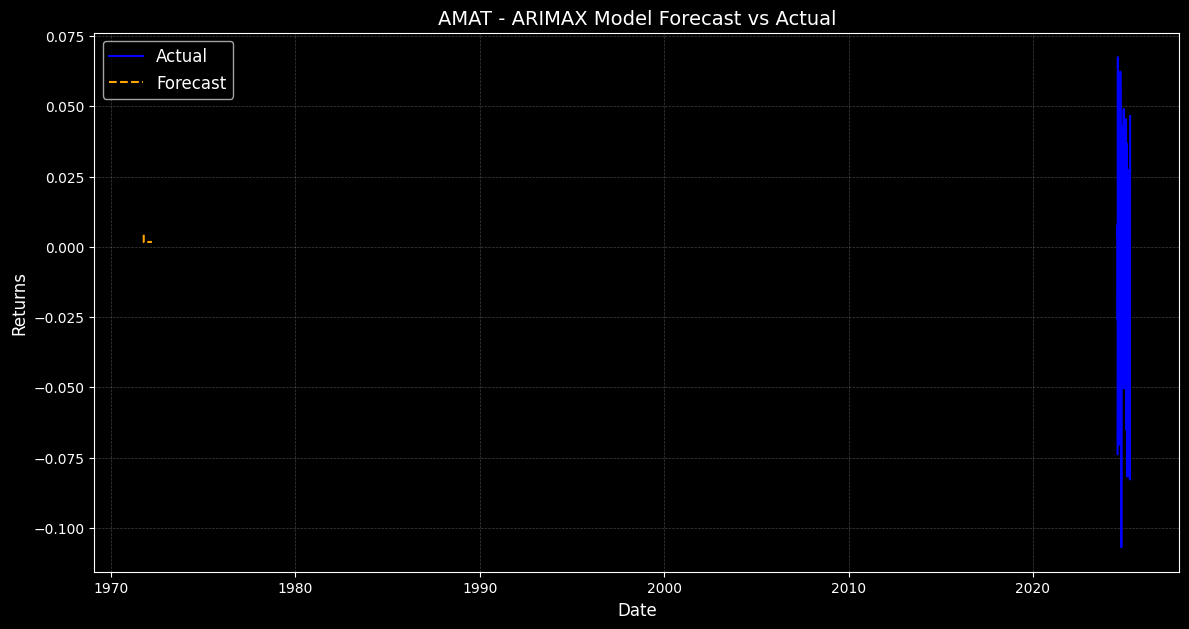


=== ARIMAX Results for AMAT ===
MAE: 0.0197, MSE: 0.0007, RMSE: 0.0272, AIC: -2824.5021


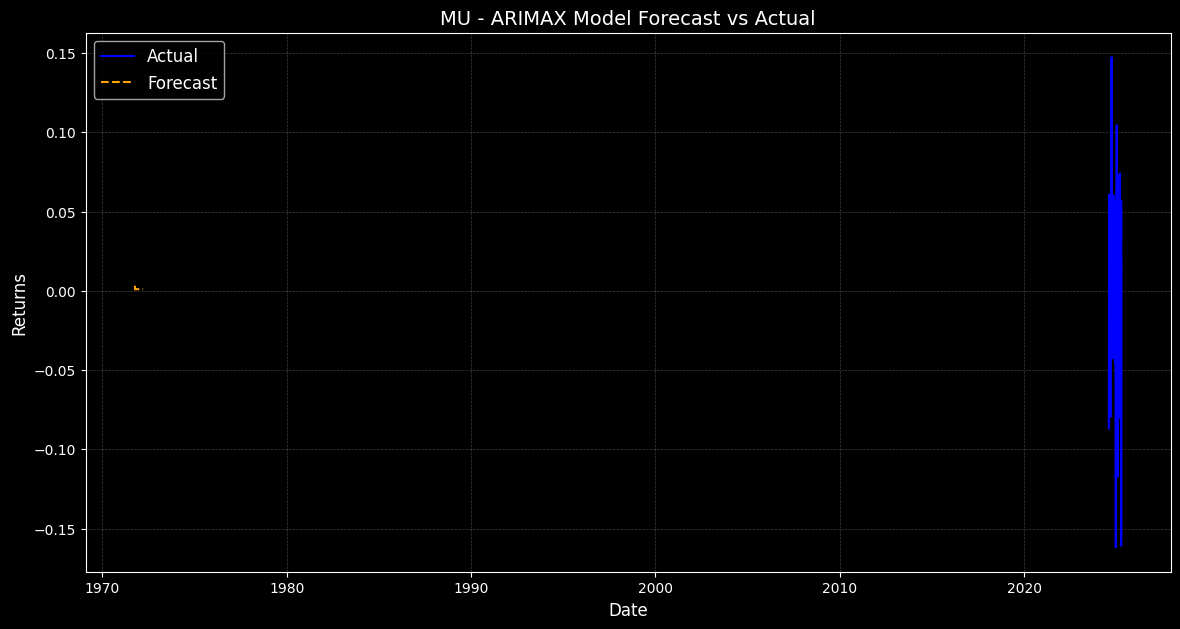


=== ARIMAX Results for MU ===
MAE: 0.0293, MSE: 0.0016, RMSE: 0.0406, AIC: -2801.5199


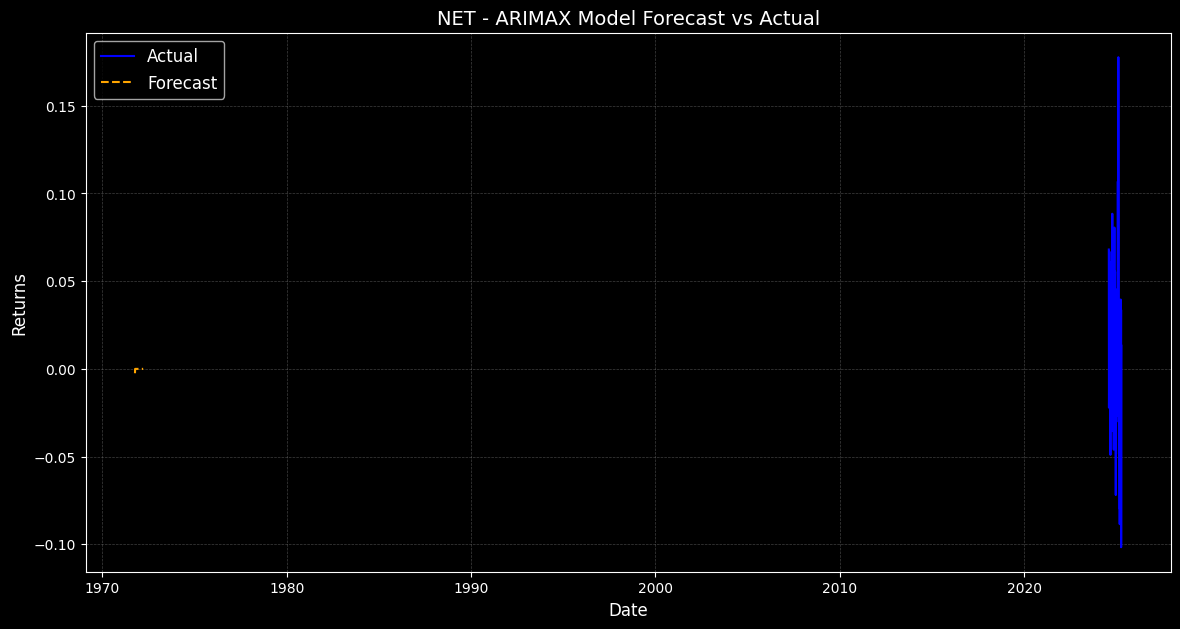


=== ARIMAX Results for NET ===
MAE: 0.0236, MSE: 0.0012, RMSE: 0.0339, AIC: -2028.3756


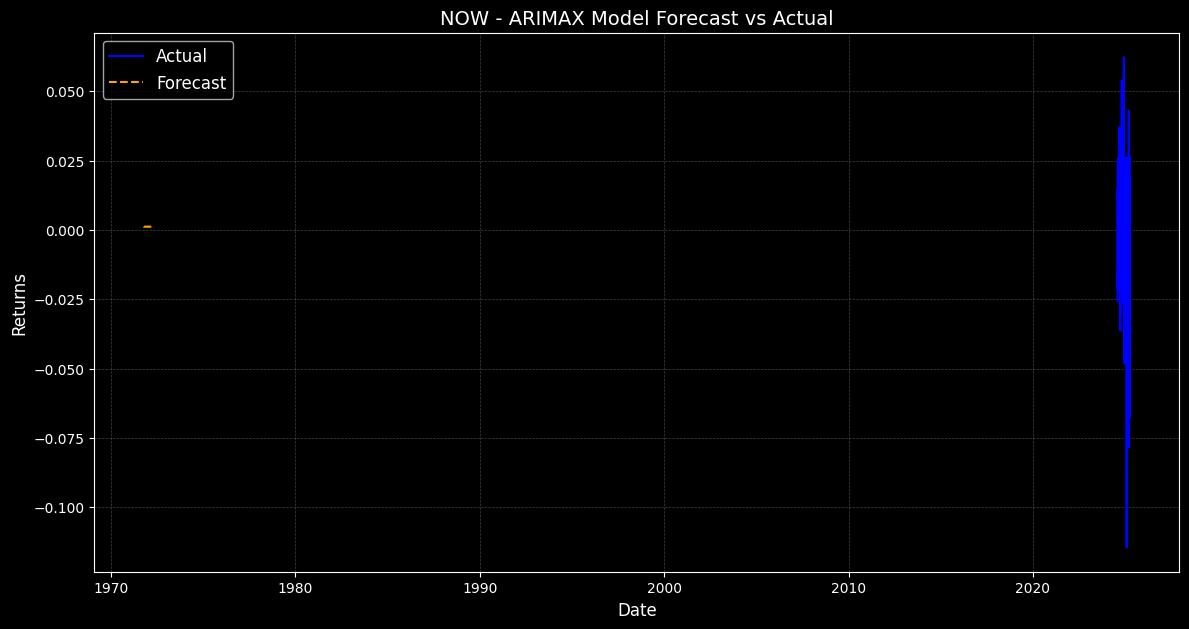


=== ARIMAX Results for NOW ===
MAE: 0.0162, MSE: 0.0005, RMSE: 0.0224, AIC: -2760.2087


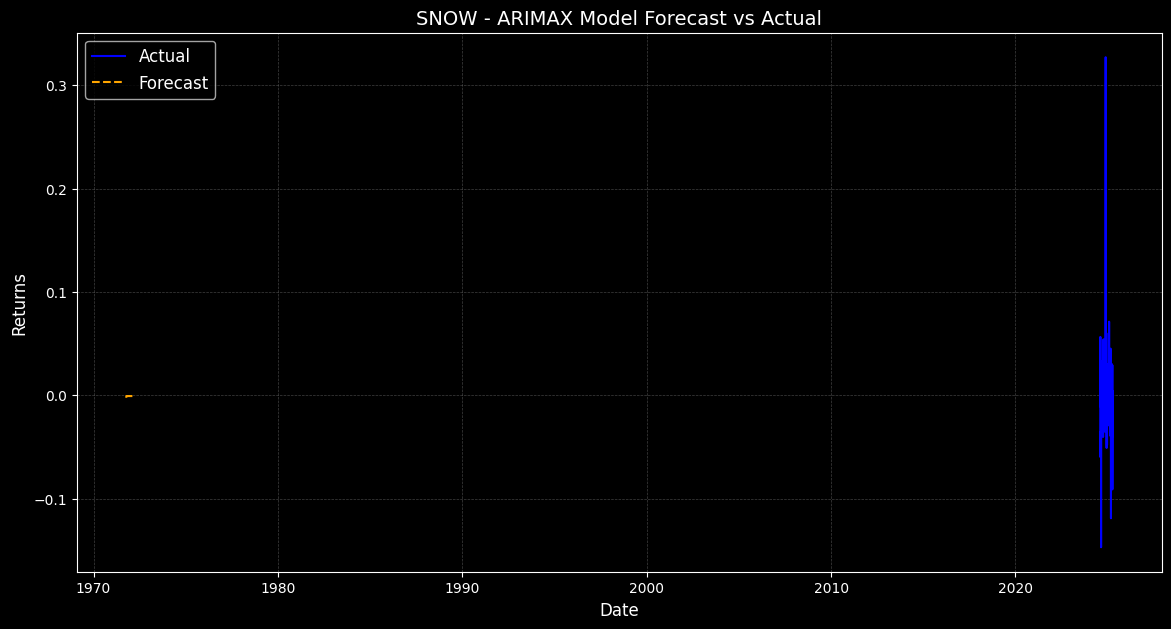


=== ARIMAX Results for SNOW ===
MAE: 0.0227, MSE: 0.0015, RMSE: 0.0387, AIC: -2273.0080


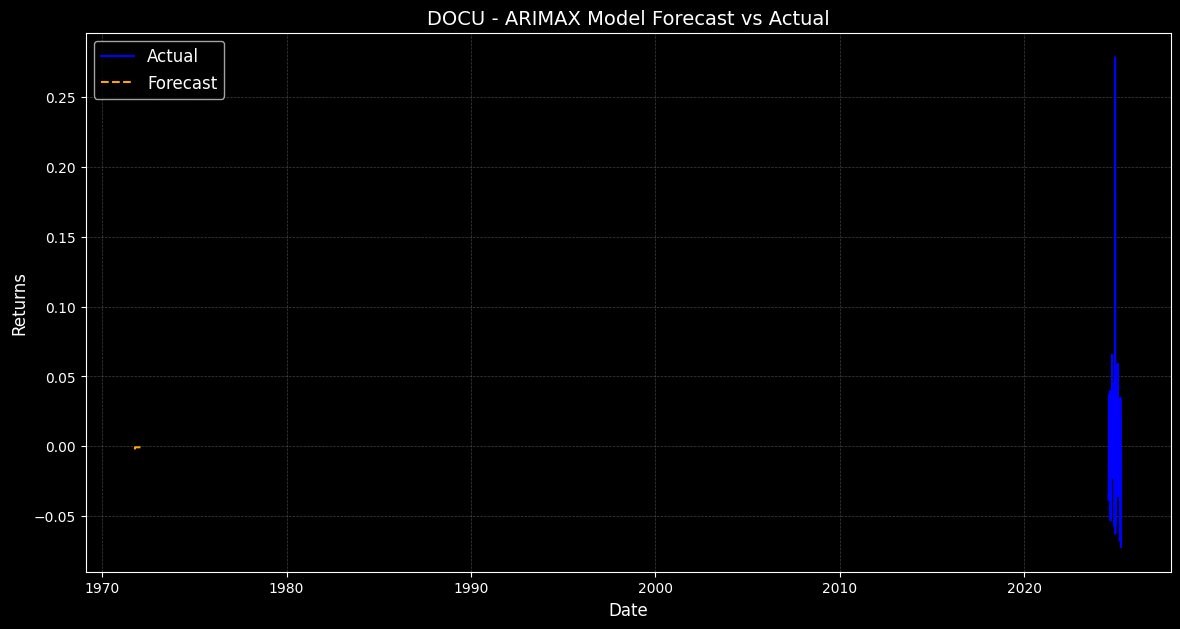


=== ARIMAX Results for DOCU ===
MAE: 0.0189, MSE: 0.0010, RMSE: 0.0319, AIC: -2253.3908


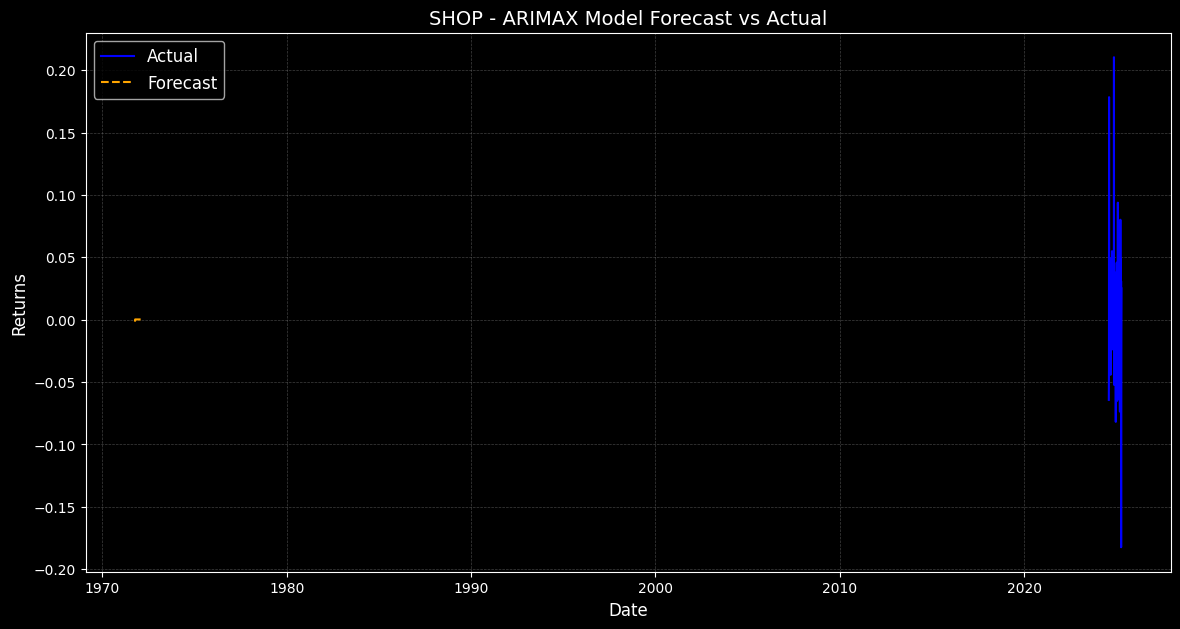


=== ARIMAX Results for SHOP ===
MAE: 0.0257, MSE: 0.0015, RMSE: 0.0391, AIC: -2135.7829


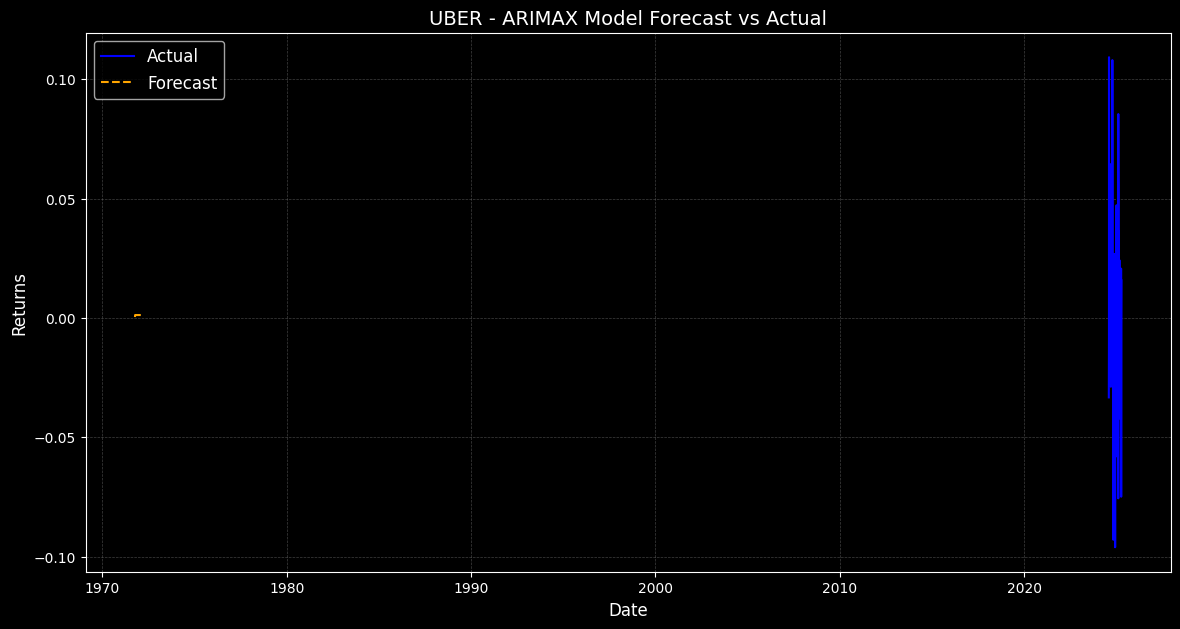


=== ARIMAX Results for UBER ===
MAE: 0.0191, MSE: 0.0008, RMSE: 0.0279, AIC: -2612.5222


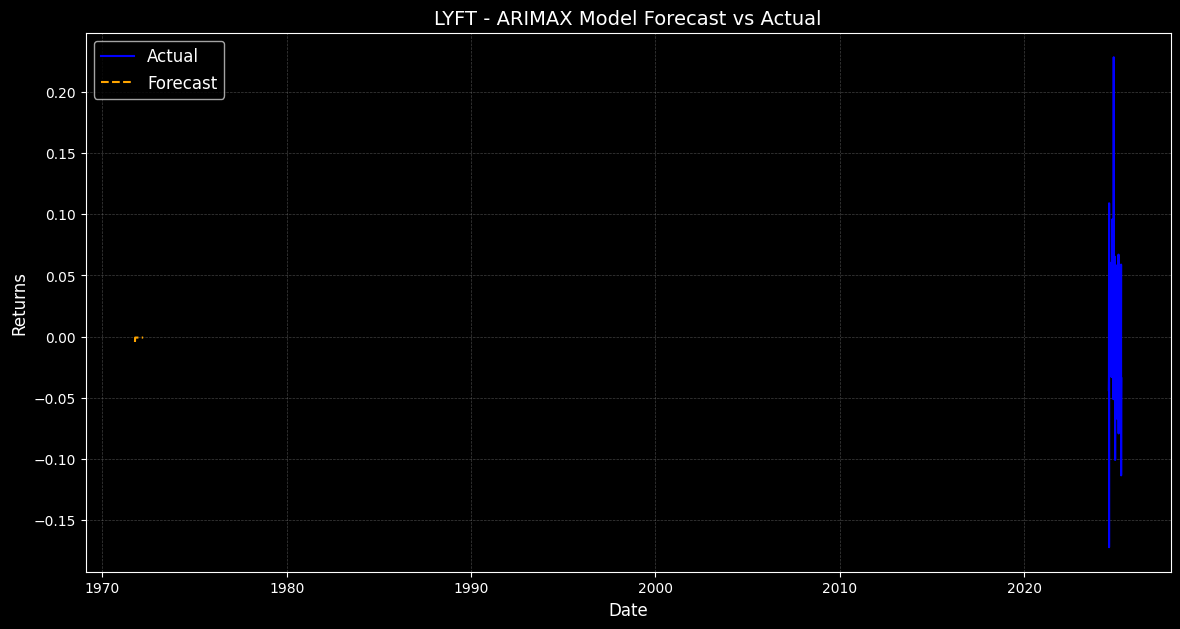


=== ARIMAX Results for LYFT ===
MAE: 0.0274, MSE: 0.0016, RMSE: 0.0398, AIC: -2092.5859


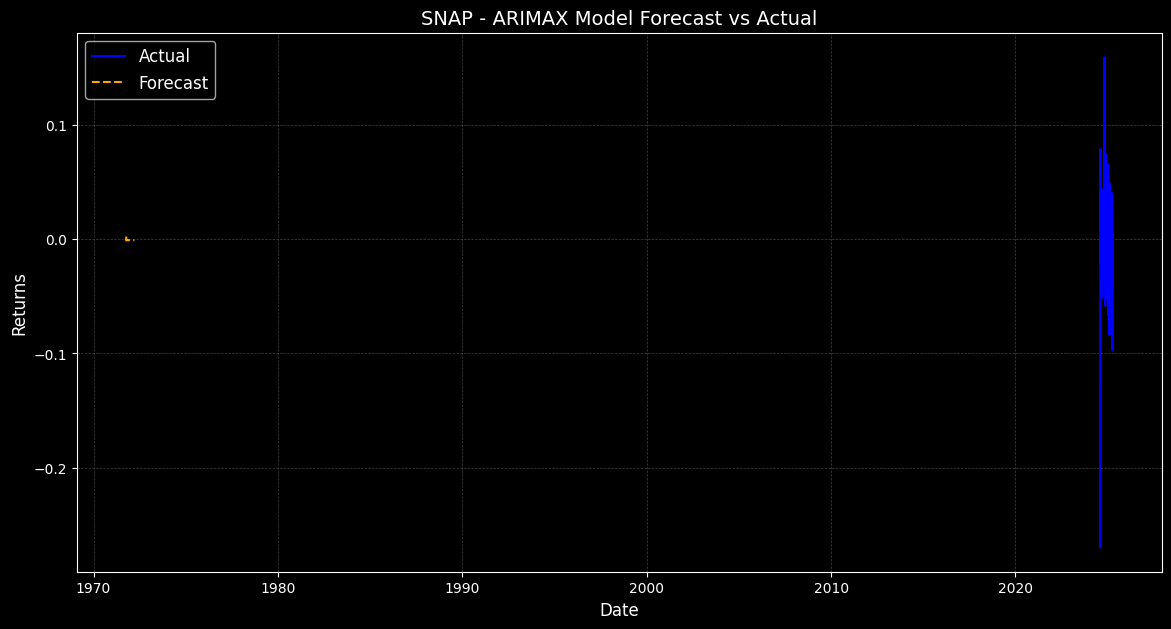


=== ARIMAX Results for SNAP ===
MAE: 0.0256, MSE: 0.0015, RMSE: 0.0386, AIC: -1905.2976


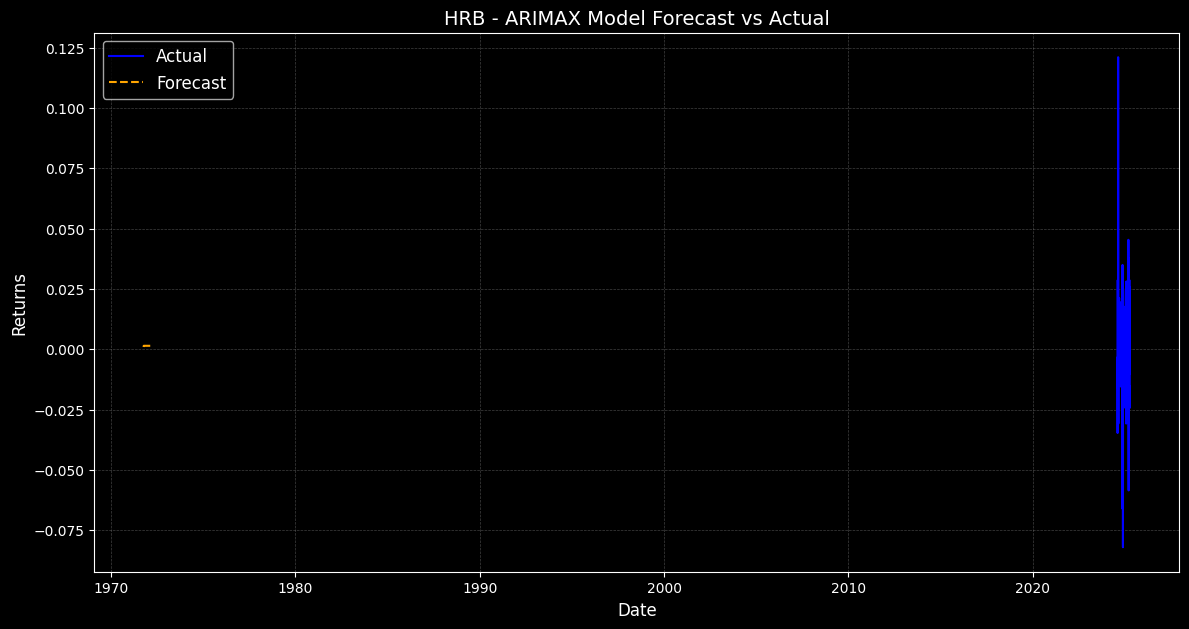


=== ARIMAX Results for HRB ===
MAE: 0.0128, MSE: 0.0004, RMSE: 0.0194, AIC: -3177.6832


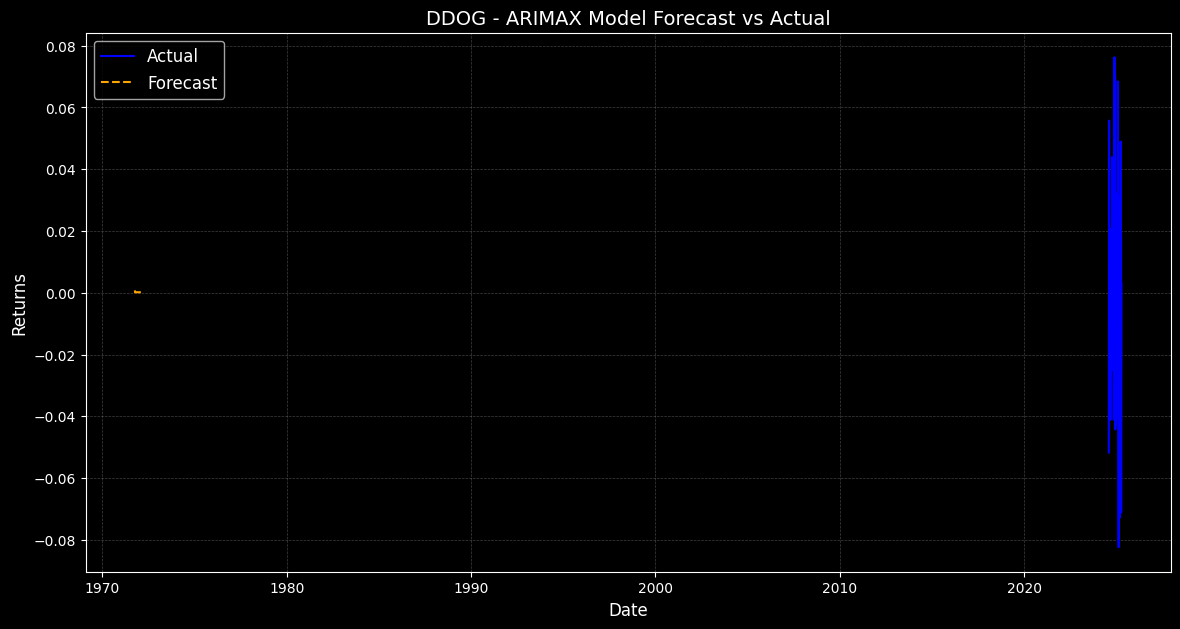


=== ARIMAX Results for DDOG ===
MAE: 0.0188, MSE: 0.0007, RMSE: 0.0255, AIC: -2325.2029


In [9]:
# Initialize results storage
results = []

# Iterate through each ticker
for ticker in all_returns.columns:
    try:
        # Extract endogenous variable (stock returns)
        endog = all_returns[ticker]

        # Extract exogenous variables (sentiment scores)
        exog = combined_data[[f'{ticker}_general_sentiment', f'{ticker}_ai_sentiment']].dropna()

        # Align endog and exog
        endog, exog = endog.align(exog, join='inner')

        # Split into train and test sets
        train_size = int(0.8 * len(endog))
        endog_train, endog_test = endog.iloc[:train_size], endog.iloc[train_size:]
        exog_train, exog_test = exog.iloc[:train_size], exog.iloc[train_size:]

        # Fit ARIMAX model
        model = fit_arimax(endog_train, exog_train, order=(1, 1, 1))

        # Evaluate ARIMAX model
        arimax_results = evaluate_arimax(ticker, model, endog_test, exog_test)

        # Store results
        results.append(arimax_results)

        # Print evaluation metrics
        print(f"\n=== ARIMAX Results for {ticker} ===")
        print(f"MAE: {arimax_results['MAE']:.4f}, MSE: {arimax_results['MSE']:.4f}, RMSE: {arimax_results['RMSE']:.4f}, AIC: {arimax_results['AIC']:.4f}")

    except Exception as e:
        print(f"Error processing ticker {ticker}: {e}")
        continue

# Convert results to DataFrame
results_df = pd.DataFrame(results)

# Save results to CSV for future analysis
results_df.to_csv("arimax_results_with_predictions.csv", index=False)

In [3]:
!pip install numpy pandas matplotlib statsmodels scikit-learn

  Using cached numpy-2.0.2-cp39-cp39-macosx_11_0_arm64.whl.metadata (60 kB)
  Using cached pandas-2.2.3-cp39-cp39-macosx_11_0_arm64.whl.metadata (89 kB)
  Using cached matplotlib-3.9.4-cp39-cp39-macosx_11_0_arm64.whl.metadata (11 kB)
  Using cached statsmodels-0.14.4-cp39-cp39-macosx_11_0_arm64.whl.metadata (9.2 kB)
  Using cached scikit_learn-1.6.1-cp39-cp39-macosx_12_0_arm64.whl.metadata (31 kB)
  Using cached pytz-2025.2-py2.py3-none-any.whl.metadata (22 kB)
  Using cached tzdata-2025.2-py2.py3-none-any.whl.metadata (1.4 kB)
  Using cached contourpy-1.3.0-cp39-cp39-macosx_11_0_arm64.whl.metadata (5.4 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached fonttools-4.57.0-cp39-cp39-macosx_10_9_universal2.whl.metadata (102 kB)
  Using cached kiwisolver-1.4.7-cp39-cp39-macosx_11_0_arm64.whl.metadata (6.3 kB)
  Using cached pillow-11.2.1-cp39-cp39-macosx_11_0_arm64.whl.metadata (8.9 kB)
  Using cached pyparsing-3.2.3-py3-none-any.whl.metadata (5.0 kB)
  Using